First of all I connected my Google Drive to Colab.
Steps after:
- **One GB Flickr Dataset**: https://www.kaggle.com/adityajn105/flickr8k/activity
  This dataset contains over 8000 images taken from 6 different Flickr groups and paired with 5 different captions. We need to download this zip file, remove the first row of captions.txt file (Optional: I also renamed it for safety), and move the Images folder and captions file to /content folder of drive. It makes to read the files faster and without any additional directory mentions.
- **GloVe 6B 200d**: https://www.kaggle.com/datasets/anindya2906/glove6b?select=glove.6B.200d.txt
I will explain about this file later :)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls -a /content

.   captions1.txt  data.zip  glove.6B.200d.txt	sample_data
..  .config	   drive     Images


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/glove.6B.200d.txt.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
! cp -a /content/drive/MyDrive/captions1.txt /content/

Essential Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.utils import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

In [ ]:
image_path = "Images/"
images = glob(image_path + "*.jpg")
len(images)

8091

Data visualization

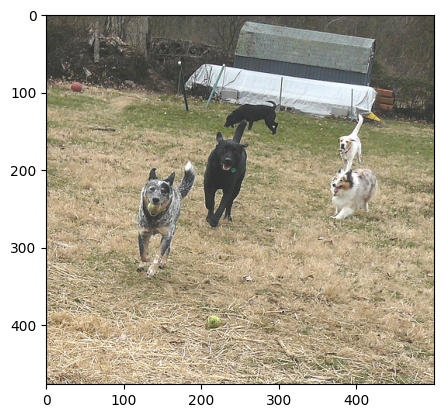

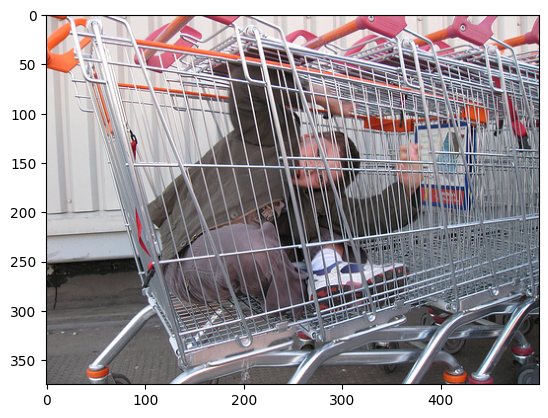

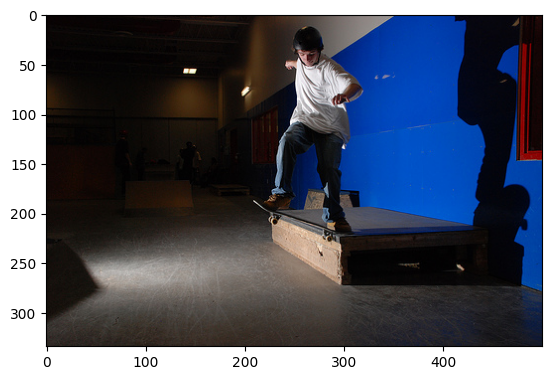

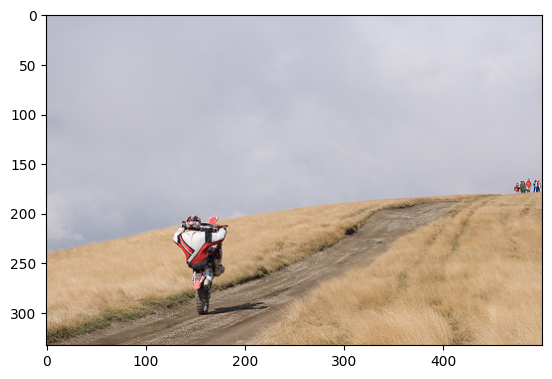

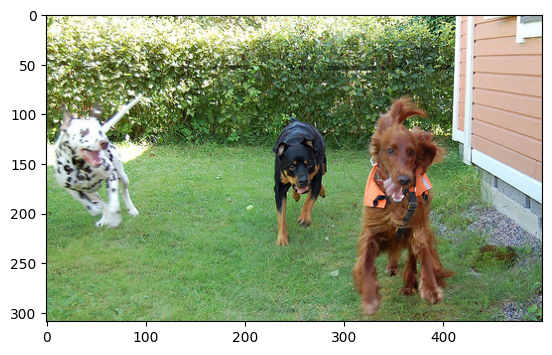

In [ ]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

Pre-processing

In [ ]:
def load(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
file = "captions1.txt"
info = load(file)
print(info[:470])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting



We need to save the image files and corresponding captions somehow. So I decided to save them in a dictionary

In [ ]:
def load_captions(info):
    dict_1 = dict()
    count = 0
    for line in info.split('\n'):
        if not line.strip():  # Skip empty lines
            continue

        splitter = line.split('.jpg,')
        if len(splitter) < 2:  # Skip lines without the expected separator
            continue

        image_code, image_caption = splitter[0], splitter[1]

        if image_code not in dict_1:
            dict_1[image_code] = list()

        dict_1[image_code].append(image_caption.strip())

    return dict_1

data = load_captions(info)
print(len(data))

8091


In [ ]:
list(data.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [ ]:
data['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

We need to clear the data, so I converted all the sentences and removed words with a length less than 2 for irrelevant characters.

In [ ]:
def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            for j in line1.split():
                if len(j) < 2:
                    continue
                j = j.lower()
                lines += j + " "
            if key not in dict_2:
                dict_2[key] = list()

            dict_2[key].append(lines)

    return dict_2

data2 = cleanse_data(data)
print(len(data2))

8091


Vocabulary is required for future calculations

In [ ]:
def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

9148


Captions file update:

In [ ]:
def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'captions1.txt')

My model is based on transfer learning, so I used Tensorflow official documentation on image captioning with visual attention: https://www.tensorflow.org/tutorials/text/image_captioning?ref=blog.paperspace.com

So I preprocessed the images for IncepotionV3 and passed them through the CNN. We need to pass encodings of images to RNN

In [ ]:
images = 'Images/'
img = glob(images + '*.jpg')
print(len(img))

def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # pre-process the images using preprocess_input() from inception module
    x = keras.applications.inception_v3.preprocess_input(x)
    return x

8091


In [ ]:
# Load the inception v3 model
input1 = InceptionV3(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the inception v3
model = Model(input1.input, input1.layers[-2].output)

model.summary()

96112376/96112376 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

encoding = {}

for i in tqdm(img):
    encoding[i[len(images):]] = encode(i)

import pickle

# I saved all the extracted features in a file for unexpected scenarios :)
with open("images1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding, encoded_pickle)

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


  0%|          | 1/8091 [00:11<26:22:11, 11.73s/it]

1/1 [==============================] - 0s 25ms/step


  0%|          | 3/8091 [00:11<6:58:11,  3.10s/it] 

1/1 [==============================] - 0s 26ms/step


  0%|          | 5/8091 [00:12<3:28:17,  1.55s/it]

1/1 [==============================] - 0s 25ms/step


  0%|          | 7/8091 [00:12<2:04:20,  1.08it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 9/8091 [00:12<1:21:38,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 11/8091 [00:12<57:00,  2.36it/s] 

1/1 [==============================] - 0s 25ms/step


  0%|          | 13/8091 [00:12<41:25,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 15/8091 [00:12<32:13,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 17/8091 [00:13<25:20,  5.31it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 19/8091 [00:13<20:56,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 21/8091 [00:13<17:55,  7.50it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 23/8091 [00:13<15:44,  8.54it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 25/8091 [00:13<15:08,  8.88it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 27/8091 [00:13<14:38,  9.18it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 29/8091 [00:14<13:22, 10.04it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 31/8091 [00:14<12:24, 10.82it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 33/8091 [00:14<12:11, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 35/8091 [00:14<11:38, 11.54it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 37/8091 [00:14<11:31, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 39/8091 [00:14<11:09, 12.03it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 41/8091 [00:15<10:53, 12.32it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 43/8091 [00:15<10:50, 12.38it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 45/8091 [00:15<11:01, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 47/8091 [00:15<10:51, 12.35it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 49/8091 [00:15<11:01, 12.16it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 51/8091 [00:15<12:58, 10.32it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 53/8091 [00:16<13:51,  9.67it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 55/8091 [00:16<14:16,  9.38it/s]

1/1 [==============================] - 0s 57ms/step


  1%|          | 56/8091 [00:16<15:31,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 57/8091 [00:16<15:30,  8.64it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 58/8091 [00:16<15:21,  8.71it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 59/8091 [00:16<16:26,  8.14it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 60/8091 [00:17<17:11,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 61/8091 [00:17<16:15,  8.23it/s]

1/1 [==============================] - 0s 52ms/step


  1%|          | 62/8091 [00:17<17:19,  7.73it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 63/8091 [00:17<17:16,  7.75it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 64/8091 [00:17<16:37,  8.05it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 65/8091 [00:17<15:52,  8.42it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 66/8091 [00:17<15:18,  8.74it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 67/8091 [00:17<14:57,  8.94it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 68/8091 [00:18<15:04,  8.87it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 69/8091 [00:18<15:09,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 70/8091 [00:18<14:45,  9.06it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 71/8091 [00:18<15:01,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 72/8091 [00:18<17:13,  7.76it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 73/8091 [00:18<16:07,  8.29it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 74/8091 [00:18<15:27,  8.64it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 75/8091 [00:18<16:42,  7.99it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 76/8091 [00:18<16:15,  8.21it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 77/8091 [00:19<15:44,  8.49it/s]

1/1 [==============================] - 0s 48ms/step


  1%|          | 78/8091 [00:19<15:37,  8.54it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 80/8091 [00:19<13:54,  9.60it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 82/8091 [00:19<12:47, 10.44it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 84/8091 [00:19<11:48, 11.30it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 86/8091 [00:19<11:17, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 88/8091 [00:20<10:53, 12.24it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 90/8091 [00:20<10:51, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 92/8091 [00:20<10:42, 12.45it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 94/8091 [00:20<10:33, 12.62it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 96/8091 [00:20<10:24, 12.79it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 98/8091 [00:20<10:34, 12.59it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 100/8091 [00:20<10:29, 12.70it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 102/8091 [00:21<10:34, 12.60it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 104/8091 [00:21<10:29, 12.68it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 106/8091 [00:21<10:38, 12.51it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 108/8091 [00:21<10:44, 12.39it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 110/8091 [00:21<10:36, 12.53it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 112/8091 [00:21<10:18, 12.90it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 114/8091 [00:22<10:16, 12.94it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 116/8091 [00:22<10:25, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 118/8091 [00:22<10:19, 12.86it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 120/8091 [00:22<10:23, 12.78it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 122/8091 [00:22<10:16, 12.92it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 124/8091 [00:22<11:03, 12.01it/s]

1/1 [==============================] - 0s 61ms/step


  2%|▏         | 126/8091 [00:23<11:39, 11.39it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 128/8091 [00:23<14:56,  8.88it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 129/8091 [00:23<17:15,  7.69it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 130/8091 [00:23<16:54,  7.85it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 132/8091 [00:23<14:39,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 134/8091 [00:24<13:35,  9.76it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 136/8091 [00:24<12:43, 10.42it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 138/8091 [00:24<12:03, 10.99it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 140/8091 [00:24<11:32, 11.47it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 142/8091 [00:24<11:09, 11.87it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 144/8091 [00:24<11:00, 12.03it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 146/8091 [00:25<10:49, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 148/8091 [00:25<10:43, 12.34it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 150/8091 [00:25<10:34, 12.52it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 152/8091 [00:25<11:27, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 154/8091 [00:25<11:03, 11.96it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 156/8091 [00:25<10:48, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 158/8091 [00:26<10:33, 12.52it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 160/8091 [00:26<10:21, 12.77it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 162/8091 [00:26<10:20, 12.79it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 164/8091 [00:26<12:45, 10.35it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 166/8091 [00:26<16:15,  8.13it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 168/8091 [00:27<14:14,  9.27it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 170/8091 [00:27<13:00, 10.15it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 172/8091 [00:27<12:10, 10.85it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 174/8091 [00:27<12:28, 10.58it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 176/8091 [00:27<11:48, 11.16it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 178/8091 [00:27<11:24, 11.57it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 180/8091 [00:28<11:04, 11.90it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 182/8091 [00:28<10:45, 12.26it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 184/8091 [00:28<10:37, 12.41it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 186/8091 [00:28<10:27, 12.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 188/8091 [00:28<10:52, 12.12it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 190/8091 [00:28<10:55, 12.06it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 192/8091 [00:29<10:34, 12.46it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 194/8091 [00:29<10:25, 12.63it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 196/8091 [00:29<11:55, 11.03it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 198/8091 [00:29<12:36, 10.43it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 200/8091 [00:29<14:44,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 201/8091 [00:30<14:29,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 202/8091 [00:30<14:26,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 203/8091 [00:30<15:25,  8.52it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 204/8091 [00:30<15:15,  8.62it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 205/8091 [00:30<15:20,  8.56it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 206/8091 [00:30<16:17,  8.06it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 207/8091 [00:30<16:01,  8.20it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 208/8091 [00:30<16:19,  8.05it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 209/8091 [00:31<17:10,  7.65it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 210/8091 [00:31<17:45,  7.40it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 211/8091 [00:31<18:26,  7.12it/s]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 212/8091 [00:31<17:29,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 213/8091 [00:31<16:46,  7.83it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 214/8091 [00:31<17:02,  7.70it/s]

1/1 [==============================] - 0s 71ms/step


  3%|▎         | 215/8091 [00:31<20:10,  6.51it/s]

1/1 [==============================] - 0s 111ms/step


  3%|▎         | 216/8091 [00:32<23:49,  5.51it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 217/8091 [00:32<25:50,  5.08it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 218/8091 [00:32<28:36,  4.59it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 219/8091 [00:32<27:48,  4.72it/s]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 220/8091 [00:33<28:50,  4.55it/s]

1/1 [==============================] - 0s 75ms/step


  3%|▎         | 221/8091 [00:33<25:56,  5.06it/s]

1/1 [==============================] - 0s 58ms/step


  3%|▎         | 222/8091 [00:33<26:46,  4.90it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 223/8091 [00:33<26:02,  5.03it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 224/8091 [00:33<27:44,  4.73it/s]

1/1 [==============================] - 0s 83ms/step


  3%|▎         | 225/8091 [00:34<25:45,  5.09it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 226/8091 [00:34<29:43,  4.41it/s]

1/1 [==============================] - 0s 130ms/step


  3%|▎         | 227/8091 [00:34<31:13,  4.20it/s]

1/1 [==============================] - 0s 75ms/step


  3%|▎         | 228/8091 [00:34<33:13,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 229/8091 [00:35<27:29,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 231/8091 [00:35<19:21,  6.76it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 233/8091 [00:35<16:03,  8.16it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 235/8091 [00:35<14:08,  9.26it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 237/8091 [00:35<12:41, 10.32it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 239/8091 [00:35<12:08, 10.78it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 241/8091 [00:36<11:35, 11.29it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 243/8091 [00:36<11:07, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 245/8091 [00:36<10:46, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 247/8091 [00:36<11:51, 11.03it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 249/8091 [00:36<11:21, 11.51it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 251/8091 [00:36<11:11, 11.67it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 253/8091 [00:37<10:47, 12.11it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 255/8091 [00:37<10:29, 12.45it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 257/8091 [00:37<10:22, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 259/8091 [00:37<10:36, 12.30it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 261/8091 [00:37<10:31, 12.39it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 263/8091 [00:37<10:21, 12.60it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 265/8091 [00:37<10:16, 12.70it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 267/8091 [00:38<10:24, 12.53it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 269/8091 [00:38<11:13, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 271/8091 [00:38<12:24, 10.51it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 273/8091 [00:38<11:41, 11.14it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 275/8091 [00:38<11:11, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 277/8091 [00:39<11:01, 11.81it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 279/8091 [00:39<10:38, 12.24it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 281/8091 [00:39<10:25, 12.48it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 283/8091 [00:39<10:20, 12.58it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 285/8091 [00:39<11:09, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 287/8091 [00:39<10:52, 11.96it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 289/8091 [00:39<10:35, 12.27it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 291/8091 [00:40<10:19, 12.59it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 293/8091 [00:40<10:11, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 295/8091 [00:40<10:19, 12.59it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 297/8091 [00:40<10:17, 12.62it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 299/8091 [00:40<10:15, 12.66it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 301/8091 [00:40<10:22, 12.52it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 303/8091 [00:41<10:20, 12.55it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 305/8091 [00:41<10:14, 12.67it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 307/8091 [00:41<10:11, 12.74it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 309/8091 [00:41<10:15, 12.63it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 311/8091 [00:41<10:09, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 313/8091 [00:41<10:10, 12.74it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 315/8091 [00:42<10:12, 12.70it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 317/8091 [00:42<10:02, 12.91it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 319/8091 [00:42<11:34, 11.18it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 321/8091 [00:42<11:11, 11.56it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 323/8091 [00:42<10:47, 12.00it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 325/8091 [00:42<10:43, 12.07it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 327/8091 [00:43<10:30, 12.32it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 329/8091 [00:43<12:15, 10.55it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 331/8091 [00:43<13:07,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 333/8091 [00:43<13:59,  9.25it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 334/8091 [00:43<14:10,  9.12it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 335/8091 [00:44<14:26,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 336/8091 [00:44<15:35,  8.29it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 337/8091 [00:44<15:10,  8.51it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 338/8091 [00:44<15:13,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 339/8091 [00:44<15:20,  8.42it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 340/8091 [00:44<14:45,  8.75it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 341/8091 [00:44<15:54,  8.12it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 342/8091 [00:44<15:28,  8.35it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 343/8091 [00:44<14:56,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 344/8091 [00:45<14:53,  8.67it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 345/8091 [00:45<14:52,  8.68it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 346/8091 [00:45<15:03,  8.57it/s]

1/1 [==============================] - 0s 62ms/step


  4%|▍         | 347/8091 [00:45<15:49,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 348/8091 [00:45<15:25,  8.37it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 349/8091 [00:45<16:21,  7.89it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 350/8091 [00:45<15:42,  8.21it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 351/8091 [00:45<15:07,  8.53it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 352/8091 [00:46<16:04,  8.02it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 353/8091 [00:46<17:01,  7.57it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 354/8091 [00:46<16:22,  7.88it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 355/8091 [00:46<15:37,  8.25it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 356/8091 [00:46<16:05,  8.01it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 357/8091 [00:46<17:22,  7.42it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 359/8091 [00:46<13:56,  9.25it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 361/8091 [00:47<13:15,  9.71it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 362/8091 [00:47<13:47,  9.34it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 364/8091 [00:47<12:21, 10.42it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 366/8091 [00:47<11:42, 10.99it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 368/8091 [00:47<11:11, 11.50it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 370/8091 [00:47<10:49, 11.89it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 372/8091 [00:48<11:17, 11.39it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 374/8091 [00:48<11:10, 11.51it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 376/8091 [00:48<10:56, 11.75it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 378/8091 [00:48<10:37, 12.09it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 380/8091 [00:48<10:25, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 382/8091 [00:48<11:03, 11.61it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 384/8091 [00:49<10:57, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 386/8091 [00:49<11:35, 11.07it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 388/8091 [00:49<11:13, 11.44it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 390/8091 [00:49<10:52, 11.80it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 392/8091 [00:49<10:46, 11.90it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 394/8091 [00:49<10:30, 12.20it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 396/8091 [00:50<10:16, 12.49it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 398/8091 [00:50<10:49, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 400/8091 [00:50<10:46, 11.89it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 402/8091 [00:50<10:35, 12.10it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 404/8091 [00:50<10:23, 12.33it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 406/8091 [00:50<10:10, 12.58it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 408/8091 [00:51<10:05, 12.69it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 410/8091 [00:51<10:48, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 412/8091 [00:51<13:20,  9.59it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 414/8091 [00:51<12:23, 10.32it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 416/8091 [00:51<11:41, 10.94it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▌         | 418/8091 [00:52<11:57, 10.70it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 420/8091 [00:52<14:09,  9.03it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 422/8091 [00:52<12:56,  9.88it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 424/8091 [00:52<12:06, 10.55it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 426/8091 [00:52<11:26, 11.16it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 428/8091 [00:52<11:09, 11.45it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 430/8091 [00:53<10:43, 11.90it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 432/8091 [00:53<10:53, 11.71it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 434/8091 [00:53<10:38, 11.99it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 436/8091 [00:53<10:34, 12.07it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 438/8091 [00:53<10:53, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 440/8091 [00:53<10:39, 11.97it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 442/8091 [00:54<10:18, 12.36it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 444/8091 [00:54<10:38, 11.97it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 446/8091 [00:54<10:25, 12.22it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 448/8091 [00:54<10:18, 12.35it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 450/8091 [00:54<10:16, 12.40it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 452/8091 [00:54<10:59, 11.59it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 454/8091 [00:55<10:46, 11.82it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 456/8091 [00:55<11:32, 11.03it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 458/8091 [00:55<11:05, 11.47it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 460/8091 [00:55<10:44, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 462/8091 [00:55<10:47, 11.79it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 464/8091 [00:55<10:59, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 466/8091 [00:56<10:41, 11.89it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 468/8091 [00:56<10:29, 12.10it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 470/8091 [00:56<10:27, 12.15it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 472/8091 [00:56<12:04, 10.51it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 474/8091 [00:56<12:43,  9.98it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 476/8091 [00:57<12:58,  9.78it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 478/8091 [00:57<13:37,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 479/8091 [00:57<13:35,  9.33it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 480/8091 [00:57<14:48,  8.57it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 481/8091 [00:57<14:40,  8.64it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 482/8091 [00:57<16:05,  7.88it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 483/8091 [00:58<16:42,  7.59it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 484/8091 [00:58<16:59,  7.46it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 485/8091 [00:58<16:35,  7.64it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▌         | 486/8091 [00:58<16:20,  7.76it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 487/8091 [00:58<15:38,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 488/8091 [00:58<16:22,  7.74it/s]

1/1 [==============================] - 0s 57ms/step


  6%|▌         | 489/8091 [00:58<17:44,  7.14it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 490/8091 [00:58<16:32,  7.66it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 491/8091 [00:59<17:14,  7.35it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 492/8091 [00:59<17:28,  7.25it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 493/8091 [00:59<16:29,  7.68it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 494/8091 [00:59<17:09,  7.38it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 495/8091 [00:59<16:05,  7.87it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 496/8091 [00:59<15:12,  8.33it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 497/8091 [00:59<16:15,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 498/8091 [01:00<17:15,  7.33it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 499/8091 [01:00<17:44,  7.13it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 501/8091 [01:00<15:30,  8.16it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 503/8091 [01:00<13:20,  9.48it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 505/8091 [01:00<12:19, 10.26it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 507/8091 [01:00<12:06, 10.44it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 509/8091 [01:01<11:38, 10.85it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 511/8091 [01:01<11:30, 10.98it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 513/8091 [01:01<11:29, 10.99it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 515/8091 [01:01<11:18, 11.16it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 517/8091 [01:01<10:56, 11.54it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 519/8091 [01:01<10:32, 11.97it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 521/8091 [01:02<10:14, 12.32it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 523/8091 [01:02<10:50, 11.63it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 525/8091 [01:02<10:57, 11.51it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 527/8091 [01:02<11:29, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 529/8091 [01:02<11:10, 11.29it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 531/8091 [01:02<10:46, 11.68it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 533/8091 [01:03<10:35, 11.89it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 535/8091 [01:03<11:13, 11.22it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 537/8091 [01:03<11:01, 11.42it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 539/8091 [01:03<11:28, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 541/8091 [01:03<11:06, 11.33it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 543/8091 [01:04<10:44, 11.72it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 545/8091 [01:04<10:23, 12.10it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 547/8091 [01:04<11:11, 11.23it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 549/8091 [01:04<10:57, 11.47it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 551/8091 [01:04<10:45, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 553/8091 [01:04<12:03, 10.42it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 555/8091 [01:05<11:15, 11.15it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 557/8091 [01:05<11:38, 10.78it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 559/8091 [01:05<11:22, 11.03it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 561/8091 [01:05<12:01, 10.43it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 563/8091 [01:05<11:24, 11.00it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 565/8091 [01:06<10:56, 11.46it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 567/8091 [01:06<11:18, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 569/8091 [01:06<11:14, 11.15it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 571/8091 [01:06<10:50, 11.56it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 573/8091 [01:06<10:56, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 575/8091 [01:06<11:34, 10.83it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 577/8091 [01:07<11:06, 11.28it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 579/8091 [01:07<11:01, 11.35it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 581/8091 [01:07<10:38, 11.75it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 583/8091 [01:07<10:33, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 585/8091 [01:07<11:04, 11.29it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 587/8091 [01:07<11:37, 10.75it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 589/8091 [01:08<11:01, 11.35it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 591/8091 [01:08<10:33, 11.84it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 593/8091 [01:08<11:08, 11.21it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 595/8091 [01:08<11:01, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 597/8091 [01:08<10:50, 11.52it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 599/8091 [01:08<10:33, 11.83it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 601/8091 [01:09<10:18, 12.10it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 603/8091 [01:09<11:00, 11.33it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 605/8091 [01:09<11:45, 10.61it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 607/8091 [01:09<11:53, 10.49it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 609/8091 [01:09<11:17, 11.04it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 611/8091 [01:10<10:50, 11.50it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 613/8091 [01:10<11:51, 10.51it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 615/8091 [01:10<12:58,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 616/8091 [01:10<13:48,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 617/8091 [01:10<14:40,  8.49it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 618/8091 [01:10<14:29,  8.59it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 619/8091 [01:11<14:05,  8.84it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 620/8091 [01:11<14:23,  8.65it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 621/8091 [01:11<15:33,  8.00it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 622/8091 [01:11<17:04,  7.29it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 623/8091 [01:11<17:49,  6.98it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 624/8091 [01:11<16:35,  7.50it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 625/8091 [01:11<15:56,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 626/8091 [01:11<15:16,  8.14it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 627/8091 [01:12<15:05,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 628/8091 [01:12<15:53,  7.82it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 629/8091 [01:12<17:03,  7.29it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 630/8091 [01:12<16:25,  7.57it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 631/8091 [01:12<18:10,  6.84it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 632/8091 [01:12<18:19,  6.79it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 633/8091 [01:13<18:15,  6.81it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 634/8091 [01:13<18:26,  6.74it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 635/8091 [01:13<17:20,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 636/8091 [01:13<17:38,  7.04it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 637/8091 [01:13<17:46,  6.99it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 638/8091 [01:13<17:06,  7.26it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 639/8091 [01:13<16:18,  7.62it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 641/8091 [01:13<13:21,  9.29it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 643/8091 [01:14<11:59, 10.35it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 645/8091 [01:14<11:15, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 647/8091 [01:14<11:00, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 649/8091 [01:14<11:37, 10.67it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 651/8091 [01:14<11:07, 11.15it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 653/8091 [01:14<10:39, 11.62it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 655/8091 [01:15<10:26, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 657/8091 [01:15<10:29, 11.80it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 659/8091 [01:15<10:26, 11.86it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 661/8091 [01:15<10:20, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 663/8091 [01:15<10:21, 11.95it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 665/8091 [01:15<10:11, 12.15it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 667/8091 [01:16<10:08, 12.21it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 669/8091 [01:16<10:06, 12.24it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 671/8091 [01:16<10:54, 11.34it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 673/8091 [01:16<10:39, 11.59it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 675/8091 [01:16<11:38, 10.62it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 677/8091 [01:17<11:22, 10.87it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 679/8091 [01:17<11:39, 10.59it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 681/8091 [01:17<11:04, 11.16it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 683/8091 [01:17<10:46, 11.47it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 685/8091 [01:17<10:48, 11.42it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 687/8091 [01:17<10:30, 11.74it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 689/8091 [01:18<10:25, 11.84it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 691/8091 [01:18<10:18, 11.97it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 693/8091 [01:18<10:19, 11.94it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 695/8091 [01:18<10:19, 11.95it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 697/8091 [01:18<10:17, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 699/8091 [01:18<10:12, 12.06it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 701/8091 [01:19<10:16, 11.98it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 703/8091 [01:19<10:16, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 705/8091 [01:19<10:02, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 707/8091 [01:19<10:10, 12.10it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 709/8091 [01:19<10:10, 12.10it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 711/8091 [01:19<10:25, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 713/8091 [01:20<10:14, 12.01it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 715/8091 [01:20<10:08, 12.12it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 717/8091 [01:20<10:06, 12.15it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 719/8091 [01:20<10:08, 12.12it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 721/8091 [01:20<10:07, 12.12it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 723/8091 [01:20<10:06, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 725/8091 [01:21<09:59, 12.30it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 727/8091 [01:21<09:58, 12.31it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 729/8091 [01:21<10:51, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 731/8091 [01:21<10:37, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 733/8091 [01:21<10:48, 11.34it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 735/8091 [01:22<11:29, 10.67it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 737/8091 [01:22<11:12, 10.94it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 739/8091 [01:22<10:50, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 741/8091 [01:22<10:28, 11.69it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 743/8091 [01:22<10:13, 11.97it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 745/8091 [01:22<10:57, 11.17it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 747/8091 [01:23<10:42, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 749/8091 [01:23<11:09, 10.97it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 751/8091 [01:23<10:39, 11.48it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 753/8091 [01:23<10:22, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 755/8091 [01:23<10:20, 11.82it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 757/8091 [01:23<11:49, 10.33it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 759/8091 [01:24<12:13,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 761/8091 [01:24<13:54,  8.78it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 762/8091 [01:24<13:51,  8.82it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 763/8091 [01:24<13:52,  8.80it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▉         | 764/8091 [01:24<14:05,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 765/8091 [01:24<14:19,  8.52it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 766/8091 [01:25<15:15,  8.00it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 767/8091 [01:25<14:49,  8.23it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 768/8091 [01:25<15:03,  8.10it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 769/8091 [01:25<14:36,  8.35it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 770/8091 [01:25<14:37,  8.34it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 771/8091 [01:25<14:35,  8.37it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 772/8091 [01:25<15:49,  7.71it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 773/8091 [01:25<15:21,  7.94it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 774/8091 [01:26<16:31,  7.38it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 775/8091 [01:26<17:26,  6.99it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 776/8091 [01:26<16:14,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 777/8091 [01:26<15:18,  7.96it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 778/8091 [01:26<16:50,  7.24it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 779/8091 [01:26<16:00,  7.62it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 780/8091 [01:26<15:58,  7.63it/s]

1/1 [==============================] - 0s 47ms/step


 10%|▉         | 781/8091 [01:27<15:18,  7.96it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 782/8091 [01:27<15:12,  8.01it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 783/8091 [01:27<15:51,  7.68it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 784/8091 [01:27<17:09,  7.10it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 785/8091 [01:27<17:43,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 787/8091 [01:27<15:27,  7.88it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 789/8091 [01:27<13:24,  9.08it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 791/8091 [01:28<12:26,  9.78it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 793/8091 [01:28<11:50, 10.27it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 795/8091 [01:28<11:12, 10.85it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 797/8091 [01:28<10:53, 11.17it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 799/8091 [01:28<10:41, 11.36it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 801/8091 [01:28<10:33, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 803/8091 [01:29<10:23, 11.70it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 805/8091 [01:29<10:27, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 807/8091 [01:29<10:16, 11.82it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 809/8091 [01:29<10:13, 11.87it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 811/8091 [01:29<10:13, 11.87it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 813/8091 [01:30<10:41, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 815/8091 [01:30<11:16, 10.76it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 817/8091 [01:30<11:37, 10.43it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 819/8091 [01:30<11:16, 10.76it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 821/8091 [01:30<11:31, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 823/8091 [01:30<11:00, 11.01it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 825/8091 [01:31<11:27, 10.57it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 827/8091 [01:31<11:14, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 829/8091 [01:31<10:55, 11.08it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 831/8091 [01:31<10:32, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 833/8091 [01:31<10:25, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 835/8091 [01:32<10:24, 11.62it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 837/8091 [01:32<10:20, 11.69it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 839/8091 [01:32<10:19, 11.71it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 841/8091 [01:32<10:13, 11.83it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 843/8091 [01:32<10:21, 11.66it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 845/8091 [01:32<10:14, 11.78it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 847/8091 [01:33<10:54, 11.07it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 849/8091 [01:33<10:43, 11.25it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 851/8091 [01:33<11:06, 10.86it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 853/8091 [01:33<10:45, 11.21it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 855/8091 [01:33<10:35, 11.38it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 857/8091 [01:33<10:20, 11.66it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 859/8091 [01:34<10:50, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 861/8091 [01:34<10:41, 11.28it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 863/8091 [01:34<10:26, 11.53it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 865/8091 [01:34<11:02, 10.91it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 867/8091 [01:34<10:46, 11.17it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 869/8091 [01:35<10:33, 11.40it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 871/8091 [01:35<11:09, 10.78it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 873/8091 [01:35<10:49, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 875/8091 [01:35<10:32, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 877/8091 [01:35<10:24, 11.56it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 879/8091 [01:35<11:04, 10.86it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 881/8091 [01:36<10:31, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 883/8091 [01:36<10:28, 11.47it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 885/8091 [01:36<10:20, 11.61it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 887/8091 [01:36<10:15, 11.71it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 889/8091 [01:36<10:15, 11.69it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 891/8091 [01:36<10:06, 11.88it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 893/8091 [01:37<09:58, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 895/8091 [01:37<10:04, 11.90it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 897/8091 [01:37<10:30, 11.41it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 899/8091 [01:37<10:31, 11.40it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 901/8091 [01:37<11:20, 10.57it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 903/8091 [01:38<12:57,  9.25it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 904/8091 [01:38<12:50,  9.33it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 905/8091 [01:38<14:19,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 906/8091 [01:38<15:18,  7.82it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 907/8091 [01:38<14:49,  8.07it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 908/8091 [01:38<14:39,  8.16it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 909/8091 [01:38<15:38,  7.66it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 910/8091 [01:39<16:02,  7.46it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 911/8091 [01:39<15:18,  7.82it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 912/8091 [01:39<15:05,  7.93it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 913/8091 [01:39<14:34,  8.21it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 914/8091 [01:39<16:17,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 915/8091 [01:39<16:41,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 916/8091 [01:39<15:53,  7.52it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 917/8091 [01:39<14:57,  7.99it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 918/8091 [01:40<14:49,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 919/8091 [01:40<14:45,  8.10it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 920/8091 [01:40<14:26,  8.27it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 921/8091 [01:40<15:26,  7.74it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 922/8091 [01:40<16:00,  7.47it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 923/8091 [01:40<16:37,  7.19it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 924/8091 [01:40<17:03,  7.00it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 925/8091 [01:41<17:16,  6.92it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 926/8091 [01:41<16:17,  7.33it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█▏        | 927/8091 [01:41<15:42,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 928/8091 [01:41<15:01,  7.95it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 930/8091 [01:41<12:34,  9.49it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 932/8091 [01:41<11:34, 10.30it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 934/8091 [01:41<10:53, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 936/8091 [01:42<10:29, 11.37it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 938/8091 [01:42<10:03, 11.85it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 940/8091 [01:42<10:10, 11.72it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 942/8091 [01:42<17:05,  6.97it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 944/8091 [01:43<15:01,  7.93it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 946/8091 [01:43<13:44,  8.67it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 948/8091 [01:43<12:56,  9.20it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 950/8091 [01:43<12:29,  9.53it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 952/8091 [01:43<12:35,  9.45it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 954/8091 [01:44<11:56,  9.97it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 956/8091 [01:44<12:09,  9.78it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 958/8091 [01:44<12:34,  9.46it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 959/8091 [01:44<13:03,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 961/8091 [01:44<12:58,  9.16it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 963/8091 [01:45<12:54,  9.20it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 965/8091 [01:45<12:14,  9.70it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 966/8091 [01:45<12:48,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 968/8091 [01:45<13:13,  8.98it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 969/8091 [01:45<13:34,  8.74it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 971/8091 [01:45<12:22,  9.59it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 973/8091 [01:46<12:34,  9.44it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 975/8091 [01:46<11:57,  9.92it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 976/8091 [01:46<12:53,  9.20it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 978/8091 [01:46<12:22,  9.58it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 979/8091 [01:46<13:00,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 981/8091 [01:46<12:15,  9.67it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 982/8091 [01:47<12:14,  9.68it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 983/8091 [01:47<12:53,  9.19it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 985/8091 [01:47<12:12,  9.71it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 987/8091 [01:47<11:46, 10.06it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 989/8091 [01:47<11:27, 10.33it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 991/8091 [01:47<11:25, 10.35it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 993/8091 [01:48<11:51,  9.97it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 994/8091 [01:48<12:44,  9.28it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 996/8091 [01:48<12:06,  9.77it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 998/8091 [01:48<11:39, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 1000/8091 [01:48<11:28, 10.29it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 1002/8091 [01:49<11:53,  9.94it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 1004/8091 [01:49<11:34, 10.21it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 1006/8091 [01:49<12:00,  9.83it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1008/8091 [01:49<11:42, 10.08it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1010/8091 [01:49<11:19, 10.42it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1012/8091 [01:50<11:12, 10.53it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1014/8091 [01:50<11:48,  9.99it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1016/8091 [01:50<12:03,  9.78it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1018/8091 [01:50<11:37, 10.14it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1020/8091 [01:50<11:13, 10.50it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1022/8091 [01:51<11:16, 10.45it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1024/8091 [01:51<10:51, 10.84it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1026/8091 [01:51<11:17, 10.43it/s]

1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 1028/8091 [01:51<12:53,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1029/8091 [01:51<13:57,  8.43it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 1030/8091 [01:51<14:21,  8.19it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1031/8091 [01:52<14:10,  8.30it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1032/8091 [01:52<13:49,  8.51it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1033/8091 [01:52<14:30,  8.11it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1034/8091 [01:52<15:24,  7.64it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1035/8091 [01:52<16:08,  7.29it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1036/8091 [01:52<15:19,  7.67it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 1037/8091 [01:52<14:41,  8.00it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 1038/8091 [01:53<14:54,  7.88it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 1039/8091 [01:53<15:32,  7.57it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 1040/8091 [01:53<15:37,  7.52it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1041/8091 [01:53<15:04,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1042/8091 [01:53<15:58,  7.36it/s]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 1043/8091 [01:53<16:47,  6.99it/s]

1/1 [==============================] - 0s 59ms/step


 13%|█▎        | 1044/8091 [01:53<16:24,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 1045/8091 [01:54<17:01,  6.90it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1046/8091 [01:54<16:00,  7.33it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 1047/8091 [01:54<17:12,  6.82it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 1048/8091 [01:54<17:27,  6.72it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 1049/8091 [01:54<16:07,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1050/8091 [01:54<17:18,  6.78it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 1051/8091 [01:54<15:55,  7.37it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1052/8091 [01:54<15:12,  7.72it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 1053/8091 [01:55<15:59,  7.34it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 1054/8091 [01:55<15:00,  7.82it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 1055/8091 [01:55<14:40,  7.99it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1056/8091 [01:55<14:20,  8.18it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1058/8091 [01:55<12:25,  9.44it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1059/8091 [01:55<13:06,  8.94it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1061/8091 [01:55<11:31, 10.16it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1062/8091 [01:56<12:21,  9.48it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1064/8091 [01:56<11:15, 10.40it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1066/8091 [01:56<11:51,  9.87it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1068/8091 [01:56<11:06, 10.53it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1070/8091 [01:56<11:27, 10.21it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1072/8091 [01:56<10:54, 10.72it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1074/8091 [01:57<11:22, 10.27it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1076/8091 [01:57<10:52, 10.76it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1078/8091 [01:57<10:32, 11.09it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1080/8091 [01:57<10:14, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1082/8091 [01:57<10:10, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1084/8091 [01:58<10:11, 11.46it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1086/8091 [01:58<10:45, 10.85it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1088/8091 [01:58<10:23, 11.23it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1090/8091 [01:58<10:14, 11.39it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1092/8091 [01:58<11:04, 10.53it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 1094/8091 [01:58<10:44, 10.85it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 1096/8091 [01:59<10:24, 11.20it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 1098/8091 [01:59<10:22, 11.23it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1100/8091 [01:59<10:13, 11.39it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 1102/8091 [01:59<10:47, 10.80it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 1104/8091 [01:59<10:31, 11.06it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1106/8091 [02:00<10:16, 11.33it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 1108/8091 [02:00<10:12, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 1110/8091 [02:00<10:11, 11.41it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 1112/8091 [02:00<10:13, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1114/8091 [02:00<10:47, 10.77it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1116/8091 [02:01<11:49,  9.83it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1118/8091 [02:01<12:36,  9.22it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1119/8091 [02:01<12:55,  8.99it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1121/8091 [02:01<11:52,  9.78it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1123/8091 [02:01<11:12, 10.36it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 1125/8091 [02:01<10:50, 10.71it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1127/8091 [02:02<10:32, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1129/8091 [02:02<10:14, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1131/8091 [02:02<10:47, 10.75it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1133/8091 [02:02<10:52, 10.66it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1135/8091 [02:02<11:11, 10.36it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1137/8091 [02:03<10:53, 10.63it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1139/8091 [02:03<10:34, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1141/8091 [02:03<10:57, 10.57it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1143/8091 [02:03<11:08, 10.40it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1145/8091 [02:03<11:24, 10.14it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1147/8091 [02:04<11:48,  9.80it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1149/8091 [02:04<11:12, 10.32it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1151/8091 [02:04<10:57, 10.55it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1153/8091 [02:04<11:11, 10.33it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1155/8091 [02:04<11:00, 10.50it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1157/8091 [02:04<11:53,  9.72it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1159/8091 [02:05<11:51,  9.74it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1161/8091 [02:05<11:13, 10.28it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 1163/8091 [02:05<12:12,  9.46it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 1164/8091 [02:05<12:36,  9.16it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1165/8091 [02:05<13:38,  8.46it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1166/8091 [02:06<14:27,  7.98it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1167/8091 [02:06<15:14,  7.57it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1168/8091 [02:06<15:50,  7.29it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1169/8091 [02:06<15:10,  7.60it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1170/8091 [02:06<14:47,  7.80it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 1171/8091 [02:06<14:32,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1172/8091 [02:06<15:26,  7.46it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 1173/8091 [02:07<16:07,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1174/8091 [02:07<15:21,  7.51it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 1175/8091 [02:07<16:15,  7.09it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 1176/8091 [02:07<15:10,  7.60it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▍        | 1177/8091 [02:07<16:18,  7.07it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1178/8091 [02:07<17:06,  6.74it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 1179/8091 [02:07<15:57,  7.22it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1180/8091 [02:07<15:15,  7.54it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 1181/8091 [02:08<16:47,  6.86it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 1182/8091 [02:08<15:39,  7.35it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 1183/8091 [02:08<16:36,  6.93it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 1184/8091 [02:08<15:35,  7.38it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 1185/8091 [02:08<16:00,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1186/8091 [02:08<15:11,  7.58it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 1187/8091 [02:08<15:40,  7.34it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 1188/8091 [02:09<16:08,  7.13it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 1189/8091 [02:09<15:17,  7.52it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 1190/8091 [02:09<16:52,  6.81it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1191/8091 [02:09<15:15,  7.53it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1193/8091 [02:09<12:36,  9.12it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 1195/8091 [02:09<11:27, 10.03it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 1197/8091 [02:09<10:48, 10.63it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1199/8091 [02:10<10:34, 10.86it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1201/8091 [02:10<10:15, 11.20it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1203/8091 [02:10<10:08, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 1205/8091 [02:10<10:09, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1207/8091 [02:10<10:03, 11.41it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1209/8091 [02:11<11:11, 10.25it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1211/8091 [02:11<11:31,  9.94it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 1213/8091 [02:11<11:55,  9.62it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1214/8091 [02:11<12:14,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1215/8091 [02:11<12:12,  9.39it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1216/8091 [02:11<13:03,  8.77it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 1217/8091 [02:12<14:09,  8.10it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 1218/8091 [02:12<14:20,  7.99it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1219/8091 [02:12<15:28,  7.40it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1220/8091 [02:12<15:53,  7.21it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 1221/8091 [02:12<16:16,  7.03it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1222/8091 [02:12<15:22,  7.44it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1223/8091 [02:12<16:05,  7.12it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1224/8091 [02:13<16:20,  7.01it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1225/8091 [02:13<15:51,  7.21it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1226/8091 [02:13<16:51,  6.79it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1227/8091 [02:13<15:46,  7.25it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1228/8091 [02:13<14:40,  7.79it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 1229/8091 [02:13<14:27,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1230/8091 [02:13<14:26,  7.91it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1231/8091 [02:13<13:55,  8.21it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1232/8091 [02:14<13:42,  8.34it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1233/8091 [02:14<13:14,  8.63it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 1234/8091 [02:14<13:49,  8.27it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1235/8091 [02:14<13:38,  8.38it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▌        | 1236/8091 [02:14<15:24,  7.42it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1237/8091 [02:14<14:37,  7.81it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1238/8091 [02:14<15:29,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1239/8091 [02:14<14:46,  7.73it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1240/8091 [02:15<14:20,  7.96it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 1241/8091 [02:15<13:59,  8.16it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 1242/8091 [02:15<14:03,  8.12it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 1243/8091 [02:15<14:43,  7.75it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1244/8091 [02:15<15:48,  7.22it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1245/8091 [02:15<15:24,  7.41it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1247/8091 [02:15<12:37,  9.03it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1249/8091 [02:16<11:31,  9.90it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 1251/8091 [02:16<10:45, 10.59it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1253/8091 [02:16<10:26, 10.91it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1255/8091 [02:16<10:20, 11.02it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1257/8091 [02:16<10:02, 11.35it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1259/8091 [02:16<09:56, 11.46it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1261/8091 [02:17<09:51, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1263/8091 [02:17<10:48, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1265/8091 [02:17<11:17, 10.07it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1267/8091 [02:17<11:19, 10.04it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1269/8091 [02:17<10:54, 10.43it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1271/8091 [02:18<10:37, 10.70it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1273/8091 [02:18<10:14, 11.09it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 1275/8091 [02:18<10:42, 10.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1277/8091 [02:18<10:23, 10.93it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1279/8091 [02:18<10:19, 10.99it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1281/8091 [02:19<10:42, 10.60it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1283/8091 [02:19<10:29, 10.82it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1285/8091 [02:19<10:11, 11.14it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 1287/8091 [02:19<12:03,  9.41it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 1288/8091 [02:19<12:23,  9.15it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1289/8091 [02:19<12:27,  9.09it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1290/8091 [02:20<13:42,  8.27it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 1291/8091 [02:20<13:33,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1292/8091 [02:20<13:48,  8.21it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 1293/8091 [02:20<14:40,  7.72it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 1294/8091 [02:20<14:21,  7.89it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1295/8091 [02:20<14:26,  7.84it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 1296/8091 [02:20<15:57,  7.10it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1297/8091 [02:20<14:55,  7.59it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 1298/8091 [02:21<14:59,  7.55it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1299/8091 [02:21<14:47,  7.66it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1300/8091 [02:21<15:58,  7.09it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 1301/8091 [02:21<15:44,  7.19it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 1302/8091 [02:21<15:07,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1303/8091 [02:21<15:27,  7.31it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1304/8091 [02:21<14:53,  7.60it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 1305/8091 [02:22<14:52,  7.60it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1306/8091 [02:22<14:14,  7.94it/s]

1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 1307/8091 [02:22<14:47,  7.65it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 1308/8091 [02:22<15:02,  7.51it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 1309/8091 [02:22<14:43,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1310/8091 [02:22<14:15,  7.92it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1311/8091 [02:22<14:14,  7.94it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1312/8091 [02:22<13:58,  8.08it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1313/8091 [02:23<14:25,  7.83it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1314/8091 [02:23<15:18,  7.38it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▋        | 1315/8091 [02:23<14:40,  7.69it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 1316/8091 [02:23<15:45,  7.17it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 1317/8091 [02:23<16:15,  6.94it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▋        | 1318/8091 [02:23<15:18,  7.38it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1319/8091 [02:23<14:34,  7.75it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1321/8091 [02:24<12:11,  9.26it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1323/8091 [02:24<11:25,  9.88it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1325/8091 [02:24<10:56, 10.31it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 1327/8091 [02:24<10:26, 10.80it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 1329/8091 [02:24<10:18, 10.93it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1331/8091 [02:24<10:18, 10.94it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1333/8091 [02:25<10:05, 11.16it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1335/8091 [02:25<10:04, 11.17it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1337/8091 [02:25<10:37, 10.60it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1339/8091 [02:25<10:34, 10.65it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1341/8091 [02:25<11:02, 10.19it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1343/8091 [02:26<10:36, 10.61it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1345/8091 [02:26<10:12, 11.01it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1347/8091 [02:26<10:38, 10.55it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1349/8091 [02:26<11:07, 10.11it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1351/8091 [02:26<11:26,  9.81it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1353/8091 [02:27<10:50, 10.36it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1355/8091 [02:27<10:25, 10.76it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1357/8091 [02:27<10:16, 10.93it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1359/8091 [02:27<10:59, 10.21it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1361/8091 [02:27<10:37, 10.56it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1363/8091 [02:27<10:20, 10.85it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1365/8091 [02:28<10:04, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1367/8091 [02:28<10:05, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1369/8091 [02:28<09:55, 11.28it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1371/8091 [02:28<10:03, 11.14it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1373/8091 [02:28<10:35, 10.56it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1375/8091 [02:29<10:14, 10.92it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1377/8091 [02:29<10:08, 11.04it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1379/8091 [02:29<10:37, 10.52it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1381/8091 [02:29<10:13, 10.94it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1383/8091 [02:29<10:02, 11.13it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1385/8091 [02:29<09:57, 11.23it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1387/8091 [02:30<09:49, 11.37it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1389/8091 [02:30<10:45, 10.38it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1391/8091 [02:30<10:25, 10.71it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1393/8091 [02:30<10:50, 10.29it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1395/8091 [02:30<10:43, 10.40it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1397/8091 [02:31<10:57, 10.18it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1399/8091 [02:31<10:58, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1401/8091 [02:31<10:43, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1403/8091 [02:31<11:17,  9.87it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1405/8091 [02:31<10:51, 10.27it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1407/8091 [02:32<10:22, 10.74it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1409/8091 [02:32<10:07, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1411/8091 [02:32<10:18, 10.79it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1413/8091 [02:32<10:10, 10.93it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1415/8091 [02:32<10:04, 11.05it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1417/8091 [02:33<10:28, 10.62it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1419/8091 [02:33<10:01, 11.09it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1421/8091 [02:33<10:08, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1423/8091 [02:33<09:54, 11.22it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1425/8091 [02:33<10:23, 10.69it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1427/8091 [02:33<10:50, 10.25it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1429/8091 [02:34<11:54,  9.33it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 1430/8091 [02:34<12:30,  8.88it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1431/8091 [02:34<13:26,  8.25it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1432/8091 [02:34<14:02,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1433/8091 [02:34<14:48,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1434/8091 [02:34<15:06,  7.35it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1435/8091 [02:35<15:35,  7.11it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1436/8091 [02:35<16:00,  6.93it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1437/8091 [02:35<15:25,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1438/8091 [02:35<14:55,  7.43it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1439/8091 [02:35<14:00,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1440/8091 [02:35<13:36,  8.15it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 1441/8091 [02:35<13:35,  8.15it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1442/8091 [02:35<13:40,  8.10it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 1443/8091 [02:36<13:37,  8.13it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1444/8091 [02:36<14:56,  7.41it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1445/8091 [02:36<15:37,  7.09it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 1446/8091 [02:36<16:00,  6.92it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1447/8091 [02:36<15:35,  7.10it/s]

1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 1448/8091 [02:36<16:25,  6.74it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1449/8091 [02:36<15:35,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1450/8091 [02:37<15:59,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1451/8091 [02:37<14:56,  7.41it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 1452/8091 [02:37<14:32,  7.61it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1453/8091 [02:37<15:04,  7.34it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1454/8091 [02:37<14:10,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1455/8091 [02:37<13:46,  8.03it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1456/8091 [02:37<13:28,  8.20it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1457/8091 [02:38<14:40,  7.54it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1458/8091 [02:38<15:25,  7.17it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1459/8091 [02:38<14:36,  7.56it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1461/8091 [02:38<12:17,  8.99it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1463/8091 [02:38<11:17,  9.79it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1464/8091 [02:38<12:04,  9.15it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1466/8091 [02:38<11:12,  9.85it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1468/8091 [02:39<10:44, 10.28it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1470/8091 [02:39<10:20, 10.68it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1472/8091 [02:39<10:13, 10.78it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1474/8091 [02:39<10:04, 10.95it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1476/8091 [02:39<09:58, 11.06it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1478/8091 [02:40<09:51, 11.18it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1480/8091 [02:40<09:44, 11.32it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1482/8091 [02:40<09:48, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1484/8091 [02:40<10:29, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1486/8091 [02:40<11:02,  9.97it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1488/8091 [02:40<10:39, 10.33it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1490/8091 [02:41<10:21, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1492/8091 [02:41<10:54, 10.09it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1494/8091 [02:41<11:04,  9.93it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1496/8091 [02:41<10:31, 10.45it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 1498/8091 [02:41<10:14, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1500/8091 [02:42<10:21, 10.61it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 1502/8091 [02:42<10:09, 10.80it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1504/8091 [02:42<10:05, 10.87it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1506/8091 [02:42<09:48, 11.18it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1508/8091 [02:42<09:37, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1510/8091 [02:43<09:39, 11.36it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 1512/8091 [02:43<09:48, 11.18it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1514/8091 [02:43<09:40, 11.32it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 1516/8091 [02:43<10:02, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1518/8091 [02:43<10:51, 10.09it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1520/8091 [02:43<10:28, 10.45it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1522/8091 [02:44<10:19, 10.60it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1524/8091 [02:44<10:09, 10.77it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1526/8091 [02:44<09:53, 11.06it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1528/8091 [02:44<09:55, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1530/8091 [02:44<09:46, 11.18it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1532/8091 [02:45<09:41, 11.28it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1534/8091 [02:45<10:11, 10.72it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1536/8091 [02:45<10:04, 10.85it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1538/8091 [02:45<09:55, 11.00it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1540/8091 [02:45<09:43, 11.22it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1542/8091 [02:45<09:35, 11.39it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1544/8091 [02:46<09:23, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1546/8091 [02:46<09:44, 11.20it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1548/8091 [02:46<09:34, 11.38it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1550/8091 [02:46<09:23, 11.60it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1552/8091 [02:46<09:25, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1554/8091 [02:46<09:25, 11.56it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1556/8091 [02:47<09:29, 11.48it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1558/8091 [02:47<09:47, 11.13it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1560/8091 [02:47<09:39, 11.26it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1562/8091 [02:47<10:04, 10.80it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1564/8091 [02:47<10:33, 10.30it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1566/8091 [02:48<10:46, 10.09it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1568/8091 [02:48<10:58,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1569/8091 [02:48<12:25,  8.75it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1570/8091 [02:48<12:13,  8.89it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1571/8091 [02:48<12:27,  8.73it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 1572/8091 [02:48<13:43,  7.91it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 1573/8091 [02:49<14:32,  7.47it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1574/8091 [02:49<14:10,  7.66it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1575/8091 [02:49<14:00,  7.75it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▉        | 1576/8091 [02:49<15:45,  6.89it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 1577/8091 [02:49<15:07,  7.18it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1578/8091 [02:49<14:41,  7.39it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1579/8091 [02:49<15:37,  6.95it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1580/8091 [02:50<14:54,  7.28it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1581/8091 [02:50<14:13,  7.63it/s]

1/1 [==============================] - 0s 56ms/step


 20%|█▉        | 1582/8091 [02:50<13:35,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1583/8091 [02:50<13:28,  8.05it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 1584/8091 [02:50<13:31,  8.02it/s]

1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 1585/8091 [02:50<13:21,  8.12it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 1586/8091 [02:50<14:44,  7.36it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1587/8091 [02:50<15:20,  7.07it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1588/8091 [02:51<15:51,  6.83it/s]

1/1 [==============================] - 0s 50ms/step


 20%|█▉        | 1589/8091 [02:51<15:00,  7.22it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 1590/8091 [02:51<14:38,  7.40it/s]

1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 1591/8091 [02:51<15:36,  6.94it/s]

1/1 [==============================] - 0s 41ms/step


 20%|█▉        | 1592/8091 [02:51<15:50,  6.84it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 1593/8091 [02:51<15:01,  7.21it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1594/8091 [02:51<14:15,  7.59it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1595/8091 [02:52<13:23,  8.08it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 1596/8091 [02:52<13:21,  8.10it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1597/8091 [02:52<12:43,  8.50it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 1598/8091 [02:52<13:05,  8.27it/s]

1/1 [==============================] - 0s 53ms/step


 20%|█▉        | 1599/8091 [02:52<13:21,  8.10it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1600/8091 [02:52<13:34,  7.97it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 1601/8091 [02:52<13:27,  8.04it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1602/8091 [02:52<13:33,  7.98it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1604/8091 [02:53<11:25,  9.46it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1605/8091 [02:53<12:01,  8.99it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1607/8091 [02:53<10:48,  9.99it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1609/8091 [02:53<10:30, 10.28it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1611/8091 [02:53<10:11, 10.60it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1613/8091 [02:53<09:56, 10.86it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1615/8091 [02:54<10:41, 10.10it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1617/8091 [02:54<10:28, 10.30it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1619/8091 [02:54<10:01, 10.77it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1621/8091 [02:54<10:27, 10.31it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1623/8091 [02:54<10:05, 10.67it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1625/8091 [02:55<10:03, 10.71it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1627/8091 [02:55<09:52, 10.91it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1629/8091 [02:55<09:43, 11.08it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1631/8091 [02:55<09:41, 11.12it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1633/8091 [02:55<10:14, 10.50it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1635/8091 [02:55<09:59, 10.77it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1637/8091 [02:56<10:27, 10.29it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1639/8091 [02:56<10:01, 10.73it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 1641/8091 [02:56<09:49, 10.94it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1643/8091 [02:56<09:54, 10.84it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1645/8091 [02:56<09:45, 11.01it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1647/8091 [02:57<09:34, 11.21it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1649/8091 [02:57<09:32, 11.25it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1651/8091 [02:57<10:02, 10.68it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1653/8091 [02:57<10:00, 10.73it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1655/8091 [02:57<09:46, 10.98it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1657/8091 [02:57<09:29, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1659/8091 [02:58<09:30, 11.28it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1661/8091 [02:58<10:46,  9.95it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1663/8091 [02:58<10:18, 10.39it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1665/8091 [02:58<09:59, 10.71it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1667/8091 [02:58<09:39, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1669/8091 [02:59<09:35, 11.15it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1671/8091 [02:59<09:31, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1673/8091 [02:59<09:23, 11.39it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1675/8091 [02:59<09:19, 11.47it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1677/8091 [02:59<09:29, 11.26it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1679/8091 [02:59<09:39, 11.06it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1681/8091 [03:00<09:30, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1683/8091 [03:00<09:33, 11.17it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1685/8091 [03:00<09:29, 11.25it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1687/8091 [03:00<10:26, 10.22it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1689/8091 [03:00<10:01, 10.65it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1691/8091 [03:01<09:45, 10.93it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1693/8091 [03:01<09:34, 11.13it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1695/8091 [03:01<09:35, 11.11it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1697/8091 [03:01<09:30, 11.20it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1699/8091 [03:01<09:45, 10.92it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1701/8091 [03:01<10:07, 10.53it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1703/8091 [03:02<09:50, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1705/8091 [03:02<09:40, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1707/8091 [03:02<10:11, 10.43it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1709/8091 [03:02<10:30, 10.12it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 1711/8091 [03:03<11:24,  9.32it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1712/8091 [03:03<11:37,  9.14it/s]

1/1 [==============================] - 0s 72ms/step


 21%|██        | 1713/8091 [03:03<12:42,  8.37it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 1714/8091 [03:03<13:43,  7.74it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1715/8091 [03:03<14:33,  7.30it/s]

1/1 [==============================] - 0s 50ms/step


 21%|██        | 1716/8091 [03:03<14:21,  7.40it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1717/8091 [03:03<14:16,  7.44it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1718/8091 [03:04<14:05,  7.54it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██        | 1719/8091 [03:04<14:29,  7.33it/s]

1/1 [==============================] - 0s 55ms/step


 21%|██▏       | 1720/8091 [03:04<14:19,  7.41it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1721/8091 [03:04<14:18,  7.42it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1722/8091 [03:04<13:31,  7.85it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 1723/8091 [03:04<13:27,  7.88it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 1724/8091 [03:04<13:17,  7.99it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██▏       | 1725/8091 [03:04<14:03,  7.55it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 1726/8091 [03:05<14:03,  7.55it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██▏       | 1727/8091 [03:05<13:22,  7.93it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 1728/8091 [03:05<13:04,  8.11it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 1729/8091 [03:05<12:46,  8.30it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 1730/8091 [03:05<12:30,  8.47it/s]

1/1 [==============================] - 0s 61ms/step


 21%|██▏       | 1731/8091 [03:05<13:07,  8.07it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██▏       | 1732/8091 [03:05<13:45,  7.70it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██▏       | 1733/8091 [03:05<13:47,  7.69it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1734/8091 [03:06<14:29,  7.31it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1735/8091 [03:06<13:35,  7.79it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 1736/8091 [03:06<13:19,  7.95it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 1737/8091 [03:06<14:03,  7.53it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 1738/8091 [03:06<14:31,  7.29it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 1739/8091 [03:06<15:08,  6.99it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 1740/8091 [03:06<14:55,  7.09it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 1741/8091 [03:07<15:17,  6.92it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1742/8091 [03:07<14:29,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1743/8091 [03:07<13:43,  7.70it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1745/8091 [03:07<12:38,  8.37it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1746/8091 [03:07<12:49,  8.25it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1747/8091 [03:07<12:49,  8.24it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1748/8091 [03:07<12:54,  8.19it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1750/8091 [03:08<11:24,  9.27it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1752/8091 [03:08<10:30, 10.06it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1754/8091 [03:08<10:15, 10.29it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1756/8091 [03:08<10:13, 10.33it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1758/8091 [03:08<10:11, 10.36it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1760/8091 [03:08<10:08, 10.40it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1762/8091 [03:09<09:59, 10.55it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1764/8091 [03:09<09:45, 10.81it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1766/8091 [03:09<09:37, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1768/8091 [03:09<09:37, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1770/8091 [03:09<09:32, 11.05it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1772/8091 [03:10<09:34, 11.00it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1774/8091 [03:10<10:01, 10.49it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1776/8091 [03:10<09:49, 10.72it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1778/8091 [03:10<09:35, 10.98it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1780/8091 [03:10<09:55, 10.59it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1782/8091 [03:11<09:42, 10.83it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1784/8091 [03:11<09:42, 10.83it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1786/8091 [03:11<09:48, 10.72it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1788/8091 [03:11<09:35, 10.96it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1790/8091 [03:11<09:56, 10.56it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1792/8091 [03:11<10:18, 10.19it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1794/8091 [03:12<10:02, 10.45it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1796/8091 [03:12<09:58, 10.52it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1798/8091 [03:12<09:51, 10.65it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1800/8091 [03:12<09:36, 10.91it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1802/8091 [03:12<09:27, 11.09it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1804/8091 [03:13<09:32, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1806/8091 [03:13<09:30, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1808/8091 [03:13<09:25, 11.11it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1810/8091 [03:13<09:19, 11.23it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1812/8091 [03:13<09:26, 11.09it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1814/8091 [03:13<09:20, 11.20it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1816/8091 [03:14<09:40, 10.81it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1818/8091 [03:14<09:29, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1820/8091 [03:14<09:56, 10.52it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1822/8091 [03:14<09:43, 10.74it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1824/8091 [03:14<09:30, 10.98it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1826/8091 [03:15<09:27, 11.04it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1828/8091 [03:15<09:31, 10.96it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1830/8091 [03:15<09:34, 10.90it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1832/8091 [03:15<09:27, 11.03it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1834/8091 [03:15<09:29, 11.00it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1836/8091 [03:15<09:54, 10.52it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1838/8091 [03:16<09:41, 10.75it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1840/8091 [03:16<09:36, 10.84it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1842/8091 [03:16<10:14, 10.17it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1844/8091 [03:16<09:44, 10.69it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1846/8091 [03:16<10:12, 10.19it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1848/8091 [03:17<10:28,  9.93it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1850/8091 [03:17<10:59,  9.46it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 1851/8091 [03:17<11:13,  9.27it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 1852/8091 [03:17<11:40,  8.91it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1853/8091 [03:17<11:28,  9.06it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 1854/8091 [03:17<11:49,  8.79it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 1855/8091 [03:18<12:10,  8.54it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1856/8091 [03:18<12:31,  8.30it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1857/8091 [03:18<12:59,  8.00it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 1858/8091 [03:18<12:48,  8.11it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1859/8091 [03:18<14:41,  7.07it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1860/8091 [03:18<15:12,  6.83it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1861/8091 [03:18<14:36,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 1862/8091 [03:18<13:53,  7.48it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1863/8091 [03:19<14:20,  7.24it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1864/8091 [03:19<15:04,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1865/8091 [03:19<15:08,  6.85it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1866/8091 [03:19<14:18,  7.25it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1867/8091 [03:19<14:26,  7.18it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 1868/8091 [03:19<14:27,  7.18it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 1869/8091 [03:19<14:05,  7.36it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 1870/8091 [03:20<14:13,  7.29it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1871/8091 [03:20<15:31,  6.68it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1872/8091 [03:20<14:52,  6.97it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1873/8091 [03:20<15:42,  6.60it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1874/8091 [03:20<14:33,  7.12it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 1875/8091 [03:20<15:45,  6.57it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1876/8091 [03:21<15:56,  6.50it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1877/8091 [03:21<14:38,  7.07it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1878/8091 [03:21<16:03,  6.45it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1879/8091 [03:21<14:53,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 1880/8091 [03:21<14:26,  7.17it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 1881/8091 [03:21<14:32,  7.12it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1882/8091 [03:21<13:54,  7.44it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1883/8091 [03:21<12:52,  8.03it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1884/8091 [03:22<12:09,  8.51it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1886/8091 [03:22<11:57,  8.65it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1888/8091 [03:22<10:44,  9.63it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1890/8091 [03:22<10:16, 10.06it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1892/8091 [03:22<09:49, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1894/8091 [03:23<17:18,  5.97it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1895/8091 [03:23<16:02,  6.44it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1897/8091 [03:23<13:53,  7.43it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1898/8091 [03:23<13:15,  7.79it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1899/8091 [03:23<12:37,  8.17it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1900/8091 [03:24<12:16,  8.41it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1901/8091 [03:24<11:56,  8.64it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1902/8091 [03:24<11:54,  8.66it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 1903/8091 [03:24<11:48,  8.73it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1904/8091 [03:24<12:35,  8.19it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 1906/8091 [03:24<11:13,  9.19it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1907/8091 [03:24<11:58,  8.61it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 1908/8091 [03:24<12:26,  8.28it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1910/8091 [03:25<11:20,  9.08it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 1911/8091 [03:25<11:28,  8.98it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1912/8091 [03:25<11:28,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 1913/8091 [03:25<11:10,  9.22it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1914/8091 [03:25<12:06,  8.50it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1916/8091 [03:25<11:06,  9.26it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1918/8091 [03:26<10:37,  9.69it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 1919/8091 [03:26<10:48,  9.51it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1920/8091 [03:26<10:51,  9.47it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1922/8091 [03:26<10:38,  9.67it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1923/8091 [03:26<10:36,  9.69it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 1924/8091 [03:26<10:42,  9.60it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1925/8091 [03:26<11:42,  8.78it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1926/8091 [03:26<11:24,  9.01it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 1928/8091 [03:27<10:41,  9.61it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1929/8091 [03:27<10:46,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1931/8091 [03:27<10:34,  9.71it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1932/8091 [03:27<10:44,  9.56it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1934/8091 [03:27<10:21,  9.91it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1935/8091 [03:27<10:23,  9.88it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1937/8091 [03:27<10:16,  9.98it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1938/8091 [03:28<10:17,  9.96it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1939/8091 [03:28<10:18,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1940/8091 [03:28<10:27,  9.81it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1941/8091 [03:28<10:25,  9.84it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1942/8091 [03:28<10:41,  9.59it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1944/8091 [03:28<10:23,  9.85it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1945/8091 [03:28<11:12,  9.14it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1946/8091 [03:28<10:58,  9.34it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1948/8091 [03:29<11:11,  9.14it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1950/8091 [03:29<10:38,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1951/8091 [03:29<10:41,  9.58it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1953/8091 [03:29<10:19,  9.91it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1955/8091 [03:29<10:14,  9.99it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1956/8091 [03:29<10:17,  9.94it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1958/8091 [03:30<10:03, 10.16it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1960/8091 [03:30<09:49, 10.40it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1962/8091 [03:30<10:03, 10.16it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1964/8091 [03:30<10:08, 10.07it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1966/8091 [03:30<09:52, 10.33it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1968/8091 [03:31<09:45, 10.46it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1970/8091 [03:31<09:42, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1972/8091 [03:31<10:14,  9.96it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 1974/8091 [03:31<10:19,  9.88it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1975/8091 [03:31<10:58,  9.29it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 1976/8091 [03:32<12:04,  8.44it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 1977/8091 [03:32<12:10,  8.37it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1978/8091 [03:32<12:17,  8.29it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1979/8091 [03:32<12:18,  8.28it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1980/8091 [03:32<12:01,  8.47it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 1981/8091 [03:32<12:13,  8.33it/s]

1/1 [==============================] - 0s 66ms/step


 24%|██▍       | 1982/8091 [03:32<14:03,  7.25it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 1983/8091 [03:32<13:29,  7.55it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 1984/8091 [03:33<13:30,  7.54it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▍       | 1985/8091 [03:33<13:22,  7.61it/s]

1/1 [==============================] - 0s 50ms/step


 25%|██▍       | 1986/8091 [03:33<13:07,  7.75it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 1987/8091 [03:33<13:27,  7.56it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 1988/8091 [03:33<14:16,  7.13it/s]

1/1 [==============================] - 0s 54ms/step


 25%|██▍       | 1989/8091 [03:33<13:59,  7.27it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 1990/8091 [03:33<13:52,  7.33it/s]

1/1 [==============================] - 0s 64ms/step


 25%|██▍       | 1991/8091 [03:34<14:43,  6.91it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1992/8091 [03:34<13:48,  7.36it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 1993/8091 [03:34<14:35,  6.96it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 1994/8091 [03:34<14:37,  6.95it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1995/8091 [03:34<13:45,  7.39it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 1996/8091 [03:34<13:33,  7.49it/s]

1/1 [==============================] - 0s 83ms/step


 25%|██▍       | 1997/8091 [03:34<14:58,  6.78it/s]

1/1 [==============================] - 0s 54ms/step


 25%|██▍       | 1998/8091 [03:35<15:58,  6.36it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1999/8091 [03:35<14:34,  6.97it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 2000/8091 [03:35<13:46,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 2001/8091 [03:35<13:00,  7.80it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 2002/8091 [03:35<12:50,  7.91it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 2003/8091 [03:35<13:57,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 2004/8091 [03:35<13:23,  7.57it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 2005/8091 [03:35<12:50,  7.90it/s]

1/1 [==============================] - 0s 63ms/step


 25%|██▍       | 2006/8091 [03:36<13:14,  7.66it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 2007/8091 [03:36<13:24,  7.56it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 2008/8091 [03:36<13:02,  7.78it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 2009/8091 [03:36<13:33,  7.48it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▍       | 2010/8091 [03:36<13:26,  7.54it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 2011/8091 [03:36<12:49,  7.90it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 2012/8091 [03:36<12:52,  7.87it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 2013/8091 [03:36<12:14,  8.27it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2014/8091 [03:37<12:40,  7.99it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 2016/8091 [03:37<11:43,  8.63it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2018/8091 [03:37<10:54,  9.28it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2020/8091 [03:37<10:12,  9.91it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 2022/8091 [03:37<09:58, 10.14it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2024/8091 [03:38<09:31, 10.62it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2026/8091 [03:38<09:29, 10.65it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2028/8091 [03:38<09:22, 10.79it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2030/8091 [03:38<09:17, 10.87it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2032/8091 [03:38<09:15, 10.90it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 2034/8091 [03:38<09:53, 10.20it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 2036/8091 [03:39<10:35,  9.52it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 2038/8091 [03:39<10:09,  9.93it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2040/8091 [03:39<09:41, 10.40it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2042/8091 [03:39<09:58, 10.11it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2044/8091 [03:40<10:32,  9.55it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 2046/8091 [03:40<09:59, 10.08it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2048/8091 [03:40<09:52, 10.20it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2050/8091 [03:40<09:35, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2052/8091 [03:40<09:23, 10.71it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2054/8091 [03:40<09:29, 10.61it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 2056/8091 [03:41<09:22, 10.73it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2058/8091 [03:41<10:17,  9.78it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2059/8091 [03:41<10:44,  9.36it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2061/8091 [03:41<10:45,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 2063/8091 [03:41<10:50,  9.26it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 2065/8091 [03:42<10:07,  9.92it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2067/8091 [03:42<09:41, 10.36it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2069/8091 [03:42<09:46, 10.27it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2071/8091 [03:42<09:58, 10.06it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2073/8091 [03:42<10:55,  9.19it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 2075/8091 [03:43<10:10,  9.86it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2077/8091 [03:43<09:46, 10.25it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2079/8091 [03:43<10:05,  9.93it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2081/8091 [03:43<09:46, 10.25it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 2083/8091 [03:43<10:14,  9.78it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 2085/8091 [03:44<09:50, 10.18it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 2087/8091 [03:44<09:31, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2089/8091 [03:44<09:29, 10.55it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 2091/8091 [03:44<09:32, 10.48it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 2093/8091 [03:44<09:33, 10.46it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2095/8091 [03:45<09:24, 10.61it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2097/8091 [03:45<10:25,  9.58it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2099/8091 [03:45<09:53, 10.10it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2101/8091 [03:45<09:33, 10.44it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 2103/8091 [03:45<10:35,  9.43it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2105/8091 [03:46<10:02,  9.93it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 2107/8091 [03:46<09:55, 10.06it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 2109/8091 [03:46<09:38, 10.34it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 2111/8091 [03:46<09:29, 10.50it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 2113/8091 [03:46<09:22, 10.63it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 2115/8091 [03:47<10:53,  9.15it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 2116/8091 [03:47<11:25,  8.71it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 2117/8091 [03:47<11:54,  8.36it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 2118/8091 [03:47<12:59,  7.66it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 2119/8091 [03:47<12:46,  7.79it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 2120/8091 [03:47<12:13,  8.14it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 2121/8091 [03:47<11:41,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 2122/8091 [03:47<11:35,  8.58it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 2123/8091 [03:48<11:41,  8.51it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 2124/8091 [03:48<11:36,  8.56it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▋       | 2125/8091 [03:48<11:26,  8.70it/s]

1/1 [==============================] - 0s 59ms/step


 26%|██▋       | 2126/8091 [03:48<12:23,  8.02it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▋       | 2127/8091 [03:48<13:00,  7.64it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▋       | 2128/8091 [03:48<13:21,  7.44it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▋       | 2129/8091 [03:48<13:02,  7.62it/s]

1/1 [==============================] - 0s 45ms/step


 26%|██▋       | 2130/8091 [03:49<12:35,  7.89it/s]

1/1 [==============================] - 0s 54ms/step


 26%|██▋       | 2131/8091 [03:49<12:48,  7.76it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 2132/8091 [03:49<12:53,  7.70it/s]

1/1 [==============================] - 0s 59ms/step


 26%|██▋       | 2133/8091 [03:49<13:40,  7.26it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▋       | 2134/8091 [03:49<13:28,  7.37it/s]

1/1 [==============================] - 0s 80ms/step


 26%|██▋       | 2135/8091 [03:49<14:57,  6.63it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▋       | 2136/8091 [03:49<14:22,  6.91it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██▋       | 2137/8091 [03:50<15:23,  6.44it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▋       | 2138/8091 [03:50<14:40,  6.76it/s]

1/1 [==============================] - 0s 61ms/step


 26%|██▋       | 2139/8091 [03:50<14:43,  6.74it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▋       | 2140/8091 [03:50<14:10,  7.00it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 2141/8091 [03:50<13:31,  7.34it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▋       | 2142/8091 [03:50<13:44,  7.22it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▋       | 2143/8091 [03:50<13:27,  7.36it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 2144/8091 [03:50<13:19,  7.44it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 2145/8091 [03:51<13:23,  7.40it/s]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 2146/8091 [03:51<13:56,  7.10it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 2147/8091 [03:51<15:18,  6.47it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2148/8091 [03:51<14:05,  7.03it/s]

1/1 [==============================] - 0s 47ms/step


 27%|██▋       | 2149/8091 [03:51<13:29,  7.34it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2151/8091 [03:51<11:34,  8.55it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2153/8091 [03:52<10:29,  9.43it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 2155/8091 [03:52<10:09,  9.74it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2157/8091 [03:52<10:23,  9.51it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2158/8091 [03:52<10:51,  9.11it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2160/8091 [03:52<10:01,  9.86it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 2162/8091 [03:52<09:43, 10.16it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 2164/8091 [03:53<09:27, 10.44it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2166/8091 [03:53<09:37, 10.26it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2168/8091 [03:53<09:27, 10.44it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2170/8091 [03:53<09:15, 10.66it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2172/8091 [03:53<09:40, 10.20it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 2174/8091 [03:54<09:25, 10.47it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 2176/8091 [03:54<09:36, 10.27it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2178/8091 [03:54<10:14,  9.62it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2180/8091 [03:54<09:44, 10.11it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2182/8091 [03:54<09:33, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 2184/8091 [03:55<09:50, 10.00it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 2186/8091 [03:55<10:07,  9.73it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2188/8091 [03:55<09:41, 10.16it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2190/8091 [03:55<09:29, 10.36it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2192/8091 [03:55<09:13, 10.65it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 2194/8091 [03:56<09:11, 10.69it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2196/8091 [03:56<09:43, 10.10it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2198/8091 [03:56<09:28, 10.37it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 2200/8091 [03:56<09:25, 10.41it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2202/8091 [03:56<09:17, 10.56it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2204/8091 [03:57<09:14, 10.61it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2206/8091 [03:57<09:07, 10.76it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2208/8091 [03:57<09:19, 10.52it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2210/8091 [03:57<09:06, 10.76it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2212/8091 [03:57<09:05, 10.77it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 2214/8091 [03:57<09:10, 10.67it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 2216/8091 [03:58<09:40, 10.13it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2218/8091 [03:58<09:27, 10.35it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2220/8091 [03:58<09:25, 10.37it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2222/8091 [03:58<09:32, 10.24it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2224/8091 [03:58<09:47,  9.99it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2226/8091 [03:59<09:33, 10.22it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2228/8091 [03:59<09:17, 10.52it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2230/8091 [03:59<09:25, 10.36it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2232/8091 [03:59<09:13, 10.58it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 2234/8091 [03:59<09:13, 10.59it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 2236/8091 [04:00<09:11, 10.61it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 2238/8091 [04:00<09:08, 10.67it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2240/8091 [04:00<09:14, 10.55it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2242/8091 [04:00<09:08, 10.67it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2244/8091 [04:00<09:05, 10.72it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2246/8091 [04:01<09:07, 10.67it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2248/8091 [04:01<09:52,  9.87it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2250/8091 [04:01<09:59,  9.74it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 2251/8091 [04:01<10:24,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2253/8091 [04:01<10:43,  9.07it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2254/8091 [04:01<10:52,  8.94it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 2255/8091 [04:02<12:03,  8.07it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 2256/8091 [04:02<12:29,  7.79it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 2257/8091 [04:02<12:51,  7.56it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 2258/8091 [04:02<12:47,  7.60it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 2259/8091 [04:02<12:40,  7.67it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2260/8091 [04:02<13:17,  7.31it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 2261/8091 [04:02<13:10,  7.37it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2262/8091 [04:03<12:50,  7.56it/s]

1/1 [==============================] - 0s 73ms/step


 28%|██▊       | 2263/8091 [04:03<13:33,  7.16it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 2264/8091 [04:03<14:33,  6.67it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 2265/8091 [04:03<14:04,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 2266/8091 [04:03<13:19,  7.28it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2267/8091 [04:03<12:30,  7.76it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 2268/8091 [04:03<11:50,  8.20it/s]

1/1 [==============================] - 0s 63ms/step


 28%|██▊       | 2269/8091 [04:04<12:06,  8.02it/s]

1/1 [==============================] - 0s 79ms/step


 28%|██▊       | 2270/8091 [04:04<13:33,  7.15it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 2271/8091 [04:04<13:52,  6.99it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 2272/8091 [04:04<13:36,  7.13it/s]

1/1 [==============================] - 0s 65ms/step


 28%|██▊       | 2273/8091 [04:04<13:30,  7.18it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 2274/8091 [04:04<13:41,  7.08it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2275/8091 [04:04<12:58,  7.47it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 2276/8091 [04:04<12:58,  7.47it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 2277/8091 [04:05<12:51,  7.54it/s]

1/1 [==============================] - 0s 84ms/step


 28%|██▊       | 2278/8091 [04:05<13:56,  6.95it/s]

1/1 [==============================] - 0s 81ms/step


 28%|██▊       | 2279/8091 [04:05<15:09,  6.39it/s]

1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 2280/8091 [04:05<15:44,  6.15it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 2281/8091 [04:05<14:37,  6.62it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 2282/8091 [04:05<14:44,  6.57it/s]

1/1 [==============================] - 0s 70ms/step


 28%|██▊       | 2283/8091 [04:06<14:37,  6.62it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 2284/8091 [04:06<15:37,  6.19it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 2285/8091 [04:06<14:50,  6.52it/s]

1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 2286/8091 [04:06<14:30,  6.67it/s]

1/1 [==============================] - 0s 64ms/step


 28%|██▊       | 2287/8091 [04:06<15:17,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2288/8091 [04:06<13:51,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2289/8091 [04:06<13:25,  7.20it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2291/8091 [04:07<10:58,  8.81it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2292/8091 [04:07<11:30,  8.39it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2294/8091 [04:07<10:22,  9.31it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2295/8091 [04:07<10:14,  9.43it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2297/8091 [04:07<09:45,  9.89it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2299/8091 [04:07<09:26, 10.22it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2301/8091 [04:08<09:03, 10.66it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2303/8091 [04:08<09:00, 10.71it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2305/8091 [04:08<09:00, 10.71it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 2307/8091 [04:08<08:59, 10.72it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 2309/8091 [04:08<09:09, 10.52it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 2311/8091 [04:09<09:01, 10.67it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 2313/8091 [04:09<09:06, 10.57it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 2315/8091 [04:09<09:43,  9.90it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 2316/8091 [04:09<10:26,  9.21it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 2318/8091 [04:09<10:29,  9.17it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 2320/8091 [04:09<09:53,  9.72it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 2322/8091 [04:10<09:23, 10.24it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 2324/8091 [04:10<09:08, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 2326/8091 [04:10<09:26, 10.17it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 2328/8091 [04:10<09:59,  9.62it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2330/8091 [04:10<09:29, 10.11it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2332/8091 [04:11<09:40,  9.92it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2334/8091 [04:11<09:19, 10.29it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2336/8091 [04:11<09:11, 10.44it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 2338/8091 [04:11<10:11,  9.40it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2340/8091 [04:11<09:45,  9.82it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 2342/8091 [04:12<09:29, 10.10it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2344/8091 [04:12<09:14, 10.37it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2346/8091 [04:12<09:43,  9.84it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 2348/8091 [04:12<09:18, 10.28it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 2350/8091 [04:12<09:11, 10.41it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2352/8091 [04:13<09:03, 10.55it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 2354/8091 [04:13<09:31, 10.04it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 2356/8091 [04:13<09:14, 10.34it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 2358/8091 [04:13<09:06, 10.49it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2360/8091 [04:13<09:08, 10.45it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 2362/8091 [04:14<09:06, 10.49it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2364/8091 [04:14<08:58, 10.63it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 2366/8091 [04:14<09:02, 10.56it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2368/8091 [04:14<08:54, 10.70it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2370/8091 [04:14<08:46, 10.87it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 2372/8091 [04:15<09:00, 10.58it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2374/8091 [04:15<09:11, 10.36it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2376/8091 [04:15<09:08, 10.43it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2378/8091 [04:15<08:59, 10.59it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2380/8091 [04:15<09:01, 10.55it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2382/8091 [04:15<08:59, 10.59it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2384/8091 [04:16<09:19, 10.20it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2386/8091 [04:16<09:11, 10.35it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 2388/8091 [04:16<09:12, 10.33it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 2390/8091 [04:16<09:04, 10.47it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 2392/8091 [04:17<10:47,  8.80it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2393/8091 [04:17<10:40,  8.89it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 2394/8091 [04:17<11:09,  8.51it/s]

1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 2395/8091 [04:17<11:44,  8.08it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2396/8091 [04:17<11:50,  8.02it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 2397/8091 [04:17<11:30,  8.25it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 2398/8091 [04:17<12:05,  7.84it/s]

1/1 [==============================] - 0s 79ms/step


 30%|██▉       | 2399/8091 [04:18<13:19,  7.12it/s]

1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 2400/8091 [04:18<14:21,  6.61it/s]

1/1 [==============================] - 0s 50ms/step


 30%|██▉       | 2401/8091 [04:18<13:51,  6.84it/s]

1/1 [==============================] - 0s 53ms/step


 30%|██▉       | 2402/8091 [04:18<13:34,  6.98it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 2403/8091 [04:18<12:45,  7.43it/s]

1/1 [==============================] - 0s 49ms/step


 30%|██▉       | 2404/8091 [04:18<12:40,  7.48it/s]

1/1 [==============================] - 0s 50ms/step


 30%|██▉       | 2405/8091 [04:18<12:25,  7.62it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 2406/8091 [04:18<11:40,  8.12it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2407/8091 [04:19<11:22,  8.33it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2408/8091 [04:19<11:16,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2409/8091 [04:19<11:06,  8.52it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 2410/8091 [04:19<12:25,  7.62it/s]

1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 2411/8091 [04:19<12:39,  7.48it/s]

1/1 [==============================] - 0s 71ms/step


 30%|██▉       | 2412/8091 [04:19<13:31,  7.00it/s]

1/1 [==============================] - 0s 53ms/step


 30%|██▉       | 2413/8091 [04:19<13:07,  7.21it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 2414/8091 [04:20<13:12,  7.17it/s]

1/1 [==============================] - 0s 60ms/step


 30%|██▉       | 2415/8091 [04:20<13:26,  7.04it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2416/8091 [04:20<12:36,  7.50it/s]

1/1 [==============================] - 0s 65ms/step


 30%|██▉       | 2417/8091 [04:20<12:56,  7.31it/s]

1/1 [==============================] - 0s 74ms/step


 30%|██▉       | 2418/8091 [04:20<13:32,  6.98it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 2419/8091 [04:20<13:58,  6.76it/s]

1/1 [==============================] - 0s 52ms/step


 30%|██▉       | 2420/8091 [04:20<13:48,  6.84it/s]

1/1 [==============================] - 0s 57ms/step


 30%|██▉       | 2421/8091 [04:21<14:00,  6.75it/s]

1/1 [==============================] - 0s 60ms/step


 30%|██▉       | 2422/8091 [04:21<13:20,  7.08it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 2423/8091 [04:21<12:55,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 2424/8091 [04:21<12:18,  7.68it/s]

1/1 [==============================] - 0s 65ms/step


 30%|██▉       | 2425/8091 [04:21<13:00,  7.26it/s]

1/1 [==============================] - 0s 60ms/step


 30%|██▉       | 2426/8091 [04:21<14:44,  6.40it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2427/8091 [04:21<13:27,  7.02it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 2428/8091 [04:21<12:29,  7.56it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 2429/8091 [04:22<11:39,  8.09it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 2430/8091 [04:22<12:15,  7.69it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2432/8091 [04:22<10:38,  8.86it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2434/8091 [04:22<09:55,  9.50it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2435/8091 [04:22<09:50,  9.58it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2437/8091 [04:22<09:23, 10.04it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2439/8091 [04:23<09:03, 10.40it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2441/8091 [04:23<08:58, 10.48it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2443/8091 [04:23<08:49, 10.66it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 2445/8091 [04:23<09:02, 10.41it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 2447/8091 [04:23<08:56, 10.52it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 2449/8091 [04:24<08:52, 10.60it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2451/8091 [04:24<08:43, 10.77it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 2453/8091 [04:24<08:54, 10.54it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 2455/8091 [04:24<09:21, 10.03it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2457/8091 [04:24<09:40,  9.71it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2458/8091 [04:24<10:21,  9.07it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 2460/8091 [04:25<09:38,  9.73it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 2461/8091 [04:25<10:14,  9.16it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 2463/8091 [04:25<09:37,  9.74it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 2465/8091 [04:25<09:07, 10.27it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 2467/8091 [04:25<09:32,  9.83it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 2469/8091 [04:26<09:23,  9.99it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2471/8091 [04:26<09:13, 10.16it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2473/8091 [04:26<09:18, 10.06it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2475/8091 [04:26<09:05, 10.30it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 2477/8091 [04:26<08:58, 10.43it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2479/8091 [04:27<08:53, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2481/8091 [04:27<09:01, 10.37it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2483/8091 [04:27<09:01, 10.35it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 2485/8091 [04:27<08:49, 10.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2487/8091 [04:27<08:46, 10.64it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2489/8091 [04:27<09:23,  9.95it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2491/8091 [04:28<09:02, 10.33it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2493/8091 [04:28<08:55, 10.45it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2495/8091 [04:28<08:56, 10.44it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2497/8091 [04:28<09:00, 10.36it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2499/8091 [04:28<09:17, 10.02it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2501/8091 [04:29<09:06, 10.24it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2503/8091 [04:29<09:19,  9.98it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2505/8091 [04:29<09:16, 10.04it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 2507/8091 [04:29<09:46,  9.52it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2509/8091 [04:29<09:21,  9.93it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2511/8091 [04:30<09:11, 10.12it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 2513/8091 [04:30<08:56, 10.40it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2515/8091 [04:30<09:00, 10.32it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2517/8091 [04:30<09:22,  9.91it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 2518/8091 [04:30<09:56,  9.34it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2520/8091 [04:31<09:21,  9.92it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2522/8091 [04:31<09:01, 10.29it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2524/8091 [04:31<09:03, 10.24it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2526/8091 [04:31<09:01, 10.27it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 2528/8091 [04:31<09:30,  9.75it/s]

1/1 [==============================] - 0s 73ms/step


 31%|███▏      | 2529/8091 [04:32<10:43,  8.64it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███▏      | 2530/8091 [04:32<11:42,  7.92it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 2531/8091 [04:32<11:35,  8.00it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 2532/8091 [04:32<11:07,  8.33it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███▏      | 2533/8091 [04:32<11:07,  8.33it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 2534/8091 [04:32<10:39,  8.69it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 2535/8091 [04:32<10:27,  8.85it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███▏      | 2536/8091 [04:32<11:11,  8.28it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███▏      | 2537/8091 [04:33<11:18,  8.19it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 2538/8091 [04:33<10:45,  8.60it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 2539/8091 [04:33<10:37,  8.72it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███▏      | 2540/8091 [04:33<12:12,  7.57it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 2541/8091 [04:33<11:33,  8.00it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███▏      | 2542/8091 [04:33<12:06,  7.64it/s]

1/1 [==============================] - 0s 74ms/step


 31%|███▏      | 2543/8091 [04:33<12:58,  7.13it/s]

1/1 [==============================] - 0s 75ms/step


 31%|███▏      | 2544/8091 [04:33<13:45,  6.72it/s]

1/1 [==============================] - 0s 79ms/step


 31%|███▏      | 2545/8091 [04:34<14:21,  6.44it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███▏      | 2546/8091 [04:34<13:39,  6.76it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 2547/8091 [04:34<12:25,  7.44it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 2548/8091 [04:34<11:36,  7.96it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 2549/8091 [04:34<11:05,  8.33it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 2550/8091 [04:34<11:03,  8.36it/s]

1/1 [==============================] - 0s 52ms/step


 32%|███▏      | 2551/8091 [04:34<11:49,  7.81it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2552/8091 [04:35<12:08,  7.60it/s]

1/1 [==============================] - 0s 73ms/step


 32%|███▏      | 2553/8091 [04:35<12:46,  7.22it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 2554/8091 [04:35<14:02,  6.57it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2555/8091 [04:35<14:13,  6.48it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 2556/8091 [04:35<13:16,  6.95it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 2557/8091 [04:35<13:27,  6.86it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 2558/8091 [04:35<12:56,  7.13it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2559/8091 [04:36<13:17,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2560/8091 [04:36<13:54,  6.63it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 2561/8091 [04:36<13:57,  6.60it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 2562/8091 [04:36<13:17,  6.94it/s]

1/1 [==============================] - 0s 79ms/step


 32%|███▏      | 2563/8091 [04:36<13:41,  6.73it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 2564/8091 [04:36<13:38,  6.75it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2565/8091 [04:36<14:02,  6.56it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 2566/8091 [04:37<12:41,  7.26it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 2567/8091 [04:37<11:45,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 2568/8091 [04:37<11:02,  8.34it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2569/8091 [04:37<10:58,  8.39it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2570/8091 [04:37<10:35,  8.69it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2572/8091 [04:37<10:07,  9.08it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2573/8091 [04:37<10:01,  9.17it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 2575/8091 [04:38<09:14,  9.95it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 2577/8091 [04:38<08:53, 10.33it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2579/8091 [04:38<08:52, 10.35it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2581/8091 [04:38<09:22,  9.79it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2583/8091 [04:38<09:42,  9.46it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 2585/8091 [04:39<09:06, 10.07it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2587/8091 [04:39<08:55, 10.28it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2589/8091 [04:39<08:51, 10.36it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2591/8091 [04:39<09:17,  9.86it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2593/8091 [04:39<09:30,  9.64it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2595/8091 [04:40<09:24,  9.74it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2597/8091 [04:40<09:13,  9.93it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 2598/8091 [04:40<09:48,  9.34it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2600/8091 [04:40<09:08, 10.02it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 2601/8091 [04:40<09:12,  9.93it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 2603/8091 [04:40<08:57, 10.21it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2605/8091 [04:41<09:08, 10.00it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2607/8091 [04:41<08:54, 10.27it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2609/8091 [04:41<08:48, 10.37it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 2611/8091 [04:41<08:38, 10.57it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2613/8091 [04:41<08:42, 10.48it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2615/8091 [04:41<08:59, 10.14it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 2617/8091 [04:42<08:56, 10.20it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2619/8091 [04:42<08:41, 10.49it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 2621/8091 [04:42<08:32, 10.67it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2623/8091 [04:42<09:01, 10.10it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2625/8091 [04:42<08:54, 10.22it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2627/8091 [04:43<08:49, 10.31it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2629/8091 [04:43<09:06, 10.00it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2631/8091 [04:43<08:59, 10.12it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2633/8091 [04:43<08:49, 10.31it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2635/8091 [04:43<08:44, 10.39it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 2637/8091 [04:44<08:43, 10.42it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2639/8091 [04:44<08:40, 10.48it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2641/8091 [04:44<09:03, 10.03it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2643/8091 [04:44<08:53, 10.22it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 2645/8091 [04:44<08:44, 10.39it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 2647/8091 [04:45<08:40, 10.45it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2649/8091 [04:45<09:11,  9.87it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2650/8091 [04:45<09:13,  9.84it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2651/8091 [04:45<09:14,  9.81it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2653/8091 [04:45<08:58, 10.09it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2655/8091 [04:45<08:49, 10.27it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2657/8091 [04:46<08:49, 10.27it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 2659/8091 [04:46<08:45, 10.34it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 2661/8091 [04:46<08:44, 10.35it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2663/8091 [04:46<08:43, 10.36it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2665/8091 [04:46<08:42, 10.39it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2667/8091 [04:47<09:11,  9.84it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 2668/8091 [04:47<09:39,  9.36it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 2669/8091 [04:47<09:43,  9.29it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 2670/8091 [04:47<10:25,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 2671/8091 [04:47<10:54,  8.28it/s]

1/1 [==============================] - 0s 69ms/step


 33%|███▎      | 2672/8091 [04:47<12:48,  7.05it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2673/8091 [04:47<12:25,  7.27it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2674/8091 [04:48<13:09,  6.86it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2675/8091 [04:48<12:29,  7.23it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 2676/8091 [04:48<12:33,  7.19it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2677/8091 [04:48<12:52,  7.01it/s]

1/1 [==============================] - 0s 77ms/step


 33%|███▎      | 2678/8091 [04:48<13:29,  6.69it/s]

1/1 [==============================] - 0s 74ms/step


 33%|███▎      | 2679/8091 [04:48<14:16,  6.32it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2680/8091 [04:48<13:42,  6.58it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 2681/8091 [04:49<13:15,  6.80it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2682/8091 [04:49<12:38,  7.13it/s]

1/1 [==============================] - 0s 82ms/step


 33%|███▎      | 2683/8091 [04:49<13:21,  6.75it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2684/8091 [04:49<12:24,  7.26it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2685/8091 [04:49<11:32,  7.81it/s]

1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 2686/8091 [04:49<12:21,  7.29it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2687/8091 [04:49<12:56,  6.96it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2688/8091 [04:50<12:54,  6.97it/s]

1/1 [==============================] - 0s 81ms/step


 33%|███▎      | 2689/8091 [04:50<13:36,  6.62it/s]

1/1 [==============================] - 0s 64ms/step


 33%|███▎      | 2690/8091 [04:50<13:48,  6.52it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 2691/8091 [04:50<13:00,  6.92it/s]

1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 2692/8091 [04:50<13:30,  6.66it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2693/8091 [04:50<12:50,  7.01it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 2694/8091 [04:50<12:04,  7.45it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2695/8091 [04:51<11:48,  7.62it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 2696/8091 [04:51<11:13,  8.01it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2697/8091 [04:51<11:13,  8.01it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 2698/8091 [04:51<11:46,  7.64it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 2699/8091 [04:51<12:11,  7.37it/s]

1/1 [==============================] - 0s 89ms/step


 33%|███▎      | 2700/8091 [04:51<13:32,  6.63it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 2701/8091 [04:51<12:56,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2702/8091 [04:52<12:08,  7.40it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2703/8091 [04:52<11:43,  7.66it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 2704/8091 [04:52<11:14,  7.99it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2705/8091 [04:52<10:37,  8.44it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2706/8091 [04:52<10:16,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2707/8091 [04:52<09:53,  9.07it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 2709/8091 [04:52<09:35,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2710/8091 [04:52<09:55,  9.04it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 2711/8091 [04:52<09:41,  9.26it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 2713/8091 [04:53<09:00,  9.95it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 2714/8091 [04:53<09:18,  9.63it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 2716/8091 [04:53<08:50, 10.13it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 2718/8091 [04:53<08:36, 10.40it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 2720/8091 [04:53<08:42, 10.29it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 2722/8091 [04:54<08:33, 10.46it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 2724/8091 [04:54<08:49, 10.14it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 2726/8091 [04:54<08:46, 10.18it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 2728/8091 [04:54<09:10,  9.75it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 2729/8091 [04:54<09:08,  9.77it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2731/8091 [04:54<08:51, 10.08it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2733/8091 [04:55<08:43, 10.24it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2735/8091 [04:55<08:36, 10.37it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2737/8091 [04:55<09:00,  9.91it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2739/8091 [04:55<08:46, 10.16it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2741/8091 [04:55<08:46, 10.15it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2743/8091 [04:56<08:37, 10.34it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2745/8091 [04:56<08:41, 10.26it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2747/8091 [04:56<09:50,  9.05it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2749/8091 [04:56<09:11,  9.69it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2751/8091 [04:56<08:54,  9.98it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2753/8091 [04:57<08:43, 10.21it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2755/8091 [04:57<08:44, 10.17it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2757/8091 [04:57<08:50, 10.06it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2759/8091 [04:57<08:40, 10.24it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2761/8091 [04:57<08:28, 10.49it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2763/8091 [04:58<08:27, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2765/8091 [04:58<08:28, 10.47it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2767/8091 [04:58<08:48, 10.08it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2769/8091 [04:58<08:40, 10.22it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2771/8091 [04:58<09:02,  9.81it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2773/8091 [04:59<08:43, 10.15it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2775/8091 [04:59<08:38, 10.26it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2777/8091 [04:59<08:57,  9.88it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2779/8091 [04:59<09:20,  9.48it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2781/8091 [04:59<08:56,  9.89it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2782/8091 [05:00<09:00,  9.82it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2784/8091 [05:00<08:40, 10.20it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2786/8091 [05:00<08:35, 10.29it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2788/8091 [05:00<09:09,  9.66it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2789/8091 [05:00<09:39,  9.15it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2791/8091 [05:00<09:01,  9.78it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 2792/8091 [05:01<09:40,  9.13it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2794/8091 [05:01<08:55,  9.89it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2796/8091 [05:01<08:47, 10.04it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 2797/8091 [05:01<09:00,  9.79it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 2798/8091 [05:01<08:59,  9.81it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 2799/8091 [05:01<09:07,  9.67it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 2800/8091 [05:01<09:06,  9.68it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 2801/8091 [05:02<09:26,  9.34it/s]

1/1 [==============================] - 0s 62ms/step


 35%|███▍      | 2802/8091 [05:02<10:05,  8.73it/s]

1/1 [==============================] - 0s 61ms/step


 35%|███▍      | 2803/8091 [05:02<10:47,  8.16it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 2804/8091 [05:02<11:13,  7.86it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 2805/8091 [05:02<10:48,  8.16it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 2806/8091 [05:02<10:32,  8.36it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2807/8091 [05:02<10:10,  8.66it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2808/8091 [05:02<10:37,  8.29it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2809/8091 [05:02<10:11,  8.64it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 2810/8091 [05:03<10:24,  8.46it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 2811/8091 [05:03<10:13,  8.60it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2812/8091 [05:03<10:14,  8.59it/s]

1/1 [==============================] - 0s 65ms/step


 35%|███▍      | 2813/8091 [05:03<11:24,  7.71it/s]

1/1 [==============================] - 0s 78ms/step


 35%|███▍      | 2814/8091 [05:03<12:16,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2815/8091 [05:03<11:38,  7.55it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2816/8091 [05:03<12:25,  7.08it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 2817/8091 [05:04<12:07,  7.25it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2818/8091 [05:04<11:51,  7.41it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▍      | 2819/8091 [05:04<12:38,  6.95it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 2820/8091 [05:04<12:34,  6.99it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 2821/8091 [05:04<12:02,  7.30it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 2822/8091 [05:04<12:02,  7.30it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 2823/8091 [05:04<11:27,  7.67it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 2824/8091 [05:04<11:07,  7.89it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 2825/8091 [05:05<10:42,  8.20it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 2826/8091 [05:05<10:43,  8.19it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 2827/8091 [05:05<10:25,  8.41it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▍      | 2828/8091 [05:05<10:43,  8.18it/s]

1/1 [==============================] - 0s 86ms/step


 35%|███▍      | 2829/8091 [05:05<11:57,  7.33it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▍      | 2830/8091 [05:05<12:25,  7.06it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2831/8091 [05:05<11:48,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2832/8091 [05:06<11:15,  7.79it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 2833/8091 [05:06<10:41,  8.20it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 2834/8091 [05:06<11:10,  7.84it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 2835/8091 [05:06<10:37,  8.25it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 2836/8091 [05:06<10:04,  8.70it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 2837/8091 [05:06<09:56,  8.81it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███▌      | 2838/8091 [05:06<10:39,  8.22it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███▌      | 2839/8091 [05:06<11:21,  7.71it/s]

1/1 [==============================] - 0s 56ms/step


 35%|███▌      | 2840/8091 [05:07<11:53,  7.36it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 2841/8091 [05:07<12:48,  6.83it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 2842/8091 [05:07<12:35,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2843/8091 [05:07<12:32,  6.97it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 2844/8091 [05:08<23:22,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 2845/8091 [05:08<19:18,  4.53it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 2846/8091 [05:08<16:28,  5.30it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 2847/8091 [05:08<14:25,  6.06it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 2848/8091 [05:08<13:10,  6.63it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 2849/8091 [05:08<12:11,  7.17it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2850/8091 [05:08<12:28,  7.00it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2851/8091 [05:08<12:00,  7.28it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2852/8091 [05:09<12:20,  7.07it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 2853/8091 [05:09<12:29,  6.99it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 2854/8091 [05:09<12:19,  7.08it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2855/8091 [05:09<12:11,  7.16it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2857/8091 [05:09<10:27,  8.34it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2858/8091 [05:09<10:11,  8.56it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 2859/8091 [05:09<10:05,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 2860/8091 [05:09<10:00,  8.72it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2861/8091 [05:10<10:05,  8.64it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 2862/8091 [05:10<10:05,  8.64it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2863/8091 [05:10<10:13,  8.52it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 2864/8091 [05:10<09:57,  8.75it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2865/8091 [05:10<09:48,  8.88it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 2866/8091 [05:10<09:35,  9.08it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 2867/8091 [05:10<09:28,  9.19it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2868/8091 [05:10<09:24,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 2869/8091 [05:10<09:21,  9.31it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2870/8091 [05:11<10:30,  8.28it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2872/8091 [05:11<10:27,  8.32it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2874/8091 [05:11<09:33,  9.10it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2875/8091 [05:11<09:32,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2876/8091 [05:11<09:30,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2877/8091 [05:11<09:35,  9.06it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2878/8091 [05:11<09:35,  9.06it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2879/8091 [05:12<09:38,  9.01it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2880/8091 [05:12<09:37,  9.02it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2881/8091 [05:12<10:39,  8.15it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2883/8091 [05:12<09:40,  8.97it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2884/8091 [05:12<09:39,  8.99it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2885/8091 [05:12<09:35,  9.05it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2886/8091 [05:12<09:20,  9.28it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2887/8091 [05:13<09:33,  9.07it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2888/8091 [05:13<09:43,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2889/8091 [05:13<09:44,  8.90it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2890/8091 [05:13<09:38,  8.98it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2891/8091 [05:13<09:37,  9.00it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2892/8091 [05:13<09:33,  9.07it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2893/8091 [05:13<09:37,  9.00it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2894/8091 [05:13<09:39,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2895/8091 [05:13<09:39,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2896/8091 [05:14<09:50,  8.80it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2897/8091 [05:14<09:37,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2898/8091 [05:14<09:35,  9.03it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2899/8091 [05:14<09:36,  9.01it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2900/8091 [05:14<09:31,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2901/8091 [05:14<09:31,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2902/8091 [05:14<09:47,  8.83it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2903/8091 [05:14<09:35,  9.01it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2904/8091 [05:14<09:22,  9.22it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2905/8091 [05:15<10:31,  8.21it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2907/8091 [05:15<09:27,  9.13it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2908/8091 [05:15<09:24,  9.17it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2909/8091 [05:15<09:19,  9.26it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2910/8091 [05:15<10:20,  8.35it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2912/8091 [05:15<09:33,  9.04it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2913/8091 [05:15<09:26,  9.15it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2914/8091 [05:16<09:41,  8.91it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2915/8091 [05:16<09:50,  8.76it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2916/8091 [05:16<09:39,  8.93it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2917/8091 [05:16<10:32,  8.18it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2918/8091 [05:16<09:59,  8.63it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2919/8091 [05:16<10:02,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2920/8091 [05:16<09:58,  8.64it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2921/8091 [05:16<09:46,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2922/8091 [05:16<09:28,  9.09it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2923/8091 [05:17<09:35,  8.98it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2924/8091 [05:17<09:57,  8.65it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2925/8091 [05:17<09:57,  8.65it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2926/8091 [05:17<10:45,  8.00it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2927/8091 [05:17<11:05,  7.76it/s]

1/1 [==============================] - 0s 65ms/step


 36%|███▌      | 2928/8091 [05:17<12:06,  7.11it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 2929/8091 [05:17<11:45,  7.31it/s]

1/1 [==============================] - 0s 84ms/step


 36%|███▌      | 2930/8091 [05:18<12:44,  6.75it/s]

1/1 [==============================] - 0s 67ms/step


 36%|███▌      | 2931/8091 [05:18<12:40,  6.78it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2932/8091 [05:18<13:07,  6.55it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▋      | 2933/8091 [05:18<12:51,  6.68it/s]

1/1 [==============================] - 0s 66ms/step


 36%|███▋      | 2934/8091 [05:18<12:55,  6.65it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 2935/8091 [05:18<12:05,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 2936/8091 [05:18<11:32,  7.44it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 2937/8091 [05:19<11:19,  7.59it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▋      | 2938/8091 [05:19<11:15,  7.63it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▋      | 2939/8091 [05:19<11:30,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 2940/8091 [05:19<11:08,  7.70it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 2941/8091 [05:19<11:08,  7.71it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▋      | 2942/8091 [05:19<10:45,  7.98it/s]

1/1 [==============================] - 0s 78ms/step


 36%|███▋      | 2943/8091 [05:19<11:55,  7.19it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▋      | 2944/8091 [05:19<12:03,  7.12it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 2945/8091 [05:20<12:36,  6.80it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 2946/8091 [05:20<12:01,  7.13it/s]

1/1 [==============================] - 0s 62ms/step


 36%|███▋      | 2947/8091 [05:20<11:55,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 2948/8091 [05:20<11:16,  7.60it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 2949/8091 [05:20<10:49,  7.92it/s]

1/1 [==============================] - 0s 66ms/step


 36%|███▋      | 2950/8091 [05:20<11:36,  7.38it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 2951/8091 [05:20<11:22,  7.53it/s]

1/1 [==============================] - 0s 83ms/step


 36%|███▋      | 2952/8091 [05:21<12:37,  6.78it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▋      | 2953/8091 [05:21<12:47,  6.70it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 2954/8091 [05:21<11:57,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2955/8091 [05:21<11:34,  7.39it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 2956/8091 [05:21<11:24,  7.50it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 2957/8091 [05:21<11:34,  7.39it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 2958/8091 [05:21<12:06,  7.06it/s]

1/1 [==============================] - 0s 90ms/step


 37%|███▋      | 2959/8091 [05:22<13:16,  6.44it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 2960/8091 [05:22<12:38,  6.77it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 2961/8091 [05:22<12:00,  7.12it/s]

1/1 [==============================] - 0s 61ms/step


 37%|███▋      | 2962/8091 [05:22<13:05,  6.53it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2963/8091 [05:22<12:00,  7.11it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2964/8091 [05:22<11:04,  7.71it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2965/8091 [05:22<11:21,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2966/8091 [05:22<10:55,  7.82it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2967/8091 [05:23<10:37,  8.04it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 2968/8091 [05:23<11:21,  7.52it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2969/8091 [05:23<10:33,  8.08it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 2970/8091 [05:23<10:12,  8.36it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2971/8091 [05:23<09:54,  8.62it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 2972/8091 [05:23<10:44,  7.94it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2973/8091 [05:23<11:23,  7.49it/s]

1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 2974/8091 [05:24<11:09,  7.64it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2975/8091 [05:24<10:41,  7.97it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2976/8091 [05:24<11:12,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2977/8091 [05:24<10:40,  7.99it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2978/8091 [05:24<10:06,  8.43it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2979/8091 [05:24<09:50,  8.66it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 2980/8091 [05:24<09:44,  8.74it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 2981/8091 [05:24<09:27,  9.01it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2982/8091 [05:24<09:11,  9.27it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2984/8091 [05:25<09:31,  8.94it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2986/8091 [05:25<08:55,  9.54it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 2987/8091 [05:25<08:59,  9.46it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2989/8091 [05:25<08:48,  9.66it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2990/8091 [05:25<08:44,  9.72it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2991/8091 [05:25<08:43,  9.75it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2992/8091 [05:25<08:41,  9.77it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 2993/8091 [05:26<08:43,  9.73it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2994/8091 [05:26<08:41,  9.78it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2995/8091 [05:26<08:46,  9.69it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2996/8091 [05:26<08:46,  9.69it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 2997/8091 [05:26<09:47,  8.67it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2998/8091 [05:26<10:05,  8.42it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 3000/8091 [05:26<08:54,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 3001/8091 [05:26<08:52,  9.57it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 3002/8091 [05:27<08:58,  9.45it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 3003/8091 [05:27<09:05,  9.33it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 3004/8091 [05:27<08:57,  9.46it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 3006/8091 [05:27<08:36,  9.84it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 3007/8091 [05:27<08:40,  9.77it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 3009/8091 [05:27<08:29,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 3010/8091 [05:27<09:15,  9.15it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 3012/8091 [05:28<08:41,  9.74it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 3013/8091 [05:28<08:39,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 3014/8091 [05:28<09:29,  8.92it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3015/8091 [05:28<09:51,  8.59it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3016/8091 [05:28<10:03,  8.41it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 3018/8091 [05:28<09:15,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 3019/8091 [05:28<09:05,  9.30it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 3020/8091 [05:28<09:02,  9.35it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 3022/8091 [05:29<08:34,  9.86it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 3023/8091 [05:29<08:34,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3024/8091 [05:29<09:24,  8.97it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3026/8091 [05:29<08:34,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 3027/8091 [05:29<08:32,  9.88it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 3028/8091 [05:29<08:57,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 3029/8091 [05:29<09:43,  8.68it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 3031/8091 [05:30<08:44,  9.66it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 3033/8091 [05:30<08:29,  9.92it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 3034/8091 [05:30<08:39,  9.74it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3036/8091 [05:30<08:22, 10.06it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3037/8091 [05:30<08:36,  9.79it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3038/8091 [05:30<08:56,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3039/8091 [05:30<08:49,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3040/8091 [05:31<09:31,  8.84it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 3042/8091 [05:31<08:35,  9.80it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 3043/8091 [05:31<08:33,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3044/8091 [05:31<08:40,  9.70it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3045/8091 [05:31<08:42,  9.65it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3046/8091 [05:31<09:56,  8.45it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3048/8091 [05:31<09:10,  9.15it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3049/8091 [05:31<09:05,  9.24it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 3050/8091 [05:32<08:55,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3051/8091 [05:32<09:38,  8.72it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 3053/8091 [05:32<08:47,  9.56it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3054/8091 [05:32<08:49,  9.52it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 3055/8091 [05:32<10:40,  7.86it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 3056/8091 [05:32<10:41,  7.85it/s]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 3057/8091 [05:32<10:56,  7.66it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 3058/8091 [05:33<10:34,  7.93it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3059/8091 [05:33<10:41,  7.84it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3060/8091 [05:33<10:27,  8.01it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3061/8091 [05:33<09:59,  8.39it/s]

1/1 [==============================] - 0s 79ms/step


 38%|███▊      | 3062/8091 [05:33<11:00,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3063/8091 [05:33<11:02,  7.59it/s]

1/1 [==============================] - 0s 71ms/step


 38%|███▊      | 3064/8091 [05:33<11:36,  7.22it/s]

1/1 [==============================] - 0s 69ms/step


 38%|███▊      | 3065/8091 [05:34<12:02,  6.96it/s]

1/1 [==============================] - 0s 84ms/step


 38%|███▊      | 3066/8091 [05:34<12:50,  6.52it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 3067/8091 [05:34<13:08,  6.37it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 3068/8091 [05:34<11:54,  7.03it/s]

1/1 [==============================] - 0s 65ms/step


 38%|███▊      | 3069/8091 [05:34<12:21,  6.77it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 3070/8091 [05:34<12:27,  6.72it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 3071/8091 [05:34<11:56,  7.00it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 3072/8091 [05:35<12:00,  6.96it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 3073/8091 [05:35<12:54,  6.48it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3074/8091 [05:35<12:30,  6.69it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 3075/8091 [05:35<12:18,  6.79it/s]

1/1 [==============================] - 0s 82ms/step


 38%|███▊      | 3076/8091 [05:35<13:05,  6.38it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 3077/8091 [05:35<12:42,  6.58it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3078/8091 [05:36<12:28,  6.69it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 3079/8091 [05:36<12:24,  6.73it/s]

1/1 [==============================] - 0s 74ms/step


 38%|███▊      | 3080/8091 [05:36<12:44,  6.55it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 3081/8091 [05:36<12:07,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3082/8091 [05:36<11:54,  7.01it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 3083/8091 [05:36<11:28,  7.27it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 3084/8091 [05:36<11:17,  7.39it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 3085/8091 [05:36<11:09,  7.47it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 3086/8091 [05:37<11:27,  7.28it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3087/8091 [05:37<12:19,  6.77it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3088/8091 [05:37<12:54,  6.46it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 3089/8091 [05:37<11:37,  7.17it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3090/8091 [05:37<11:00,  7.57it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 3091/8091 [05:37<10:35,  7.86it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3092/8091 [05:37<10:03,  8.28it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3093/8091 [05:38<10:36,  7.85it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3094/8091 [05:38<09:59,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 3095/8091 [05:38<09:38,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3096/8091 [05:38<09:20,  8.91it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 3097/8091 [05:38<09:16,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 3098/8091 [05:38<10:08,  8.20it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3099/8091 [05:38<10:47,  7.71it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3100/8091 [05:38<10:10,  8.18it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3101/8091 [05:38<09:37,  8.64it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3102/8091 [05:39<09:30,  8.74it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3103/8091 [05:39<09:09,  9.07it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3105/8091 [05:39<08:42,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3106/8091 [05:39<08:45,  9.49it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 3107/8091 [05:39<08:44,  9.51it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3108/8091 [05:39<08:56,  9.28it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3109/8091 [05:39<08:58,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3110/8091 [05:39<09:49,  8.45it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3111/8091 [05:40<09:23,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3112/8091 [05:40<09:36,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3113/8091 [05:40<10:11,  8.14it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3114/8091 [05:40<09:48,  8.46it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3115/8091 [05:40<09:23,  8.83it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 3116/8091 [05:40<09:59,  8.29it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 3117/8091 [05:40<09:30,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 3118/8091 [05:40<09:19,  8.88it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 3119/8091 [05:40<09:08,  9.07it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 3120/8091 [05:41<08:57,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 3121/8091 [05:41<10:03,  8.24it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 3123/8091 [05:41<09:00,  9.19it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 3124/8091 [05:41<09:36,  8.61it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 3126/8091 [05:41<08:54,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 3127/8091 [05:41<08:53,  9.31it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 3129/8091 [05:42<08:29,  9.74it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 3130/8091 [05:42<08:28,  9.75it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 3131/8091 [05:42<09:24,  8.79it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 3133/8091 [05:42<08:38,  9.56it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 3134/8091 [05:42<09:26,  8.76it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 3136/8091 [05:42<08:43,  9.47it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3137/8091 [05:42<08:39,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3138/8091 [05:43<08:49,  9.35it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 3140/8091 [05:43<08:30,  9.69it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 3142/8091 [05:43<08:19,  9.91it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 3143/8091 [05:43<08:23,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 3144/8091 [05:43<08:22,  9.85it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 3145/8091 [05:43<08:41,  9.48it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3146/8091 [05:43<09:25,  8.75it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 3148/8091 [05:44<09:13,  8.92it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 3150/8091 [05:44<08:38,  9.53it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 3151/8091 [05:44<08:38,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 3152/8091 [05:44<08:48,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3153/8091 [05:44<08:50,  9.31it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3154/8091 [05:44<08:48,  9.34it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 3155/8091 [05:44<08:48,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 3156/8091 [05:44<09:39,  8.51it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 3158/8091 [05:45<08:39,  9.49it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3159/8091 [05:45<08:49,  9.32it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 3160/8091 [05:45<09:49,  8.36it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 3161/8091 [05:45<10:32,  7.79it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 3162/8091 [05:45<10:32,  7.79it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3163/8091 [05:45<10:19,  7.95it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3164/8091 [05:45<10:09,  8.08it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3165/8091 [05:46<10:16,  7.99it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3166/8091 [05:46<09:53,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 3167/8091 [05:46<09:31,  8.61it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 3168/8091 [05:46<09:48,  8.37it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3169/8091 [05:46<09:41,  8.46it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 3170/8091 [05:46<11:08,  7.36it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 3171/8091 [05:46<11:42,  7.00it/s]

1/1 [==============================] - 0s 78ms/step


 39%|███▉      | 3172/8091 [05:47<12:35,  6.51it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3173/8091 [05:47<12:50,  6.38it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 3174/8091 [05:47<12:25,  6.59it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 3175/8091 [05:47<12:16,  6.67it/s]

1/1 [==============================] - 0s 65ms/step


 39%|███▉      | 3176/8091 [05:47<12:20,  6.64it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 3177/8091 [05:47<12:20,  6.63it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3178/8091 [05:47<11:53,  6.89it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 3179/8091 [05:48<12:21,  6.63it/s]

1/1 [==============================] - 0s 91ms/step


 39%|███▉      | 3180/8091 [05:48<12:52,  6.36it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3181/8091 [05:48<11:48,  6.93it/s]

1/1 [==============================] - 0s 66ms/step


 39%|███▉      | 3182/8091 [05:48<11:50,  6.91it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▉      | 3183/8091 [05:48<12:04,  6.78it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 3184/8091 [05:48<12:27,  6.57it/s]

1/1 [==============================] - 0s 75ms/step


 39%|███▉      | 3185/8091 [05:49<12:43,  6.42it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███▉      | 3186/8091 [05:49<12:13,  6.69it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 3187/8091 [05:49<11:48,  6.92it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 3188/8091 [05:49<11:58,  6.83it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▉      | 3189/8091 [05:49<12:19,  6.62it/s]

1/1 [==============================] - 0s 68ms/step


 39%|███▉      | 3190/8091 [05:49<12:41,  6.43it/s]

1/1 [==============================] - 0s 63ms/step


 39%|███▉      | 3191/8091 [05:49<12:47,  6.39it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3192/8091 [05:50<12:04,  6.77it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3193/8091 [05:50<11:07,  7.34it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 3194/8091 [05:50<10:53,  7.49it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▉      | 3195/8091 [05:50<12:13,  6.68it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███▉      | 3196/8091 [05:50<11:58,  6.81it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███▉      | 3197/8091 [05:50<12:06,  6.74it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 3198/8091 [05:50<11:44,  6.94it/s]

1/1 [==============================] - 0s 59ms/step


 40%|███▉      | 3199/8091 [05:51<11:19,  7.20it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 3200/8091 [05:51<10:58,  7.42it/s]

1/1 [==============================] - 0s 68ms/step


 40%|███▉      | 3201/8091 [05:51<11:10,  7.29it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 3202/8091 [05:51<11:09,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 3203/8091 [05:51<11:22,  7.16it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 3204/8091 [05:51<11:30,  7.08it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 3205/8091 [05:51<11:24,  7.14it/s]

1/1 [==============================] - 0s 73ms/step


 40%|███▉      | 3206/8091 [05:51<11:44,  6.93it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 3207/8091 [05:52<12:09,  6.69it/s]

1/1 [==============================] - 0s 79ms/step


 40%|███▉      | 3208/8091 [05:52<12:27,  6.53it/s]

1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 3209/8091 [05:52<11:52,  6.85it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 3210/8091 [05:52<12:42,  6.40it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 3211/8091 [05:52<12:05,  6.72it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███▉      | 3212/8091 [05:52<11:39,  6.97it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███▉      | 3213/8091 [05:53<11:21,  7.15it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 3214/8091 [05:53<11:26,  7.11it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 3215/8091 [05:53<11:38,  6.98it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███▉      | 3216/8091 [05:53<11:33,  7.03it/s]

1/1 [==============================] - 0s 63ms/step


 40%|███▉      | 3217/8091 [05:53<12:34,  6.46it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███▉      | 3218/8091 [05:53<13:03,  6.22it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 3219/8091 [05:53<12:55,  6.28it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 3220/8091 [05:54<13:22,  6.07it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 3221/8091 [05:54<12:47,  6.35it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 3222/8091 [05:54<12:16,  6.61it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 3223/8091 [05:54<12:06,  6.70it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 3224/8091 [05:54<12:09,  6.67it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 3225/8091 [05:54<11:26,  7.09it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 3226/8091 [05:54<10:26,  7.76it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 3227/8091 [05:55<09:45,  8.30it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 3228/8091 [05:55<09:26,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 3229/8091 [05:55<09:57,  8.14it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 3230/8091 [05:55<09:34,  8.46it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 3231/8091 [05:55<09:28,  8.55it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 3232/8091 [05:55<09:14,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 3233/8091 [05:55<09:00,  8.99it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 3234/8091 [05:55<08:53,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 3235/8091 [05:55<08:40,  9.33it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3237/8091 [05:56<09:00,  8.97it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3238/8091 [05:56<09:37,  8.40it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 3239/8091 [05:56<09:30,  8.50it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 3240/8091 [05:56<09:13,  8.76it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3241/8091 [05:56<10:09,  7.96it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3242/8091 [05:56<09:42,  8.32it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3243/8091 [05:56<10:23,  7.78it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3244/8091 [05:57<09:56,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 3245/8091 [05:57<09:32,  8.47it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 3246/8091 [05:57<09:18,  8.67it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 3247/8091 [05:57<09:18,  8.68it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 3248/8091 [05:57<09:05,  8.88it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3250/8091 [05:57<08:43,  9.24it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3251/8091 [05:57<08:34,  9.40it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 3252/8091 [05:57<08:41,  9.28it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 3253/8091 [05:58<09:28,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 3254/8091 [05:58<10:02,  8.03it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 3255/8091 [05:58<10:38,  7.58it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3256/8091 [05:58<10:50,  7.44it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 3257/8091 [05:58<11:07,  7.25it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3258/8091 [05:58<10:31,  7.66it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3259/8091 [05:58<10:06,  7.96it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3260/8091 [05:58<09:52,  8.15it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 3261/8091 [05:59<09:32,  8.44it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 3262/8091 [05:59<10:05,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3263/8091 [05:59<09:32,  8.44it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3264/8091 [05:59<09:12,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 3265/8091 [05:59<08:57,  8.98it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3266/8091 [05:59<08:49,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3267/8091 [05:59<08:38,  9.31it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3268/8091 [05:59<08:40,  9.27it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 3269/8091 [05:59<08:33,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 3270/8091 [06:00<08:27,  9.50it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3272/8091 [06:00<08:24,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3273/8091 [06:00<09:12,  8.72it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3274/8091 [06:00<09:03,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3276/8091 [06:00<09:26,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3277/8091 [06:00<09:11,  8.72it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 3278/8091 [06:00<09:03,  8.86it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3279/8091 [06:01<09:06,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3280/8091 [06:01<08:52,  9.03it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3281/8091 [06:01<09:30,  8.43it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3282/8091 [06:01<09:14,  8.67it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 3283/8091 [06:01<08:59,  8.91it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3284/8091 [06:01<09:40,  8.28it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3285/8091 [06:01<09:32,  8.40it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 3286/8091 [06:01<09:08,  8.76it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 3287/8091 [06:02<10:15,  7.80it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3288/8091 [06:02<09:41,  8.26it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 3289/8091 [06:02<09:14,  8.65it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 3290/8091 [06:02<09:04,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3291/8091 [06:02<09:50,  8.14it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3292/8091 [06:02<09:23,  8.51it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 3293/8091 [06:02<09:14,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3294/8091 [06:02<10:12,  7.83it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 3296/8091 [06:03<09:04,  8.80it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3297/8091 [06:03<09:44,  8.20it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 3298/8091 [06:03<09:58,  8.01it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 3300/8091 [06:03<08:48,  9.07it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3301/8091 [06:03<08:44,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 3302/8091 [06:03<08:41,  9.18it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3303/8091 [06:03<08:45,  9.12it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 3304/8091 [06:03<08:36,  9.26it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 3305/8091 [06:04<08:50,  9.02it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 3306/8091 [06:04<09:30,  8.39it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 3308/8091 [06:04<08:37,  9.25it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3309/8091 [06:04<08:41,  9.18it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 3310/8091 [06:04<09:42,  8.20it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 3311/8091 [06:04<10:21,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 3312/8091 [06:04<10:01,  7.95it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3313/8091 [06:05<09:41,  8.22it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 3314/8091 [06:05<09:32,  8.34it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████      | 3315/8091 [06:05<10:31,  7.56it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 3316/8091 [06:05<10:56,  7.28it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 3317/8091 [06:05<10:59,  7.24it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 3318/8091 [06:05<11:03,  7.19it/s]

1/1 [==============================] - 0s 66ms/step


 41%|████      | 3319/8091 [06:05<10:56,  7.27it/s]

1/1 [==============================] - 0s 64ms/step


 41%|████      | 3320/8091 [06:06<11:24,  6.97it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 3321/8091 [06:06<11:31,  6.89it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3322/8091 [06:06<11:03,  7.18it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 3323/8091 [06:06<11:41,  6.80it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 3324/8091 [06:06<11:12,  7.09it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 3325/8091 [06:06<11:12,  7.09it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 3326/8091 [06:06<11:39,  6.81it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████      | 3327/8091 [06:07<11:32,  6.88it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 3328/8091 [06:07<11:08,  7.13it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 3329/8091 [06:07<12:14,  6.48it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 3330/8091 [06:07<12:23,  6.41it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 3331/8091 [06:07<11:38,  6.82it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3332/8091 [06:07<10:46,  7.36it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3333/8091 [06:07<11:22,  6.97it/s]

1/1 [==============================] - 0s 79ms/step


 41%|████      | 3334/8091 [06:08<11:59,  6.61it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 3335/8091 [06:08<11:13,  7.06it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 3336/8091 [06:08<10:48,  7.33it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3337/8091 [06:08<11:07,  7.12it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████▏     | 3338/8091 [06:08<11:26,  6.93it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████▏     | 3339/8091 [06:08<11:18,  7.00it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████▏     | 3340/8091 [06:08<11:23,  6.95it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████▏     | 3341/8091 [06:09<11:12,  7.06it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████▏     | 3342/8091 [06:09<11:06,  7.13it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████▏     | 3343/8091 [06:09<11:15,  7.03it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████▏     | 3344/8091 [06:09<11:20,  6.98it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████▏     | 3345/8091 [06:09<10:44,  7.36it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3346/8091 [06:09<10:05,  7.84it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████▏     | 3347/8091 [06:09<09:37,  8.22it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 3348/8091 [06:09<09:09,  8.63it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████▏     | 3350/8091 [06:10<08:35,  9.20it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 3351/8091 [06:10<08:28,  9.33it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████▏     | 3352/8091 [06:10<08:24,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 3353/8091 [06:10<08:17,  9.52it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 3354/8091 [06:10<08:26,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 3355/8091 [06:10<09:27,  8.34it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 3356/8091 [06:10<09:04,  8.69it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 3357/8091 [06:10<09:43,  8.11it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3358/8091 [06:11<09:32,  8.27it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3359/8091 [06:11<10:14,  7.70it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3360/8091 [06:11<09:40,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3361/8091 [06:11<09:46,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3363/8091 [06:11<08:53,  8.87it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3364/8091 [06:11<09:02,  8.72it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3365/8091 [06:11<08:54,  8.85it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3366/8091 [06:12<08:46,  8.98it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3367/8091 [06:12<08:35,  9.17it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3368/8091 [06:12<08:44,  9.01it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3369/8091 [06:12<08:31,  9.22it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3370/8091 [06:12<08:25,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3371/8091 [06:12<08:28,  9.29it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3372/8091 [06:12<09:16,  8.48it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3373/8091 [06:12<09:19,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3374/8091 [06:12<08:56,  8.79it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3375/8091 [06:13<09:41,  8.12it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3376/8091 [06:13<09:19,  8.43it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3377/8091 [06:13<09:52,  7.96it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 3378/8091 [06:13<10:16,  7.65it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3379/8091 [06:13<10:36,  7.40it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3380/8091 [06:13<10:57,  7.16it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3381/8091 [06:13<10:20,  7.59it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3382/8091 [06:13<09:44,  8.05it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3383/8091 [06:14<09:17,  8.45it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3384/8091 [06:14<09:01,  8.69it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3385/8091 [06:14<09:45,  8.04it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 3387/8091 [06:14<08:36,  9.10it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3388/8091 [06:14<08:49,  8.88it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3389/8091 [06:14<08:47,  8.92it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3390/8091 [06:14<08:38,  9.07it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3391/8091 [06:14<08:48,  8.90it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3392/8091 [06:15<08:35,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3393/8091 [06:15<09:15,  8.46it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 3395/8091 [06:15<08:20,  9.39it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3396/8091 [06:15<08:17,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3397/8091 [06:15<08:13,  9.51it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 3398/8091 [06:15<08:08,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3399/8091 [06:15<08:20,  9.37it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3401/8091 [06:16<08:07,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3402/8091 [06:16<08:03,  9.70it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3403/8091 [06:16<08:05,  9.66it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3404/8091 [06:16<08:26,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3405/8091 [06:16<08:20,  9.36it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3406/8091 [06:16<09:25,  8.29it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 3408/8091 [06:16<08:37,  9.05it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3409/8091 [06:16<08:27,  9.22it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3410/8091 [06:17<08:22,  9.32it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3411/8091 [06:17<08:31,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3412/8091 [06:17<08:29,  9.18it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3413/8091 [06:17<08:25,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3414/8091 [06:17<09:06,  8.55it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3415/8091 [06:17<09:24,  8.29it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 3417/8091 [06:17<08:30,  9.15it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3418/8091 [06:17<08:23,  9.29it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 3419/8091 [06:18<09:03,  8.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 3421/8091 [06:18<08:10,  9.53it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 3422/8091 [06:18<08:06,  9.59it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3423/8091 [06:18<08:25,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3425/8091 [06:18<08:08,  9.55it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3426/8091 [06:18<09:00,  8.64it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 3428/8091 [06:18<08:12,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3429/8091 [06:19<08:10,  9.51it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3430/8091 [06:19<08:55,  8.71it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 3432/8091 [06:19<08:09,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 3433/8091 [06:19<08:09,  9.52it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3434/8091 [06:19<08:10,  9.50it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3435/8091 [06:19<08:39,  8.96it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3436/8091 [06:19<08:36,  9.01it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3437/8091 [06:19<08:46,  8.84it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3438/8091 [06:20<08:51,  8.75it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 3439/8091 [06:20<09:19,  8.32it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 3440/8091 [06:20<10:02,  7.72it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 3441/8091 [06:20<10:35,  7.32it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3442/8091 [06:20<10:10,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3443/8091 [06:20<10:46,  7.19it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 3444/8091 [06:20<10:42,  7.24it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3445/8091 [06:21<10:10,  7.62it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 3446/8091 [06:21<09:49,  7.88it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3447/8091 [06:21<10:20,  7.48it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3448/8091 [06:21<11:20,  6.82it/s]

1/1 [==============================] - 0s 80ms/step


 43%|████▎     | 3449/8091 [06:21<12:00,  6.44it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 3450/8091 [06:21<11:49,  6.54it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 3451/8091 [06:21<12:22,  6.25it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3452/8091 [06:22<11:31,  6.71it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3453/8091 [06:22<11:17,  6.85it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3454/8091 [06:22<10:51,  7.12it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 3455/8091 [06:22<10:50,  7.13it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 3456/8091 [06:22<11:51,  6.52it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 3457/8091 [06:22<11:49,  6.53it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 3458/8091 [06:22<11:18,  6.83it/s]

1/1 [==============================] - 0s 76ms/step


 43%|████▎     | 3459/8091 [06:23<11:18,  6.83it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 3460/8091 [06:23<11:09,  6.91it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 3461/8091 [06:23<10:55,  7.06it/s]

1/1 [==============================] - 0s 74ms/step


 43%|████▎     | 3462/8091 [06:23<11:31,  6.70it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3463/8091 [06:23<11:31,  6.70it/s]

1/1 [==============================] - 0s 64ms/step


 43%|████▎     | 3464/8091 [06:23<12:01,  6.41it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 3465/8091 [06:24<11:24,  6.76it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3466/8091 [06:24<11:00,  7.00it/s]

1/1 [==============================] - 0s 69ms/step


 43%|████▎     | 3467/8091 [06:24<11:13,  6.86it/s]

1/1 [==============================] - 0s 64ms/step


 43%|████▎     | 3468/8091 [06:24<11:10,  6.90it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3469/8091 [06:24<10:51,  7.10it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 3470/8091 [06:24<10:42,  7.19it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 3471/8091 [06:24<10:36,  7.25it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3472/8091 [06:24<10:07,  7.60it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3473/8091 [06:25<10:03,  7.65it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 3474/8091 [06:25<09:58,  7.71it/s]

1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 3475/8091 [06:25<10:01,  7.68it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 3476/8091 [06:25<09:46,  7.87it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3477/8091 [06:25<09:09,  8.40it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3478/8091 [06:25<08:46,  8.76it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3479/8091 [06:25<08:27,  9.09it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 3480/8091 [06:25<08:31,  9.01it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3481/8091 [06:26<08:25,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3482/8091 [06:26<08:15,  9.29it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3483/8091 [06:26<08:12,  9.36it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3484/8091 [06:26<08:53,  8.63it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3485/8091 [06:26<09:32,  8.04it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3486/8091 [06:26<09:04,  8.46it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3487/8091 [06:26<08:41,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3488/8091 [06:26<09:18,  8.25it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3489/8091 [06:26<09:43,  7.88it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 3490/8091 [06:27<09:24,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3491/8091 [06:27<09:01,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3492/8091 [06:27<09:42,  7.90it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3493/8091 [06:27<09:17,  8.25it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3494/8091 [06:27<08:54,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3495/8091 [06:27<08:37,  8.87it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3497/8091 [06:27<08:09,  9.38it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3498/8091 [06:28<09:06,  8.40it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3499/8091 [06:28<08:54,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3500/8091 [06:28<08:41,  8.81it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3502/8091 [06:28<08:51,  8.63it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3503/8091 [06:28<08:34,  8.92it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3504/8091 [06:28<08:26,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3505/8091 [06:28<09:01,  8.47it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 3506/8091 [06:28<09:10,  8.33it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3507/8091 [06:29<09:10,  8.33it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3508/8091 [06:29<08:46,  8.71it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3509/8091 [06:29<08:29,  9.00it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3510/8091 [06:29<09:09,  8.34it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3511/8091 [06:29<08:48,  8.66it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3512/8091 [06:29<08:36,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 3513/8091 [06:29<08:23,  9.10it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3514/8091 [06:29<08:19,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3515/8091 [06:29<08:18,  9.17it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 3516/8091 [06:30<08:30,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3517/8091 [06:30<08:30,  8.96it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 3518/8091 [06:30<08:28,  8.98it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3519/8091 [06:30<08:28,  8.99it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3520/8091 [06:30<08:16,  9.20it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 3521/8091 [06:30<08:19,  9.15it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 3522/8091 [06:30<09:18,  8.18it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 3523/8091 [06:30<09:49,  7.75it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 3524/8091 [06:31<10:24,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 3525/8091 [06:31<09:48,  7.75it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 3526/8091 [06:31<09:12,  8.26it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 3527/8091 [06:31<08:49,  8.61it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 3528/8091 [06:31<09:27,  8.04it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 3529/8091 [06:31<09:50,  7.72it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 3531/8091 [06:31<08:32,  8.90it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 3532/8091 [06:31<08:18,  9.15it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3533/8091 [06:32<08:17,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 3534/8091 [06:32<08:23,  9.06it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 3535/8091 [06:32<09:09,  8.29it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 3537/8091 [06:32<08:51,  8.56it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 3539/8091 [06:32<08:05,  9.38it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 3540/8091 [06:32<08:34,  8.84it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 3542/8091 [06:33<08:01,  9.44it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 3543/8091 [06:33<08:04,  9.38it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3544/8091 [06:33<08:49,  8.59it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 3546/8091 [06:33<08:02,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 3547/8091 [06:33<08:41,  8.71it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 3548/8091 [06:33<08:56,  8.47it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 3550/8091 [06:33<08:17,  9.12it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 3552/8091 [06:34<08:03,  9.39it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3553/8091 [06:34<08:07,  9.32it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3554/8091 [06:34<08:16,  9.14it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 3555/8091 [06:34<08:22,  9.03it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3556/8091 [06:34<08:21,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3557/8091 [06:34<09:02,  8.36it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 3559/8091 [06:34<08:12,  9.21it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 3560/8091 [06:35<08:15,  9.15it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3562/8091 [06:35<08:37,  8.75it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 3563/8091 [06:35<08:25,  8.96it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 3564/8091 [06:35<08:41,  8.68it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3565/8091 [06:35<08:38,  8.73it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 3566/8091 [06:35<08:40,  8.69it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3567/8091 [06:35<08:56,  8.43it/s]

1/1 [==============================] - 0s 81ms/step


 44%|████▍     | 3568/8091 [06:36<10:20,  7.29it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3569/8091 [06:36<10:07,  7.44it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 3570/8091 [06:36<10:08,  7.43it/s]

1/1 [==============================] - 0s 70ms/step


 44%|████▍     | 3571/8091 [06:36<10:33,  7.14it/s]

1/1 [==============================] - 0s 84ms/step


 44%|████▍     | 3572/8091 [06:36<11:34,  6.50it/s]

1/1 [==============================] - 0s 73ms/step


 44%|████▍     | 3573/8091 [06:36<11:56,  6.30it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 3574/8091 [06:36<11:42,  6.43it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 3575/8091 [06:37<11:25,  6.59it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 3576/8091 [06:37<10:44,  7.00it/s]

1/1 [==============================] - 0s 69ms/step


 44%|████▍     | 3577/8091 [06:37<10:55,  6.88it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3578/8091 [06:37<10:24,  7.22it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3579/8091 [06:37<09:45,  7.71it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 3580/8091 [06:37<10:08,  7.41it/s]

1/1 [==============================] - 0s 73ms/step


 44%|████▍     | 3581/8091 [06:37<10:43,  7.00it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3582/8091 [06:38<10:02,  7.49it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3583/8091 [06:38<09:51,  7.62it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 3584/8091 [06:38<10:06,  7.44it/s]

1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 3585/8091 [06:38<11:20,  6.62it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3586/8091 [06:38<10:47,  6.96it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 3587/8091 [06:38<10:26,  7.18it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3588/8091 [06:38<11:15,  6.67it/s]

1/1 [==============================] - 0s 64ms/step


 44%|████▍     | 3589/8091 [06:39<11:54,  6.30it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 3590/8091 [06:39<11:38,  6.44it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3591/8091 [06:39<10:37,  7.06it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 3592/8091 [06:39<10:54,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3593/8091 [06:39<11:01,  6.80it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 3594/8091 [06:39<11:01,  6.80it/s]

1/1 [==============================] - 0s 64ms/step


 44%|████▍     | 3595/8091 [06:39<11:29,  6.52it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 3596/8091 [06:40<11:09,  6.72it/s]

1/1 [==============================] - 0s 76ms/step


 44%|████▍     | 3597/8091 [06:40<11:19,  6.62it/s]

1/1 [==============================] - 0s 78ms/step


 44%|████▍     | 3598/8091 [06:40<11:53,  6.30it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3599/8091 [06:40<11:14,  6.66it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 3600/8091 [06:40<10:35,  7.07it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3601/8091 [06:40<09:44,  7.68it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3602/8091 [06:40<09:09,  8.17it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3603/8091 [06:41<09:34,  7.81it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3604/8091 [06:41<09:12,  8.13it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3605/8091 [06:41<08:45,  8.54it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 3606/8091 [06:41<08:30,  8.78it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 3607/8091 [06:41<08:16,  9.04it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▍     | 3608/8091 [06:41<09:18,  8.02it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 3609/8091 [06:41<09:49,  7.60it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 3610/8091 [06:41<09:18,  8.02it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 3611/8091 [06:42<08:46,  8.51it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3612/8091 [06:42<09:33,  7.81it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 3613/8091 [06:42<10:15,  7.27it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3614/8091 [06:42<09:27,  7.89it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3615/8091 [06:42<09:56,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3616/8091 [06:42<10:25,  7.15it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 3617/8091 [06:42<10:36,  7.03it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 3618/8091 [06:42<09:59,  7.46it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3619/8091 [06:43<09:18,  8.00it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 3620/8091 [06:43<08:45,  8.50it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3621/8091 [06:43<08:47,  8.48it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 3622/8091 [06:43<08:40,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3623/8091 [06:43<08:19,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3624/8091 [06:43<09:05,  8.19it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3625/8091 [06:43<09:34,  7.77it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3626/8091 [06:43<09:06,  8.17it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 3627/8091 [06:44<08:58,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3628/8091 [06:44<09:30,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3629/8091 [06:44<09:54,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3630/8091 [06:44<10:27,  7.10it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 3631/8091 [06:44<10:43,  6.93it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3632/8091 [06:44<09:54,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3633/8091 [06:44<09:19,  7.97it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3634/8091 [06:44<08:52,  8.37it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 3636/8091 [06:45<08:12,  9.05it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 3637/8091 [06:45<08:26,  8.80it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 3638/8091 [06:45<08:27,  8.78it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3639/8091 [06:45<09:04,  8.18it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▍     | 3640/8091 [06:45<09:04,  8.18it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3641/8091 [06:45<08:49,  8.40it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3642/8091 [06:45<08:26,  8.79it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 3643/8091 [06:45<08:09,  9.08it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 3644/8091 [06:46<08:05,  9.17it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 3645/8091 [06:46<07:59,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 3646/8091 [06:46<07:50,  9.45it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3647/8091 [06:46<08:03,  9.19it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3648/8091 [06:46<07:57,  9.31it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3649/8091 [06:46<07:57,  9.31it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3650/8091 [06:46<07:58,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 3651/8091 [06:46<08:08,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3652/8091 [06:46<07:57,  9.30it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3653/8091 [06:47<08:42,  8.50it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3654/8091 [06:47<08:41,  8.50it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3655/8091 [06:47<09:13,  8.02it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3656/8091 [06:47<08:55,  8.28it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 3657/8091 [06:47<08:49,  8.37it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3658/8091 [06:47<08:40,  8.51it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3659/8091 [06:47<08:29,  8.69it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3660/8091 [06:47<08:12,  8.99it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 3661/8091 [06:47<07:59,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3662/8091 [06:48<07:51,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 3663/8091 [06:48<07:45,  9.51it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3664/8091 [06:48<07:45,  9.51it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3665/8091 [06:48<07:52,  9.37it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3666/8091 [06:48<07:47,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3667/8091 [06:48<07:41,  9.59it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3668/8091 [06:48<07:49,  9.42it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3669/8091 [06:48<07:55,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 3670/8091 [06:48<07:47,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3671/8091 [06:49<07:42,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3673/8091 [06:49<07:31,  9.78it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3674/8091 [06:49<07:41,  9.57it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 3675/8091 [06:49<07:46,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3676/8091 [06:49<07:48,  9.42it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 3677/8091 [06:49<08:35,  8.56it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 3678/8091 [06:49<08:32,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 3679/8091 [06:49<08:19,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3680/8091 [06:50<08:56,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 3681/8091 [06:50<08:31,  8.62it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3682/8091 [06:50<08:26,  8.71it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3683/8091 [06:50<08:33,  8.59it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3684/8091 [06:50<08:18,  8.84it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3685/8091 [06:50<08:05,  9.07it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3686/8091 [06:50<07:56,  9.25it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3687/8091 [06:50<08:54,  8.24it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 3688/8091 [06:51<08:57,  8.20it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3689/8091 [06:51<08:51,  8.28it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3690/8091 [06:51<08:52,  8.27it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3691/8091 [06:51<09:23,  7.81it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 3692/8091 [06:51<09:47,  7.49it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3693/8091 [06:51<09:32,  7.69it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 3694/8091 [06:51<09:27,  7.74it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3695/8091 [06:51<10:06,  7.25it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3696/8091 [06:52<09:21,  7.82it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3697/8091 [06:52<08:45,  8.36it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3698/8091 [06:52<08:22,  8.75it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3699/8091 [06:52<08:07,  9.00it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 3700/8091 [06:52<08:57,  8.17it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3701/8091 [06:52<09:37,  7.60it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 3702/8091 [06:52<09:32,  7.67it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3703/8091 [06:52<09:34,  7.64it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 3704/8091 [06:53<09:51,  7.42it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 3705/8091 [06:53<09:49,  7.44it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3706/8091 [06:53<09:31,  7.67it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 3707/8091 [06:53<09:13,  7.92it/s]

1/1 [==============================] - 0s 88ms/step


 46%|████▌     | 3708/8091 [06:53<10:12,  7.16it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▌     | 3709/8091 [06:53<10:08,  7.20it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3710/8091 [06:53<09:49,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3711/8091 [06:53<09:07,  8.00it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 3712/8091 [06:54<10:01,  7.28it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3713/8091 [06:54<10:22,  7.03it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 3714/8091 [06:54<10:50,  6.73it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 3715/8091 [06:54<11:13,  6.50it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3716/8091 [06:54<11:35,  6.29it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 3717/8091 [06:54<11:20,  6.43it/s]

1/1 [==============================] - 0s 61ms/step


 46%|████▌     | 3718/8091 [06:55<11:05,  6.57it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 3719/8091 [06:55<11:03,  6.59it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3720/8091 [06:55<11:37,  6.26it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 3721/8091 [06:55<11:07,  6.54it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 3722/8091 [06:55<11:17,  6.45it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 3723/8091 [06:55<10:59,  6.63it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▌     | 3724/8091 [06:56<11:45,  6.19it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3725/8091 [06:56<10:33,  6.89it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3726/8091 [06:56<10:28,  6.95it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3727/8091 [06:56<09:39,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3728/8091 [06:56<09:07,  7.97it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3729/8091 [06:56<08:41,  8.36it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3730/8091 [06:56<08:33,  8.49it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3731/8091 [06:56<09:03,  8.03it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3732/8091 [06:56<08:36,  8.45it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3733/8091 [06:57<09:09,  7.93it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3734/8091 [06:57<08:41,  8.35it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3735/8091 [06:57<09:23,  7.74it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3736/8091 [06:57<09:12,  7.89it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3737/8091 [06:57<08:50,  8.21it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3738/8091 [06:57<08:35,  8.45it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3739/8091 [06:57<08:24,  8.62it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3740/8091 [06:57<08:54,  8.14it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3741/8091 [06:58<09:20,  7.76it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3742/8091 [06:58<08:53,  8.16it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▋     | 3743/8091 [06:58<09:23,  7.72it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3744/8091 [06:58<08:56,  8.11it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 3745/8091 [06:58<08:41,  8.33it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 3746/8091 [06:58<08:31,  8.50it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 3747/8091 [06:58<09:07,  7.94it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 3748/8091 [06:58<09:21,  7.73it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 3749/8091 [06:59<08:54,  8.13it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 3750/8091 [06:59<08:30,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 3751/8091 [06:59<08:09,  8.87it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3752/8091 [06:59<08:04,  8.96it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3753/8091 [06:59<08:08,  8.89it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 3754/8091 [06:59<08:08,  8.89it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 3755/8091 [06:59<07:58,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 3756/8091 [06:59<07:47,  9.27it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 3758/8091 [07:00<07:44,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 3759/8091 [07:00<07:38,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 3760/8091 [07:00<08:25,  8.57it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3761/8091 [07:00<08:18,  8.69it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 3762/8091 [07:00<08:06,  8.90it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3763/8091 [07:00<08:19,  8.67it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3764/8091 [07:00<09:10,  7.86it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3765/8091 [07:00<08:48,  8.19it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3766/8091 [07:00<08:23,  8.60it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3767/8091 [07:01<08:16,  8.71it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3768/8091 [07:01<09:14,  7.79it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3769/8091 [07:01<08:51,  8.12it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3770/8091 [07:01<08:25,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3771/8091 [07:01<08:06,  8.88it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3772/8091 [07:01<08:22,  8.60it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3773/8091 [07:01<08:54,  8.08it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3774/8091 [07:01<08:28,  8.49it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3775/8091 [07:02<08:09,  8.82it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3777/8091 [07:02<07:52,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3778/8091 [07:02<07:46,  9.25it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3779/8091 [07:02<07:38,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3780/8091 [07:02<07:38,  9.40it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3781/8091 [07:02<07:49,  9.17it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3782/8091 [07:02<07:50,  9.16it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3783/8091 [07:02<07:45,  9.25it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3784/8091 [07:03<07:37,  9.41it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3785/8091 [07:03<08:24,  8.53it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3786/8091 [07:03<08:31,  8.41it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3787/8091 [07:03<08:12,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3788/8091 [07:03<07:57,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3789/8091 [07:03<07:51,  9.13it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3790/8091 [07:03<07:52,  9.11it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3791/8091 [07:04<16:50,  4.26it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3792/8091 [07:04<14:36,  4.90it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3793/8091 [07:04<12:41,  5.65it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3794/8091 [07:04<11:20,  6.31it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3795/8091 [07:04<10:37,  6.74it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3796/8091 [07:04<09:53,  7.24it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3797/8091 [07:04<09:25,  7.60it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3798/8091 [07:05<09:58,  7.17it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3799/8091 [07:05<09:39,  7.41it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 3800/8091 [07:05<09:44,  7.34it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 3801/8091 [07:05<10:15,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3802/8091 [07:05<09:28,  7.54it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3803/8091 [07:05<09:07,  7.83it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3804/8091 [07:05<08:54,  8.02it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3805/8091 [07:05<08:28,  8.43it/s]

1/1 [==============================] - 0s 80ms/step


 47%|████▋     | 3806/8091 [07:06<09:01,  7.91it/s]

1/1 [==============================] - 0s 72ms/step


 47%|████▋     | 3807/8091 [07:06<10:14,  6.97it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 3808/8091 [07:06<10:52,  6.56it/s]

1/1 [==============================] - 0s 70ms/step


 47%|████▋     | 3809/8091 [07:06<10:48,  6.60it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 3810/8091 [07:06<10:18,  6.92it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3811/8091 [07:06<09:57,  7.16it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3812/8091 [07:07<10:15,  6.95it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████▋     | 3813/8091 [07:07<10:20,  6.89it/s]

1/1 [==============================] - 0s 82ms/step


 47%|████▋     | 3814/8091 [07:07<11:16,  6.32it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 3815/8091 [07:07<11:14,  6.34it/s]

1/1 [==============================] - 0s 70ms/step


 47%|████▋     | 3816/8091 [07:07<11:22,  6.26it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3817/8091 [07:07<11:17,  6.30it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 3818/8091 [07:07<10:58,  6.49it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3819/8091 [07:08<10:14,  6.96it/s]

1/1 [==============================] - 0s 70ms/step


 47%|████▋     | 3820/8091 [07:08<10:31,  6.77it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 3821/8091 [07:08<10:30,  6.77it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3822/8091 [07:08<09:53,  7.20it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3823/8091 [07:08<09:43,  7.31it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3824/8091 [07:08<10:33,  6.74it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 3825/8091 [07:09<11:01,  6.44it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3826/8091 [07:09<10:50,  6.56it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 3827/8091 [07:09<11:00,  6.46it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 3828/8091 [07:09<10:57,  6.48it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 3829/8091 [07:09<11:54,  5.96it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 3830/8091 [07:09<11:45,  6.04it/s]

1/1 [==============================] - 0s 75ms/step


 47%|████▋     | 3831/8091 [07:09<11:51,  5.99it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3832/8091 [07:10<11:06,  6.39it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 3833/8091 [07:10<10:48,  6.56it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████▋     | 3834/8091 [07:10<11:01,  6.43it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3835/8091 [07:10<11:42,  6.06it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3836/8091 [07:10<11:45,  6.03it/s]

1/1 [==============================] - 0s 70ms/step


 47%|████▋     | 3837/8091 [07:10<11:47,  6.01it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████▋     | 3838/8091 [07:11<11:26,  6.20it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3839/8091 [07:11<10:37,  6.67it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3840/8091 [07:11<09:51,  7.18it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3841/8091 [07:11<09:18,  7.61it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3842/8091 [07:11<09:06,  7.77it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3843/8091 [07:11<09:06,  7.77it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3844/8091 [07:11<08:45,  8.08it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3845/8091 [07:11<09:22,  7.54it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3846/8091 [07:12<09:53,  7.15it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3847/8091 [07:12<09:21,  7.55it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3848/8091 [07:12<08:55,  7.93it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3849/8091 [07:12<08:49,  8.01it/s]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 3850/8091 [07:12<08:55,  7.92it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 3851/8091 [07:12<09:27,  7.47it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3852/8091 [07:12<09:12,  7.67it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 3853/8091 [07:12<09:01,  7.83it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 3854/8091 [07:13<08:47,  8.03it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 3855/8091 [07:13<08:36,  8.21it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3856/8091 [07:13<08:29,  8.31it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3857/8091 [07:13<08:19,  8.48it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 3858/8091 [07:13<08:20,  8.47it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 3859/8091 [07:13<08:30,  8.29it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 3860/8091 [07:13<08:21,  8.44it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3861/8091 [07:13<08:25,  8.37it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 3862/8091 [07:14<09:15,  7.62it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3863/8091 [07:14<09:56,  7.09it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 3864/8091 [07:14<10:26,  6.74it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 3865/8091 [07:14<10:44,  6.55it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 3866/8091 [07:14<10:27,  6.73it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3867/8091 [07:14<09:49,  7.16it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3868/8091 [07:14<10:03,  7.00it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 3869/8091 [07:15<09:24,  7.48it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 3870/8091 [07:15<09:26,  7.45it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3871/8091 [07:15<09:05,  7.73it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 3872/8091 [07:15<08:51,  7.93it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3873/8091 [07:15<08:40,  8.11it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 3874/8091 [07:15<09:34,  7.34it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 3875/8091 [07:15<09:15,  7.59it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3876/8091 [07:16<09:46,  7.19it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3877/8091 [07:16<09:12,  7.63it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3878/8091 [07:16<08:53,  7.90it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 3879/8091 [07:16<08:54,  7.89it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3880/8091 [07:16<08:46,  7.99it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3881/8091 [07:16<08:30,  8.24it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 3882/8091 [07:16<08:25,  8.33it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3883/8091 [07:16<08:16,  8.48it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 3884/8091 [07:17<08:50,  7.93it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3885/8091 [07:17<09:16,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3886/8091 [07:17<09:32,  7.34it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 3887/8091 [07:17<10:18,  6.79it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3888/8091 [07:17<09:42,  7.22it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3889/8091 [07:17<09:55,  7.06it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3890/8091 [07:17<09:19,  7.51it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3891/8091 [07:17<08:43,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3892/8091 [07:18<08:18,  8.43it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3893/8091 [07:18<08:02,  8.71it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3894/8091 [07:18<07:48,  8.96it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3895/8091 [07:18<07:38,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3896/8091 [07:18<08:40,  8.06it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 3897/8091 [07:18<09:19,  7.49it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 3898/8091 [07:18<10:08,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3899/8091 [07:18<09:21,  7.47it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3900/8091 [07:19<09:37,  7.25it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3901/8091 [07:19<08:57,  7.80it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3902/8091 [07:19<08:25,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3903/8091 [07:19<08:09,  8.56it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 3904/8091 [07:19<08:03,  8.67it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3905/8091 [07:19<08:10,  8.53it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3906/8091 [07:19<07:56,  8.78it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3907/8091 [07:19<08:00,  8.70it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3908/8091 [07:19<07:50,  8.88it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3909/8091 [07:20<07:44,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3911/8091 [07:20<07:23,  9.42it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3912/8091 [07:20<07:31,  9.26it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3913/8091 [07:20<08:16,  8.41it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3914/8091 [07:20<08:13,  8.46it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3915/8091 [07:20<07:59,  8.71it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3916/8091 [07:20<08:54,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3917/8091 [07:21<08:32,  8.15it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 3918/8091 [07:21<08:35,  8.10it/s]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 3919/8091 [07:21<09:39,  7.21it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3920/8091 [07:21<09:36,  7.23it/s]

1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 3921/8091 [07:21<09:33,  7.27it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 3922/8091 [07:21<09:31,  7.30it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 3923/8091 [07:21<10:27,  6.65it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3924/8091 [07:22<09:51,  7.05it/s]

1/1 [==============================] - 0s 68ms/step


 49%|████▊     | 3925/8091 [07:22<10:21,  6.71it/s]

1/1 [==============================] - 0s 80ms/step


 49%|████▊     | 3926/8091 [07:22<10:45,  6.45it/s]

1/1 [==============================] - 0s 73ms/step


 49%|████▊     | 3927/8091 [07:22<10:57,  6.34it/s]

1/1 [==============================] - 0s 62ms/step


 49%|████▊     | 3928/8091 [07:22<10:54,  6.36it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▊     | 3929/8091 [07:22<10:24,  6.67it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▊     | 3930/8091 [07:22<10:00,  6.93it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▊     | 3931/8091 [07:23<09:33,  7.25it/s]

1/1 [==============================] - 0s 64ms/step


 49%|████▊     | 3932/8091 [07:23<10:17,  6.73it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▊     | 3933/8091 [07:23<10:06,  6.86it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 3934/8091 [07:23<09:33,  7.25it/s]

1/1 [==============================] - 0s 68ms/step


 49%|████▊     | 3935/8091 [07:23<09:58,  6.94it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 3936/8091 [07:23<09:18,  7.44it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▊     | 3937/8091 [07:23<09:10,  7.54it/s]

1/1 [==============================] - 0s 80ms/step


 49%|████▊     | 3938/8091 [07:24<09:56,  6.97it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▊     | 3939/8091 [07:24<09:47,  7.07it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▊     | 3940/8091 [07:24<10:03,  6.87it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 3941/8091 [07:24<09:31,  7.27it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▊     | 3942/8091 [07:24<09:47,  7.06it/s]

1/1 [==============================] - 0s 88ms/step


 49%|████▊     | 3943/8091 [07:24<10:48,  6.40it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 3944/8091 [07:24<10:02,  6.88it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3945/8091 [07:25<09:19,  7.41it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3946/8091 [07:25<08:58,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3947/8091 [07:25<08:33,  8.07it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 3948/8091 [07:25<08:26,  8.19it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3949/8091 [07:25<08:45,  7.88it/s]

1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 3950/8091 [07:25<09:11,  7.51it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3951/8091 [07:25<09:26,  7.31it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3952/8091 [07:25<08:59,  7.68it/s]

1/1 [==============================] - 0s 71ms/step


 49%|████▉     | 3953/8091 [07:26<09:43,  7.10it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3954/8091 [07:26<09:31,  7.23it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3955/8091 [07:26<09:10,  7.51it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 3956/8091 [07:26<08:59,  7.66it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3957/8091 [07:26<08:31,  8.09it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3958/8091 [07:26<08:21,  8.25it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▉     | 3959/8091 [07:26<08:20,  8.25it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 3960/8091 [07:26<08:09,  8.43it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 3961/8091 [07:27<08:05,  8.50it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3962/8091 [07:27<07:49,  8.80it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3963/8091 [07:27<07:46,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3964/8091 [07:27<07:47,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3965/8091 [07:27<07:31,  9.14it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3966/8091 [07:27<07:28,  9.19it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 3967/8091 [07:27<07:41,  8.94it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3968/8091 [07:27<07:31,  9.14it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3969/8091 [07:27<07:29,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3970/8091 [07:28<07:20,  9.35it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3971/8091 [07:28<07:37,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3973/8091 [07:28<07:13,  9.51it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3974/8091 [07:28<07:20,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3975/8091 [07:28<07:14,  9.48it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3976/8091 [07:28<07:23,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3977/8091 [07:28<07:18,  9.37it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 3978/8091 [07:28<07:19,  9.36it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▉     | 3979/8091 [07:29<07:57,  8.60it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3980/8091 [07:29<07:58,  8.60it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3981/8091 [07:29<08:40,  7.90it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3982/8091 [07:29<08:21,  8.20it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3983/8091 [07:29<08:42,  7.86it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3984/8091 [07:29<08:14,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3985/8091 [07:29<08:56,  7.65it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3986/8091 [07:29<08:22,  8.17it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3987/8091 [07:30<08:49,  7.75it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 3988/8091 [07:30<09:29,  7.21it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3989/8091 [07:30<09:33,  7.16it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3990/8091 [07:30<08:58,  7.61it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 3991/8091 [07:30<09:08,  7.48it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3992/8091 [07:30<08:36,  7.93it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3993/8091 [07:30<08:33,  7.98it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3994/8091 [07:30<08:10,  8.35it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3995/8091 [07:31<08:38,  7.89it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 3996/8091 [07:31<08:40,  7.86it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3997/8091 [07:31<08:18,  8.21it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3998/8091 [07:31<08:51,  7.70it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3999/8091 [07:31<09:09,  7.44it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 4000/8091 [07:31<08:30,  8.01it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 4001/8091 [07:31<09:08,  7.45it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 4002/8091 [07:32<08:50,  7.71it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 4003/8091 [07:32<08:19,  8.18it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 4004/8091 [07:32<08:01,  8.48it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 4005/8091 [07:32<07:53,  8.63it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 4006/8091 [07:32<08:24,  8.10it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4007/8091 [07:32<08:01,  8.47it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4008/8091 [07:32<07:46,  8.75it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 4009/8091 [07:32<08:24,  8.08it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 4010/8091 [07:32<08:12,  8.29it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 4011/8091 [07:33<08:25,  8.07it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 4012/8091 [07:33<08:03,  8.44it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 4013/8091 [07:33<08:47,  7.73it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4014/8091 [07:33<08:19,  8.16it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 4015/8091 [07:33<08:47,  7.72it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4016/8091 [07:33<08:19,  8.16it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 4017/8091 [07:33<08:08,  8.34it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4018/8091 [07:33<07:51,  8.64it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4019/8091 [07:34<07:41,  8.82it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 4020/8091 [07:34<07:55,  8.56it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 4021/8091 [07:34<07:59,  8.49it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4022/8091 [07:34<08:14,  8.23it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 4023/8091 [07:34<08:11,  8.27it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 4024/8091 [07:34<08:44,  7.76it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 4025/8091 [07:34<08:26,  8.03it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4026/8091 [07:34<07:58,  8.49it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4027/8091 [07:35<07:47,  8.70it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 4028/8091 [07:35<08:19,  8.14it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4029/8091 [07:35<08:54,  7.60it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 4030/8091 [07:35<08:59,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 4031/8091 [07:35<08:29,  7.96it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 4032/8091 [07:35<08:02,  8.41it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4034/8091 [07:35<07:25,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 4035/8091 [07:35<07:15,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4036/8091 [07:36<07:12,  9.39it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 4037/8091 [07:36<07:07,  9.49it/s]

1/1 [==============================] - 0s 55ms/step


 50%|████▉     | 4038/8091 [07:36<07:34,  8.92it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 4039/8091 [07:36<07:48,  8.64it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 4040/8091 [07:36<08:06,  8.32it/s]

1/1 [==============================] - 0s 60ms/step


 50%|████▉     | 4041/8091 [07:36<08:18,  8.12it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 4042/8091 [07:36<08:15,  8.17it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 4043/8091 [07:36<08:40,  7.77it/s]

1/1 [==============================] - 0s 74ms/step


 50%|████▉     | 4044/8091 [07:37<09:17,  7.25it/s]

1/1 [==============================] - 0s 89ms/step


 50%|████▉     | 4045/8091 [07:37<10:25,  6.47it/s]

1/1 [==============================] - 0s 68ms/step


 50%|█████     | 4046/8091 [07:37<10:42,  6.30it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 4047/8091 [07:37<10:01,  6.72it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 4048/8091 [07:37<10:26,  6.45it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 4049/8091 [07:37<10:40,  6.31it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 4050/8091 [07:38<10:14,  6.57it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4051/8091 [07:38<09:42,  6.94it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 4052/8091 [07:38<09:30,  7.08it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 4053/8091 [07:38<08:59,  7.49it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4054/8091 [07:38<08:46,  7.67it/s]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4055/8091 [07:38<09:22,  7.17it/s]

1/1 [==============================] - 0s 61ms/step


 50%|█████     | 4056/8091 [07:38<09:43,  6.91it/s]

1/1 [==============================] - 0s 70ms/step


 50%|█████     | 4057/8091 [07:39<10:57,  6.13it/s]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 4058/8091 [07:39<10:10,  6.60it/s]

1/1 [==============================] - 0s 75ms/step


 50%|█████     | 4059/8091 [07:39<10:28,  6.41it/s]

1/1 [==============================] - 0s 70ms/step


 50%|█████     | 4060/8091 [07:39<10:24,  6.46it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 4061/8091 [07:39<10:31,  6.38it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 4062/8091 [07:39<10:22,  6.47it/s]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 4063/8091 [07:40<10:51,  6.18it/s]

1/1 [==============================] - 0s 82ms/step


 50%|█████     | 4064/8091 [07:40<11:06,  6.05it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 4065/8091 [07:40<10:23,  6.46it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4066/8091 [07:40<09:24,  7.13it/s]

1/1 [==============================] - 0s 76ms/step


 50%|█████     | 4067/8091 [07:40<09:41,  6.93it/s]

1/1 [==============================] - 0s 82ms/step


 50%|█████     | 4068/8091 [07:40<10:28,  6.40it/s]

1/1 [==============================] - 0s 64ms/step


 50%|█████     | 4069/8091 [07:40<10:16,  6.53it/s]

1/1 [==============================] - 0s 59ms/step


 50%|█████     | 4070/8091 [07:41<09:59,  6.70it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 4071/8091 [07:41<09:22,  7.15it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 4072/8091 [07:41<09:16,  7.22it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 4073/8091 [07:41<09:46,  6.85it/s]

1/1 [==============================] - 0s 85ms/step


 50%|█████     | 4074/8091 [07:41<10:32,  6.35it/s]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 4075/8091 [07:41<10:27,  6.40it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 4076/8091 [07:41<09:52,  6.78it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 4077/8091 [07:42<09:56,  6.72it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4078/8091 [07:42<10:15,  6.52it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4079/8091 [07:42<09:19,  7.17it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 4080/8091 [07:42<08:33,  7.81it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4081/8091 [07:42<08:11,  8.16it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4082/8091 [07:42<07:47,  8.57it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4083/8091 [07:42<07:44,  8.62it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4084/8091 [07:42<08:17,  8.05it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 4085/8091 [07:43<08:45,  7.63it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 4086/8091 [07:43<08:08,  8.19it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 4087/8091 [07:43<07:46,  8.58it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4088/8091 [07:43<07:39,  8.71it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 4089/8091 [07:43<07:27,  8.94it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4090/8091 [07:43<07:36,  8.77it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4091/8091 [07:43<08:18,  8.03it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4092/8091 [07:43<08:57,  7.44it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4093/8091 [07:44<09:11,  7.25it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 4094/8091 [07:44<09:14,  7.21it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4095/8091 [07:44<08:40,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4096/8091 [07:44<08:55,  7.46it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4097/8091 [07:44<08:36,  7.73it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 4098/8091 [07:44<08:40,  7.67it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 4099/8091 [07:44<08:52,  7.50it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4100/8091 [07:44<08:32,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4101/8091 [07:45<08:11,  8.11it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4102/8091 [07:45<07:45,  8.57it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4103/8091 [07:45<07:39,  8.67it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4104/8091 [07:45<08:16,  8.03it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4105/8091 [07:45<08:36,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4106/8091 [07:45<08:14,  8.05it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 4107/8091 [07:45<08:30,  7.80it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4108/8091 [07:45<08:53,  7.46it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4109/8091 [07:46<08:33,  7.75it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4110/8091 [07:46<08:04,  8.21it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4111/8091 [07:46<08:29,  7.82it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4112/8091 [07:46<08:08,  8.14it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 4113/8091 [07:46<07:55,  8.37it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4114/8091 [07:46<08:26,  7.85it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4115/8091 [07:46<08:38,  7.66it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4117/8091 [07:47<07:50,  8.44it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4118/8091 [07:47<08:16,  8.01it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 4119/8091 [07:47<08:16,  8.00it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4120/8091 [07:47<07:54,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4121/8091 [07:47<08:12,  8.06it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4122/8091 [07:47<07:54,  8.36it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 4124/8091 [07:47<07:35,  8.71it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4125/8091 [07:48<08:11,  8.07it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4127/8091 [07:48<07:33,  8.74it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4128/8091 [07:48<07:32,  8.76it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4130/8091 [07:48<07:12,  9.15it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4131/8091 [07:48<07:43,  8.54it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 4132/8091 [07:48<07:33,  8.72it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 4133/8091 [07:48<08:22,  7.88it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4134/8091 [07:49<08:51,  7.44it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 4135/8091 [07:49<09:13,  7.15it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4136/8091 [07:49<09:19,  7.07it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 4137/8091 [07:49<09:16,  7.11it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4138/8091 [07:49<09:24,  7.00it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4139/8091 [07:49<08:49,  7.46it/s]

1/1 [==============================] - 0s 61ms/step


 51%|█████     | 4140/8091 [07:49<08:41,  7.57it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 4141/8091 [07:50<08:20,  7.89it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 4142/8091 [07:50<08:59,  7.32it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4143/8091 [07:50<09:17,  7.08it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4144/8091 [07:50<09:31,  6.91it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4145/8091 [07:50<09:31,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4146/8091 [07:50<08:56,  7.35it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 4147/8091 [07:50<08:23,  7.84it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 4148/8091 [07:51<08:58,  7.33it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 4149/8091 [07:51<09:12,  7.13it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 4150/8091 [07:51<08:29,  7.73it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 4151/8091 [07:51<08:05,  8.11it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 4152/8091 [07:51<08:02,  8.16it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 4153/8091 [07:51<07:52,  8.34it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 4154/8091 [07:51<07:37,  8.61it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████▏    | 4155/8091 [07:51<08:27,  7.76it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████▏    | 4156/8091 [07:52<08:46,  7.48it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 4157/8091 [07:52<09:06,  7.20it/s]

1/1 [==============================] - 0s 58ms/step


 51%|█████▏    | 4158/8091 [07:52<09:15,  7.08it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 4159/8091 [07:52<09:04,  7.22it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 4160/8091 [07:52<09:25,  6.95it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████▏    | 4161/8091 [07:52<09:13,  7.09it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 4162/8091 [07:52<08:41,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 4163/8091 [07:53<09:01,  7.26it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████▏    | 4164/8091 [07:53<08:40,  7.55it/s]

1/1 [==============================] - 0s 69ms/step


 51%|█████▏    | 4165/8091 [07:53<09:14,  7.08it/s]

1/1 [==============================] - 0s 74ms/step


 51%|█████▏    | 4166/8091 [07:53<09:41,  6.75it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 4167/8091 [07:53<09:25,  6.94it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 4168/8091 [07:53<09:00,  7.26it/s]

1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 4169/8091 [07:53<09:16,  7.05it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4170/8091 [07:54<09:00,  7.26it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 4171/8091 [07:54<08:58,  7.28it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4172/8091 [07:54<09:36,  6.79it/s]

1/1 [==============================] - 0s 69ms/step


 52%|█████▏    | 4173/8091 [07:54<09:44,  6.71it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 4174/8091 [07:54<09:33,  6.83it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4175/8091 [07:54<09:18,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4176/8091 [07:54<09:09,  7.12it/s]

1/1 [==============================] - 0s 73ms/step


 52%|█████▏    | 4177/8091 [07:55<09:39,  6.76it/s]

1/1 [==============================] - 0s 73ms/step


 52%|█████▏    | 4178/8091 [07:55<10:13,  6.38it/s]

1/1 [==============================] - 0s 79ms/step


 52%|█████▏    | 4179/8091 [07:55<10:52,  6.00it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4180/8091 [07:55<10:27,  6.23it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 4181/8091 [07:55<10:54,  5.98it/s]

1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 4182/8091 [07:55<10:35,  6.16it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 4183/8091 [07:56<10:12,  6.38it/s]

1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 4184/8091 [07:56<11:08,  5.85it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 4185/8091 [07:56<10:33,  6.17it/s]

1/1 [==============================] - 0s 66ms/step


 52%|█████▏    | 4186/8091 [07:56<10:31,  6.18it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4187/8091 [07:56<09:41,  6.71it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 4188/8091 [07:56<09:11,  7.08it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4189/8091 [07:56<09:08,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4190/8091 [07:57<09:20,  6.96it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 4191/8091 [07:57<09:24,  6.90it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4192/8091 [07:57<09:26,  6.88it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4193/8091 [07:57<08:48,  7.38it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4194/8091 [07:57<08:54,  7.29it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4195/8091 [07:57<08:19,  7.80it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4196/8091 [07:57<08:04,  8.04it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4197/8091 [07:58<08:42,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4198/8091 [07:58<08:07,  7.98it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4199/8091 [07:58<07:39,  8.47it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4200/8091 [07:58<07:34,  8.56it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4201/8091 [07:58<07:16,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 4202/8091 [07:58<07:07,  9.11it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4203/8091 [07:58<07:42,  8.40it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4204/8091 [07:58<07:30,  8.63it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4205/8091 [07:58<07:26,  8.70it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4206/8091 [07:59<08:03,  8.03it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4207/8091 [07:59<07:49,  8.27it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4208/8091 [07:59<08:16,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4209/8091 [07:59<07:49,  8.26it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4210/8091 [07:59<07:35,  8.52it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4211/8091 [07:59<07:26,  8.69it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4212/8091 [07:59<07:21,  8.78it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4213/8091 [07:59<08:00,  8.08it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4214/8091 [08:00<08:41,  7.44it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4215/8091 [08:00<08:17,  7.79it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4216/8091 [08:00<07:50,  8.24it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4217/8091 [08:00<07:38,  8.45it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 4218/8091 [08:00<07:32,  8.55it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4219/8091 [08:00<08:11,  7.88it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4220/8091 [08:00<07:50,  8.23it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4221/8091 [08:00<07:45,  8.31it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4222/8091 [08:01<07:30,  8.58it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4223/8091 [08:01<08:23,  7.68it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4224/8091 [08:01<08:43,  7.39it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 4225/8091 [08:01<08:21,  7.71it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4226/8091 [08:01<07:49,  8.22it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4227/8091 [08:01<07:28,  8.62it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4228/8091 [08:01<08:03,  7.99it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4229/8091 [08:01<07:46,  8.29it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4230/8091 [08:02<07:41,  8.36it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4232/8091 [08:02<07:57,  8.09it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4233/8091 [08:02<07:37,  8.44it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4234/8091 [08:02<07:41,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4235/8091 [08:02<08:09,  7.87it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 4236/8091 [08:02<08:25,  7.62it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 4237/8091 [08:02<07:57,  8.07it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4238/8091 [08:03<08:33,  7.51it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4239/8091 [08:03<08:10,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4240/8091 [08:03<07:50,  8.18it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4241/8091 [08:03<07:45,  8.27it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4242/8091 [08:03<07:40,  8.36it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 4244/8091 [08:03<07:48,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4245/8091 [08:03<07:40,  8.35it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4246/8091 [08:04<08:04,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4247/8091 [08:04<08:22,  7.64it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4248/8091 [08:04<08:01,  7.98it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 4249/8091 [08:04<08:40,  7.38it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 4250/8091 [08:04<09:08,  7.00it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4251/8091 [08:04<08:28,  7.55it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4252/8091 [08:04<07:53,  8.11it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4253/8091 [08:04<07:36,  8.41it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4254/8091 [08:05<07:18,  8.75it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4255/8091 [08:05<07:10,  8.92it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4256/8091 [08:05<07:09,  8.92it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 4257/8091 [08:05<07:01,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4258/8091 [08:05<07:08,  8.94it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4259/8091 [08:05<07:14,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 4260/8091 [08:05<07:49,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4261/8091 [08:05<07:27,  8.56it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4262/8091 [08:05<07:12,  8.86it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4263/8091 [08:06<06:58,  9.14it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4264/8091 [08:06<06:51,  9.31it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4265/8091 [08:06<07:39,  8.33it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4266/8091 [08:06<08:14,  7.73it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4267/8091 [08:06<07:57,  8.01it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4268/8091 [08:06<08:29,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4269/8091 [08:06<08:01,  7.93it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4270/8091 [08:06<08:28,  7.52it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 4271/8091 [08:07<08:24,  7.58it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 4272/8091 [08:07<08:22,  7.61it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4273/8091 [08:07<08:16,  7.69it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4274/8091 [08:07<08:01,  7.93it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 4275/8091 [08:07<08:20,  7.62it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4276/8091 [08:07<08:27,  7.51it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 4277/8091 [08:07<08:16,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4278/8091 [08:07<07:50,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4279/8091 [08:08<07:38,  8.32it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4280/8091 [08:08<07:17,  8.72it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4281/8091 [08:08<07:03,  8.99it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 4282/8091 [08:08<07:20,  8.66it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 4283/8091 [08:08<08:13,  7.72it/s]

1/1 [==============================] - 0s 72ms/step


 53%|█████▎    | 4284/8091 [08:08<08:45,  7.24it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 4285/8091 [08:08<09:03,  7.00it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 4286/8091 [08:08<08:40,  7.31it/s]

1/1 [==============================] - 0s 77ms/step


 53%|█████▎    | 4287/8091 [08:09<09:18,  6.81it/s]

1/1 [==============================] - 0s 71ms/step


 53%|█████▎    | 4288/8091 [08:09<09:36,  6.60it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 4289/8091 [08:09<09:28,  6.69it/s]

1/1 [==============================] - 0s 72ms/step


 53%|█████▎    | 4290/8091 [08:09<09:42,  6.53it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 4291/8091 [08:09<09:41,  6.54it/s]

1/1 [==============================] - 0s 70ms/step


 53%|█████▎    | 4292/8091 [08:09<09:43,  6.51it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 4293/8091 [08:10<09:44,  6.50it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 4294/8091 [08:10<09:31,  6.64it/s]

1/1 [==============================] - 0s 78ms/step


 53%|█████▎    | 4295/8091 [08:10<09:46,  6.47it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 4296/8091 [08:10<09:51,  6.41it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 4297/8091 [08:10<09:26,  6.70it/s]

1/1 [==============================] - 0s 78ms/step


 53%|█████▎    | 4298/8091 [08:10<09:54,  6.38it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4299/8091 [08:11<09:36,  6.57it/s]

1/1 [==============================] - 0s 78ms/step


 53%|█████▎    | 4300/8091 [08:11<09:39,  6.54it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4301/8091 [08:11<09:16,  6.81it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4302/8091 [08:11<09:22,  6.73it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4303/8091 [08:11<09:09,  6.90it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4304/8091 [08:11<08:57,  7.05it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 4305/8091 [08:11<09:05,  6.93it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 4306/8091 [08:12<08:53,  7.10it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 4307/8091 [08:12<08:47,  7.17it/s]

1/1 [==============================] - 0s 58ms/step


 53%|█████▎    | 4308/8091 [08:12<08:56,  7.05it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 4309/8091 [08:12<09:07,  6.91it/s]

1/1 [==============================] - 0s 80ms/step


 53%|█████▎    | 4310/8091 [08:12<09:45,  6.45it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 4311/8091 [08:12<09:24,  6.69it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 4312/8091 [08:12<09:32,  6.60it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 4313/8091 [08:13<09:31,  6.61it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 4314/8091 [08:13<09:37,  6.54it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4315/8091 [08:13<08:46,  7.17it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4316/8091 [08:13<08:09,  7.71it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4317/8091 [08:13<07:41,  8.18it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4318/8091 [08:13<07:18,  8.61it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4319/8091 [08:13<07:11,  8.74it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 4320/8091 [08:13<07:18,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4321/8091 [08:13<07:13,  8.69it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4322/8091 [08:14<07:41,  8.16it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4323/8091 [08:14<07:31,  8.34it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4324/8091 [08:14<08:02,  7.80it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4325/8091 [08:14<07:37,  8.24it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4326/8091 [08:14<07:17,  8.60it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4327/8091 [08:14<07:06,  8.82it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4328/8091 [08:14<07:02,  8.91it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 4329/8091 [08:14<07:03,  8.89it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 4330/8091 [08:15<07:01,  8.92it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 4331/8091 [08:15<07:16,  8.62it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 4332/8091 [08:15<08:05,  7.74it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 4333/8091 [08:15<08:26,  7.42it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 4334/8091 [08:15<08:02,  7.79it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▎    | 4335/8091 [08:15<08:32,  7.33it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 4336/8091 [08:15<07:54,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 4337/8091 [08:15<07:28,  8.36it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 4338/8091 [08:16<08:08,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 4339/8091 [08:16<07:52,  7.94it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 4340/8091 [08:16<07:33,  8.27it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 4341/8091 [08:16<07:19,  8.54it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 4342/8091 [08:16<07:00,  8.92it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▎    | 4343/8091 [08:16<06:55,  9.02it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 4344/8091 [08:16<06:47,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 4345/8091 [08:16<06:41,  9.33it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 4346/8091 [08:16<07:17,  8.56it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 4347/8091 [08:17<07:54,  7.88it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 4348/8091 [08:17<07:28,  8.35it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 4349/8091 [08:17<07:54,  7.89it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4350/8091 [08:17<07:26,  8.38it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4352/8091 [08:17<06:46,  9.20it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4353/8091 [08:17<06:42,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 4354/8091 [08:17<06:41,  9.30it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 4355/8091 [08:18<06:45,  9.22it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4356/8091 [08:18<06:52,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4357/8091 [08:18<06:48,  9.13it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4358/8091 [08:18<06:47,  9.17it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4359/8091 [08:18<06:37,  9.38it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4360/8091 [08:18<06:41,  9.29it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4361/8091 [08:18<06:44,  9.21it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4362/8091 [08:18<07:17,  8.52it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4363/8091 [08:18<07:05,  8.77it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4364/8091 [08:19<07:37,  8.15it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4365/8091 [08:19<07:28,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4366/8091 [08:19<07:07,  8.71it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4367/8091 [08:19<06:51,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 4368/8091 [08:19<06:45,  9.17it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 4369/8091 [08:19<06:45,  9.17it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4370/8091 [08:19<06:53,  9.00it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4371/8091 [08:19<06:50,  9.06it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4372/8091 [08:19<06:51,  9.04it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4373/8091 [08:20<06:46,  9.15it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4374/8091 [08:20<06:54,  8.96it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4375/8091 [08:20<07:38,  8.11it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4376/8091 [08:20<07:19,  8.45it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4377/8091 [08:20<07:56,  7.80it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4378/8091 [08:20<08:11,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4379/8091 [08:20<08:31,  7.25it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4380/8091 [08:20<08:17,  7.45it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4381/8091 [08:21<07:50,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4382/8091 [08:21<07:53,  7.84it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4383/8091 [08:21<08:05,  7.64it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4384/8091 [08:21<07:37,  8.11it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4385/8091 [08:21<07:55,  7.79it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4386/8091 [08:21<07:37,  8.10it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 4387/8091 [08:21<08:11,  7.54it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4388/8091 [08:21<07:52,  7.83it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4389/8091 [08:22<07:30,  8.22it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 4390/8091 [08:22<07:15,  8.50it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 4391/8091 [08:22<07:52,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4392/8091 [08:22<08:08,  7.57it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4393/8091 [08:22<07:56,  7.77it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4394/8091 [08:22<08:22,  7.35it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4395/8091 [08:22<08:30,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4396/8091 [08:23<07:59,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4397/8091 [08:23<08:17,  7.42it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 4398/8091 [08:23<08:57,  6.87it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 4399/8091 [08:23<08:35,  7.17it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4400/8091 [08:23<09:03,  6.79it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 4401/8091 [08:23<08:45,  7.02it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 4402/8091 [08:23<09:31,  6.45it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 4403/8091 [08:24<09:10,  6.70it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 4404/8091 [08:24<08:45,  7.02it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 4405/8091 [08:24<08:44,  7.03it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 4406/8091 [08:24<08:36,  7.13it/s]

1/1 [==============================] - 0s 77ms/step


 54%|█████▍    | 4407/8091 [08:24<09:00,  6.82it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 4408/8091 [08:24<08:51,  6.93it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 4409/8091 [08:24<09:06,  6.74it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 4410/8091 [08:25<08:52,  6.91it/s]

1/1 [==============================] - 0s 75ms/step


 55%|█████▍    | 4411/8091 [08:25<09:15,  6.62it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 4412/8091 [08:25<09:07,  6.72it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▍    | 4413/8091 [08:25<08:45,  6.99it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 4414/8091 [08:25<08:40,  7.07it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 4415/8091 [08:25<08:36,  7.11it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 4416/8091 [08:25<08:38,  7.09it/s]

1/1 [==============================] - 0s 75ms/step


 55%|█████▍    | 4417/8091 [08:26<09:27,  6.48it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 4418/8091 [08:26<09:19,  6.56it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▍    | 4419/8091 [08:26<09:05,  6.73it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 4420/8091 [08:26<08:53,  6.88it/s]

1/1 [==============================] - 0s 75ms/step


 55%|█████▍    | 4421/8091 [08:26<09:03,  6.75it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▍    | 4422/8091 [08:26<08:54,  6.87it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 4423/8091 [08:26<08:23,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4424/8091 [08:27<08:05,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4425/8091 [08:27<07:56,  7.69it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 4426/8091 [08:27<08:04,  7.57it/s]

1/1 [==============================] - 0s 63ms/step


 55%|█████▍    | 4427/8091 [08:27<08:43,  7.00it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▍    | 4428/8091 [08:27<08:46,  6.96it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4429/8091 [08:27<08:30,  7.17it/s]

1/1 [==============================] - 0s 78ms/step


 55%|█████▍    | 4430/8091 [08:27<08:50,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4431/8091 [08:28<08:23,  7.27it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4432/8091 [08:28<08:00,  7.61it/s]

1/1 [==============================] - 0s 78ms/step


 55%|█████▍    | 4433/8091 [08:28<08:39,  7.04it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 4434/8091 [08:28<08:37,  7.06it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 4435/8091 [08:28<08:32,  7.13it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 4436/8091 [08:28<09:07,  6.68it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4437/8091 [08:28<08:15,  7.38it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 4438/8091 [08:28<07:50,  7.76it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 4439/8091 [08:29<07:38,  7.96it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 4440/8091 [08:29<07:22,  8.25it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4441/8091 [08:29<07:04,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 4442/8091 [08:29<06:56,  8.76it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4443/8091 [08:29<07:01,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4444/8091 [08:29<07:33,  8.04it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 4445/8091 [08:29<08:08,  7.46it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 4446/8091 [08:30<08:26,  7.19it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4447/8091 [08:30<07:46,  7.82it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4448/8091 [08:30<07:25,  8.18it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4449/8091 [08:30<07:13,  8.40it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 4450/8091 [08:30<07:02,  8.62it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 4451/8091 [08:30<07:06,  8.53it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 4452/8091 [08:30<07:36,  7.97it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4453/8091 [08:30<07:21,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 4454/8091 [08:30<07:12,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4455/8091 [08:31<06:58,  8.68it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4456/8091 [08:31<06:54,  8.76it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 4457/8091 [08:31<06:47,  8.93it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4458/8091 [08:31<07:21,  8.23it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4459/8091 [08:31<08:01,  7.54it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4460/8091 [08:31<07:31,  8.04it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▌    | 4461/8091 [08:31<07:31,  8.03it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4462/8091 [08:31<07:20,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4463/8091 [08:32<07:00,  8.64it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 4464/8091 [08:32<06:45,  8.95it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4465/8091 [08:32<06:34,  9.19it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 4466/8091 [08:32<06:35,  9.17it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4467/8091 [08:32<06:37,  9.12it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 4468/8091 [08:32<07:12,  8.38it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 4469/8091 [08:32<07:14,  8.33it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4470/8091 [08:32<06:59,  8.63it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4471/8091 [08:32<07:01,  8.59it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4472/8091 [08:33<07:29,  8.06it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4473/8091 [08:33<07:11,  8.38it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 4474/8091 [08:33<07:02,  8.57it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4475/8091 [08:33<06:51,  8.79it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4476/8091 [08:33<06:38,  9.07it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4477/8091 [08:33<06:38,  9.06it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4478/8091 [08:33<07:31,  8.01it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 4479/8091 [08:33<07:58,  7.56it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4480/8091 [08:34<08:29,  7.09it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 4481/8091 [08:34<08:32,  7.04it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 4482/8091 [08:34<08:45,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4483/8091 [08:34<08:11,  7.34it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 4484/8091 [08:34<07:36,  7.90it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 4485/8091 [08:34<07:24,  8.11it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4486/8091 [08:34<07:12,  8.33it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 4487/8091 [08:34<06:53,  8.71it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 4488/8091 [08:35<07:22,  8.14it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▌    | 4489/8091 [08:35<07:27,  8.06it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 4490/8091 [08:35<07:14,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4491/8091 [08:35<07:49,  7.66it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4492/8091 [08:35<07:29,  8.00it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4493/8091 [08:35<07:12,  8.32it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4494/8091 [08:35<07:50,  7.65it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4495/8091 [08:35<07:34,  7.91it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 4496/8091 [08:36<07:56,  7.55it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4497/8091 [08:36<07:24,  8.08it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4498/8091 [08:36<07:29,  8.00it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 4499/8091 [08:36<07:51,  7.61it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 4500/8091 [08:36<07:26,  8.05it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4501/8091 [08:36<07:16,  8.22it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4502/8091 [08:36<07:46,  7.70it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4503/8091 [08:36<07:29,  7.99it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 4504/8091 [08:37<07:09,  8.35it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 4505/8091 [08:37<06:49,  8.75it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 4506/8091 [08:37<06:42,  8.90it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 4507/8091 [08:37<06:52,  8.68it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 4508/8091 [08:37<06:47,  8.80it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 4509/8091 [08:37<06:39,  8.97it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4510/8091 [08:37<06:41,  8.91it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4511/8091 [08:37<07:21,  8.10it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4512/8091 [08:37<06:59,  8.53it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4513/8091 [08:38<06:44,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 4514/8091 [08:38<06:30,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 4515/8091 [08:38<06:28,  9.20it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4516/8091 [08:38<06:33,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 4517/8091 [08:38<06:23,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 4518/8091 [08:38<06:57,  8.56it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 4519/8091 [08:38<06:57,  8.56it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 4520/8091 [08:38<07:07,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 4521/8091 [08:39<07:13,  8.24it/s]

1/1 [==============================] - 0s 78ms/step


 56%|█████▌    | 4522/8091 [08:39<08:00,  7.43it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 4523/8091 [08:39<08:23,  7.08it/s]

1/1 [==============================] - 0s 64ms/step


 56%|█████▌    | 4524/8091 [08:39<08:33,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 4525/8091 [08:39<08:22,  7.09it/s]

1/1 [==============================] - 0s 83ms/step


 56%|█████▌    | 4526/8091 [08:39<08:56,  6.64it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 4527/8091 [08:39<09:01,  6.58it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 4528/8091 [08:40<08:43,  6.81it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 4529/8091 [08:40<08:33,  6.94it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 4530/8091 [08:40<08:07,  7.31it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4531/8091 [08:40<07:49,  7.58it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 4532/8091 [08:40<07:31,  7.89it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 4533/8091 [08:40<07:59,  7.42it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4534/8091 [08:40<07:54,  7.49it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4535/8091 [08:40<07:45,  7.64it/s]

1/1 [==============================] - 0s 74ms/step


 56%|█████▌    | 4536/8091 [08:41<08:12,  7.21it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4537/8091 [08:41<07:45,  7.63it/s]

1/1 [==============================] - 0s 76ms/step


 56%|█████▌    | 4538/8091 [08:41<08:16,  7.15it/s]

1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 4539/8091 [08:41<08:18,  7.12it/s]

1/1 [==============================] - 0s 80ms/step


 56%|█████▌    | 4540/8091 [08:41<09:11,  6.44it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 4541/8091 [08:41<09:02,  6.54it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 4542/8091 [08:42<08:57,  6.60it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 4543/8091 [08:42<08:36,  6.87it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 4544/8091 [08:42<08:30,  6.95it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 4545/8091 [08:42<08:52,  6.66it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 4546/8091 [08:42<08:38,  6.84it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4547/8091 [08:42<08:30,  6.95it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4548/8091 [08:42<08:16,  7.13it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 4549/8091 [08:43<08:03,  7.33it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 4550/8091 [08:43<08:10,  7.23it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 4551/8091 [08:43<08:17,  7.12it/s]

1/1 [==============================] - 0s 84ms/step


 56%|█████▋    | 4552/8091 [08:43<08:46,  6.73it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▋    | 4553/8091 [08:43<08:29,  6.94it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▋    | 4554/8091 [08:43<08:07,  7.26it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▋    | 4555/8091 [08:43<08:08,  7.25it/s]

1/1 [==============================] - 0s 69ms/step


 56%|█████▋    | 4556/8091 [08:44<08:47,  6.70it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▋    | 4557/8091 [08:44<08:31,  6.91it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▋    | 4558/8091 [08:44<08:32,  6.90it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 4559/8091 [08:44<08:08,  7.23it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 4560/8091 [08:44<07:48,  7.54it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▋    | 4561/8091 [08:44<07:57,  7.39it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▋    | 4562/8091 [08:44<08:16,  7.11it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 4563/8091 [08:45<08:29,  6.93it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 4564/8091 [08:45<07:59,  7.35it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 4565/8091 [08:45<07:25,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4566/8091 [08:45<07:00,  8.38it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 4567/8091 [08:45<06:55,  8.49it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 4568/8091 [08:45<07:18,  8.03it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4569/8091 [08:45<07:08,  8.23it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 4570/8091 [08:45<07:16,  8.06it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 4571/8091 [08:45<07:51,  7.47it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 4572/8091 [08:46<07:33,  7.76it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4573/8091 [08:46<08:04,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4574/8091 [08:46<07:40,  7.64it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4575/8091 [08:46<07:13,  8.11it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4576/8091 [08:46<06:53,  8.49it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 4577/8091 [08:46<06:46,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4578/8091 [08:46<06:43,  8.70it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4579/8091 [08:46<07:20,  7.97it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4580/8091 [08:47<06:58,  8.38it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4581/8091 [08:47<07:07,  8.22it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4582/8091 [08:47<07:30,  7.78it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4583/8091 [08:47<07:10,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4584/8091 [08:47<06:49,  8.57it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4585/8091 [08:47<06:41,  8.73it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4586/8091 [08:47<07:15,  8.05it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4587/8091 [08:47<07:06,  8.22it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4588/8091 [08:48<06:43,  8.68it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 4589/8091 [08:48<06:42,  8.70it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4590/8091 [08:48<06:44,  8.66it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4591/8091 [08:48<06:34,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4592/8091 [08:48<06:29,  8.99it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4593/8091 [08:48<07:00,  8.33it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4594/8091 [08:48<06:50,  8.52it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4595/8091 [08:48<06:40,  8.73it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4596/8091 [08:48<06:51,  8.50it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4597/8091 [08:49<06:46,  8.60it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4598/8091 [08:49<06:31,  8.92it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4599/8091 [08:49<06:33,  8.88it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4600/8091 [08:49<06:27,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4601/8091 [08:49<06:18,  9.22it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4602/8091 [08:49<06:52,  8.45it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 4603/8091 [08:49<07:19,  7.94it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4604/8091 [08:49<06:55,  8.40it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4605/8091 [08:50<07:41,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4606/8091 [08:50<07:14,  8.03it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 4607/8091 [08:50<07:00,  8.29it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4608/8091 [08:50<06:43,  8.62it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4609/8091 [08:50<07:13,  8.04it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4610/8091 [08:50<06:51,  8.46it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 4611/8091 [08:50<06:39,  8.72it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 4612/8091 [08:50<07:13,  8.03it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4613/8091 [08:51<08:02,  7.20it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4614/8091 [08:51<08:21,  6.94it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4615/8091 [08:51<07:46,  7.45it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4616/8091 [08:51<07:22,  7.84it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4617/8091 [08:51<06:55,  8.37it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4618/8091 [08:51<06:35,  8.79it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 4619/8091 [08:51<06:38,  8.72it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4620/8091 [08:51<07:04,  8.18it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 4621/8091 [08:51<07:08,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4622/8091 [08:52<07:05,  8.14it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4623/8091 [08:52<06:45,  8.55it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4624/8091 [08:52<06:37,  8.72it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 4625/8091 [08:52<06:29,  8.90it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 4627/8091 [08:52<06:16,  9.21it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 4628/8091 [08:52<06:18,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 4629/8091 [08:52<06:15,  9.22it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 4630/8091 [08:52<06:10,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4631/8091 [08:53<06:57,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4632/8091 [08:53<06:49,  8.44it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4633/8091 [08:53<07:22,  7.82it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4634/8091 [08:53<06:58,  8.27it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4635/8091 [08:53<06:38,  8.67it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4636/8091 [08:53<07:09,  8.05it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4637/8091 [08:53<07:02,  8.18it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4638/8091 [08:53<06:40,  8.63it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 4639/8091 [08:54<06:31,  8.81it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4640/8091 [08:54<06:24,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4641/8091 [08:54<06:16,  9.16it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4642/8091 [08:54<06:34,  8.74it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 4643/8091 [08:54<06:44,  8.52it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 4644/8091 [08:54<07:10,  8.00it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4645/8091 [08:54<07:38,  7.51it/s]

1/1 [==============================] - 0s 75ms/step


 57%|█████▋    | 4646/8091 [08:54<08:07,  7.07it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 4647/8091 [08:55<08:03,  7.12it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 4648/8091 [08:55<07:44,  7.41it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 4649/8091 [08:55<07:50,  7.32it/s]

1/1 [==============================] - 0s 74ms/step


 57%|█████▋    | 4650/8091 [08:55<08:25,  6.80it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4651/8091 [08:55<08:18,  6.90it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 4652/8091 [08:55<08:00,  7.15it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 4653/8091 [08:55<07:41,  7.45it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 4654/8091 [08:56<07:34,  7.57it/s]

1/1 [==============================] - 0s 77ms/step


 58%|█████▊    | 4655/8091 [08:56<08:14,  6.95it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4656/8091 [08:56<08:29,  6.74it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 4657/8091 [08:56<08:35,  6.66it/s]

1/1 [==============================] - 0s 68ms/step


 58%|█████▊    | 4658/8091 [08:56<08:41,  6.58it/s]

1/1 [==============================] - 0s 66ms/step


 58%|█████▊    | 4659/8091 [08:56<08:35,  6.65it/s]

1/1 [==============================] - 0s 67ms/step


 58%|█████▊    | 4660/8091 [08:57<08:35,  6.66it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 4661/8091 [08:57<08:29,  6.73it/s]

1/1 [==============================] - 0s 75ms/step


 58%|█████▊    | 4662/8091 [08:57<08:27,  6.76it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4663/8091 [08:57<07:51,  7.27it/s]

1/1 [==============================] - 0s 72ms/step


 58%|█████▊    | 4664/8091 [08:57<08:06,  7.05it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 4665/8091 [08:57<08:11,  6.98it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 4666/8091 [08:57<08:19,  6.85it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 4667/8091 [08:57<07:57,  7.17it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4668/8091 [08:58<07:52,  7.24it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4669/8091 [08:58<07:30,  7.59it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4670/8091 [08:58<07:03,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4671/8091 [08:58<06:53,  8.28it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 4672/8091 [08:58<06:47,  8.39it/s]

1/1 [==============================] - 0s 87ms/step


 58%|█████▊    | 4673/8091 [08:58<07:40,  7.42it/s]

1/1 [==============================] - 0s 69ms/step


 58%|█████▊    | 4674/8091 [08:58<07:51,  7.24it/s]

1/1 [==============================] - 0s 76ms/step


 58%|█████▊    | 4675/8091 [08:59<08:34,  6.64it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 4676/8091 [08:59<08:23,  6.79it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4677/8091 [08:59<08:01,  7.09it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 4678/8091 [08:59<07:53,  7.21it/s]

1/1 [==============================] - 0s 78ms/step


 58%|█████▊    | 4679/8091 [08:59<08:05,  7.03it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4680/8091 [08:59<07:47,  7.30it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 4681/8091 [08:59<07:56,  7.16it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 4682/8091 [09:00<08:13,  6.90it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4683/8091 [09:00<07:39,  7.42it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4684/8091 [09:00<07:15,  7.83it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4685/8091 [09:00<07:29,  7.57it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4686/8091 [09:00<07:07,  7.96it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4687/8091 [09:00<06:44,  8.42it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 4688/8091 [09:00<07:32,  7.52it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 4689/8091 [09:00<07:51,  7.22it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4690/8091 [09:01<07:25,  7.63it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4691/8091 [09:01<06:55,  8.18it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 4692/8091 [09:01<06:47,  8.33it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4693/8091 [09:01<07:17,  7.77it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4694/8091 [09:01<06:58,  8.11it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 4695/8091 [09:01<06:58,  8.12it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4696/8091 [09:01<07:25,  7.62it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 4697/8091 [09:01<07:16,  7.78it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4698/8091 [09:02<06:53,  8.20it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4700/8091 [09:02<06:19,  8.92it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4701/8091 [09:02<06:10,  9.15it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4702/8091 [09:02<06:22,  8.85it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4703/8091 [09:02<06:13,  9.07it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4704/8091 [09:02<06:05,  9.27it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 4705/8091 [09:02<06:24,  8.80it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4706/8091 [09:02<06:14,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4707/8091 [09:03<06:14,  9.04it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 4708/8091 [09:03<06:05,  9.24it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 4709/8091 [09:03<06:52,  8.19it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4710/8091 [09:03<07:28,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4711/8091 [09:03<07:11,  7.84it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4712/8091 [09:03<06:47,  8.29it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 4713/8091 [09:03<07:23,  7.61it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 4714/8091 [09:03<07:39,  7.34it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 4715/8091 [09:04<07:45,  7.26it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 4716/8091 [09:04<07:25,  7.58it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 4717/8091 [09:04<07:47,  7.21it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 4718/8091 [09:04<07:09,  7.84it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4720/8091 [09:04<06:32,  8.59it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4721/8091 [09:04<06:57,  8.07it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 4722/8091 [09:04<06:42,  8.36it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4723/8091 [09:05<06:27,  8.70it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 4724/8091 [09:05<06:57,  8.06it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4725/8091 [09:05<06:53,  8.14it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4726/8091 [09:05<06:43,  8.33it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4727/8091 [09:05<06:50,  8.20it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 4728/8091 [09:05<06:49,  8.22it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 4729/8091 [09:05<07:01,  7.98it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4730/8091 [09:05<06:54,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4731/8091 [09:06<06:34,  8.51it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4732/8091 [09:06<07:04,  7.92it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 4733/8091 [09:06<06:44,  8.30it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 4734/8091 [09:06<07:09,  7.81it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 4735/8091 [09:06<07:00,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 4736/8091 [09:06<06:35,  8.48it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 4737/8091 [09:06<06:41,  8.35it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 4738/8091 [09:06<06:35,  8.48it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 4739/8091 [09:06<06:26,  8.67it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 4741/8091 [09:07<06:12,  8.98it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▊    | 4742/8091 [09:07<06:23,  8.72it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 4743/8091 [09:07<06:57,  8.02it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 4744/8091 [09:07<06:41,  8.33it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 4745/8091 [09:07<06:32,  8.52it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▊    | 4746/8091 [09:07<07:04,  7.88it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 4747/8091 [09:08<14:40,  3.80it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▊    | 4748/8091 [09:08<13:00,  4.28it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 4749/8091 [09:08<11:02,  5.04it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▊    | 4750/8091 [09:08<09:47,  5.69it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 4751/8091 [09:08<09:23,  5.93it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 4752/8091 [09:09<09:07,  6.10it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▊    | 4753/8091 [09:09<08:25,  6.61it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 4754/8091 [09:09<07:47,  7.14it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 4755/8091 [09:09<08:20,  6.67it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4756/8091 [09:09<08:27,  6.57it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4757/8091 [09:09<07:59,  6.95it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4758/8091 [09:09<08:08,  6.82it/s]

1/1 [==============================] - 0s 72ms/step


 59%|█████▉    | 4759/8091 [09:10<08:12,  6.77it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4760/8091 [09:10<08:06,  6.84it/s]

1/1 [==============================] - 0s 69ms/step


 59%|█████▉    | 4761/8091 [09:10<08:15,  6.72it/s]

1/1 [==============================] - 0s 71ms/step


 59%|█████▉    | 4762/8091 [09:10<08:12,  6.76it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 4763/8091 [09:10<08:30,  6.52it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4764/8091 [09:10<08:14,  6.73it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 4765/8091 [09:11<07:59,  6.94it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 4766/8091 [09:11<08:07,  6.82it/s]

1/1 [==============================] - 0s 64ms/step


 59%|█████▉    | 4767/8091 [09:11<08:12,  6.75it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4768/8091 [09:11<07:52,  7.04it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4769/8091 [09:11<07:47,  7.10it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 4770/8091 [09:11<08:23,  6.60it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 4771/8091 [09:11<08:58,  6.16it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 4772/8091 [09:12<08:59,  6.15it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 4773/8091 [09:12<08:54,  6.21it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4774/8091 [09:12<08:25,  6.56it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 4775/8091 [09:12<08:30,  6.49it/s]

1/1 [==============================] - 0s 96ms/step


 59%|█████▉    | 4776/8091 [09:12<09:14,  5.97it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4777/8091 [09:12<08:58,  6.16it/s]

1/1 [==============================] - 0s 58ms/step


 59%|█████▉    | 4778/8091 [09:13<08:28,  6.51it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 4779/8091 [09:13<08:07,  6.80it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 4780/8091 [09:13<07:44,  7.13it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 4781/8091 [09:13<07:25,  7.43it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▉    | 4782/8091 [09:13<08:35,  6.42it/s]

1/1 [==============================] - 0s 74ms/step


 59%|█████▉    | 4783/8091 [09:13<08:48,  6.26it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████▉    | 4784/8091 [09:13<08:47,  6.27it/s]

1/1 [==============================] - 0s 94ms/step


 59%|█████▉    | 4785/8091 [09:14<09:20,  5.90it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 4786/8091 [09:14<08:46,  6.28it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████▉    | 4787/8091 [09:14<08:35,  6.41it/s]

1/1 [==============================] - 0s 81ms/step


 59%|█████▉    | 4788/8091 [09:14<08:45,  6.28it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4789/8091 [09:14<08:22,  6.58it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 4790/8091 [09:14<08:33,  6.43it/s]

1/1 [==============================] - 0s 73ms/step


 59%|█████▉    | 4791/8091 [09:15<08:40,  6.34it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 4792/8091 [09:15<08:26,  6.52it/s]

1/1 [==============================] - 0s 92ms/step


 59%|█████▉    | 4793/8091 [09:15<08:51,  6.20it/s]

1/1 [==============================] - 0s 78ms/step


 59%|█████▉    | 4794/8091 [09:15<09:30,  5.78it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▉    | 4795/8091 [09:15<09:19,  5.89it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 4796/8091 [09:15<08:35,  6.39it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4797/8091 [09:15<07:58,  6.89it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 4798/8091 [09:16<07:45,  7.07it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 4799/8091 [09:16<07:43,  7.10it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 4800/8091 [09:16<07:35,  7.22it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4801/8091 [09:16<07:57,  6.90it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4802/8091 [09:16<07:28,  7.33it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4803/8091 [09:16<07:53,  6.94it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 4804/8091 [09:16<07:27,  7.34it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 4805/8091 [09:17<07:04,  7.74it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4806/8091 [09:17<06:49,  8.02it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 4807/8091 [09:17<07:04,  7.74it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4808/8091 [09:17<07:18,  7.48it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4809/8091 [09:17<07:36,  7.19it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 4810/8091 [09:17<08:02,  6.80it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4811/8091 [09:17<08:15,  6.62it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 4812/8091 [09:18<08:19,  6.57it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 4813/8091 [09:18<07:51,  6.95it/s]

1/1 [==============================] - 0s 59ms/step


 59%|█████▉    | 4814/8091 [09:18<07:37,  7.16it/s]

1/1 [==============================] - 0s 50ms/step


 60%|█████▉    | 4815/8091 [09:18<07:16,  7.50it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4816/8091 [09:18<06:59,  7.81it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4817/8091 [09:18<07:01,  7.77it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4818/8091 [09:18<06:53,  7.91it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 4819/8091 [09:18<06:44,  8.09it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 4820/8091 [09:19<06:34,  8.29it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 4821/8091 [09:19<07:22,  7.40it/s]

1/1 [==============================] - 0s 67ms/step


 60%|█████▉    | 4822/8091 [09:19<07:25,  7.34it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 4823/8091 [09:19<07:07,  7.65it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4824/8091 [09:19<06:50,  7.96it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 4825/8091 [09:19<07:23,  7.36it/s]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 4826/8091 [09:19<07:15,  7.50it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 4827/8091 [09:20<07:37,  7.14it/s]

1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 4828/8091 [09:20<07:49,  6.95it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 4829/8091 [09:20<07:39,  7.09it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 4830/8091 [09:20<07:41,  7.06it/s]

1/1 [==============================] - 0s 69ms/step


 60%|█████▉    | 4831/8091 [09:20<08:00,  6.78it/s]

1/1 [==============================] - 0s 60ms/step


 60%|█████▉    | 4832/8091 [09:20<08:09,  6.66it/s]

1/1 [==============================] - 0s 65ms/step


 60%|█████▉    | 4833/8091 [09:20<08:09,  6.66it/s]

1/1 [==============================] - 0s 89ms/step


 60%|█████▉    | 4834/8091 [09:21<08:48,  6.17it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 4835/8091 [09:21<08:10,  6.64it/s]

1/1 [==============================] - 0s 75ms/step


 60%|█████▉    | 4836/8091 [09:21<08:19,  6.52it/s]

1/1 [==============================] - 0s 50ms/step


 60%|█████▉    | 4837/8091 [09:21<08:03,  6.73it/s]

1/1 [==============================] - 0s 52ms/step


 60%|█████▉    | 4838/8091 [09:21<07:36,  7.12it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 4839/8091 [09:21<07:25,  7.29it/s]

1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 4840/8091 [09:21<07:26,  7.27it/s]

1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 4841/8091 [09:22<07:38,  7.09it/s]

1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 4842/8091 [09:22<07:38,  7.09it/s]

1/1 [==============================] - 0s 94ms/step


 60%|█████▉    | 4843/8091 [09:22<08:15,  6.55it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 4844/8091 [09:22<08:54,  6.07it/s]

1/1 [==============================] - 0s 66ms/step


 60%|█████▉    | 4845/8091 [09:22<08:58,  6.03it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4846/8091 [09:22<08:34,  6.30it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4847/8091 [09:23<08:31,  6.34it/s]

1/1 [==============================] - 0s 50ms/step


 60%|█████▉    | 4848/8091 [09:23<08:03,  6.70it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 4849/8091 [09:23<07:54,  6.83it/s]

1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 4850/8091 [09:23<07:41,  7.02it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 4851/8091 [09:23<07:29,  7.21it/s]

1/1 [==============================] - 0s 76ms/step


 60%|█████▉    | 4852/8091 [09:23<07:52,  6.85it/s]

1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 4853/8091 [09:23<07:53,  6.84it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4854/8091 [09:24<08:03,  6.69it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 4855/8091 [09:24<07:38,  7.06it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 4856/8091 [09:24<07:35,  7.10it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 4857/8091 [09:24<08:11,  6.58it/s]

1/1 [==============================] - 0s 63ms/step


 60%|██████    | 4858/8091 [09:24<08:18,  6.49it/s]

1/1 [==============================] - 0s 87ms/step


 60%|██████    | 4859/8091 [09:24<08:37,  6.25it/s]

1/1 [==============================] - 0s 51ms/step


 60%|██████    | 4860/8091 [09:24<08:07,  6.62it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4861/8091 [09:25<07:55,  6.79it/s]

1/1 [==============================] - 0s 76ms/step


 60%|██████    | 4862/8091 [09:25<08:05,  6.65it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4863/8091 [09:25<08:10,  6.59it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 4864/8091 [09:25<07:23,  7.27it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 4865/8091 [09:25<07:13,  7.44it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4866/8091 [09:25<06:50,  7.85it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4867/8091 [09:25<06:48,  7.89it/s]

1/1 [==============================] - 0s 76ms/step


 60%|██████    | 4868/8091 [09:26<07:24,  7.25it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 4869/8091 [09:26<07:40,  6.99it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 4870/8091 [09:26<07:52,  6.82it/s]

1/1 [==============================] - 0s 82ms/step


 60%|██████    | 4871/8091 [09:26<08:17,  6.47it/s]

1/1 [==============================] - 0s 47ms/step


 60%|██████    | 4872/8091 [09:26<08:27,  6.34it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4873/8091 [09:26<07:54,  6.79it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4874/8091 [09:26<07:33,  7.09it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4875/8091 [09:27<07:05,  7.56it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4876/8091 [09:27<07:06,  7.53it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4877/8091 [09:27<07:00,  7.64it/s]

1/1 [==============================] - 0s 59ms/step


 60%|██████    | 4878/8091 [09:27<07:07,  7.52it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 4879/8091 [09:27<07:12,  7.43it/s]

1/1 [==============================] - 0s 80ms/step


 60%|██████    | 4880/8091 [09:27<07:55,  6.76it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4881/8091 [09:27<07:35,  7.05it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 4882/8091 [09:28<07:28,  7.16it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4883/8091 [09:28<07:23,  7.24it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████    | 4884/8091 [09:28<07:35,  7.05it/s]

1/1 [==============================] - 0s 49ms/step


 60%|██████    | 4885/8091 [09:28<07:40,  6.97it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4886/8091 [09:28<07:33,  7.06it/s]

1/1 [==============================] - 0s 64ms/step


 60%|██████    | 4887/8091 [09:28<07:52,  6.78it/s]

1/1 [==============================] - 0s 75ms/step


 60%|██████    | 4888/8091 [09:28<08:10,  6.53it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 4889/8091 [09:29<08:05,  6.60it/s]

1/1 [==============================] - 0s 53ms/step


 60%|██████    | 4890/8091 [09:29<07:54,  6.75it/s]

1/1 [==============================] - 0s 60ms/step


 60%|██████    | 4891/8091 [09:29<08:16,  6.44it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 4892/8091 [09:29<07:40,  6.94it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4893/8091 [09:29<07:21,  7.24it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 4894/8091 [09:29<07:10,  7.43it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 4895/8091 [09:29<07:31,  7.08it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4896/8091 [09:30<07:18,  7.28it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4897/8091 [09:30<07:14,  7.35it/s]

1/1 [==============================] - 0s 75ms/step


 61%|██████    | 4898/8091 [09:30<07:48,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4899/8091 [09:30<07:38,  6.97it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4900/8091 [09:30<07:11,  7.40it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4901/8091 [09:30<07:35,  7.00it/s]

1/1 [==============================] - 0s 68ms/step


 61%|██████    | 4902/8091 [09:30<07:42,  6.90it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 4903/8091 [09:31<07:49,  6.79it/s]

1/1 [==============================] - 0s 72ms/step


 61%|██████    | 4904/8091 [09:31<08:05,  6.57it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4905/8091 [09:31<08:08,  6.52it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 4906/8091 [09:31<08:11,  6.48it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 4907/8091 [09:31<08:16,  6.42it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4908/8091 [09:31<07:30,  7.07it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4909/8091 [09:31<06:57,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4910/8091 [09:32<06:27,  8.20it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 4911/8091 [09:32<06:52,  7.71it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4912/8091 [09:32<06:38,  7.97it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4913/8091 [09:32<06:53,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4914/8091 [09:32<06:36,  8.02it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4915/8091 [09:32<06:21,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4916/8091 [09:32<06:06,  8.65it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4917/8091 [09:32<05:57,  8.89it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 4918/8091 [09:32<06:08,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4919/8091 [09:33<06:03,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4920/8091 [09:33<05:50,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4921/8091 [09:33<05:45,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4922/8091 [09:33<06:09,  8.57it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4923/8091 [09:33<06:16,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4924/8091 [09:33<06:07,  8.63it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4925/8091 [09:33<06:01,  8.75it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4926/8091 [09:33<06:06,  8.63it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4927/8091 [09:34<05:57,  8.85it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4928/8091 [09:34<05:53,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4929/8091 [09:34<05:47,  9.10it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4930/8091 [09:34<05:53,  8.95it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4931/8091 [09:34<05:49,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4932/8091 [09:34<05:57,  8.84it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4934/8091 [09:34<05:40,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4935/8091 [09:34<05:39,  9.30it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 4936/8091 [09:34<05:40,  9.28it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 4937/8091 [09:35<06:21,  8.26it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4938/8091 [09:35<06:11,  8.48it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 4939/8091 [09:35<06:05,  8.61it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4940/8091 [09:35<06:05,  8.63it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4941/8091 [09:35<06:36,  7.95it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4942/8091 [09:35<07:02,  7.46it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4943/8091 [09:35<07:29,  7.00it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4944/8091 [09:36<06:54,  7.59it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4945/8091 [09:36<06:37,  7.92it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4946/8091 [09:36<06:21,  8.24it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4947/8091 [09:36<06:39,  7.87it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4948/8091 [09:36<06:59,  7.50it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4949/8091 [09:36<06:32,  8.00it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 4950/8091 [09:36<06:31,  8.03it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4951/8091 [09:36<06:47,  7.71it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4952/8091 [09:37<06:31,  8.01it/s]

1/1 [==============================] - 0s 73ms/step


 61%|██████    | 4953/8091 [09:37<07:19,  7.15it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4954/8091 [09:37<06:45,  7.73it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4956/8091 [09:37<06:00,  8.70it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 4957/8091 [09:37<05:52,  8.90it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 4959/8091 [09:37<06:11,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4960/8091 [09:38<06:28,  8.05it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4961/8091 [09:38<06:19,  8.25it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 4962/8091 [09:38<06:13,  8.39it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 4963/8091 [09:38<06:30,  8.00it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 4964/8091 [09:38<06:18,  8.26it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4966/8091 [09:38<05:56,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4967/8091 [09:38<05:55,  8.78it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 4969/8091 [09:39<05:36,  9.28it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 4970/8091 [09:39<06:00,  8.66it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4971/8091 [09:39<06:12,  8.37it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 4972/8091 [09:39<06:04,  8.56it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████▏   | 4973/8091 [09:39<06:00,  8.65it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 4975/8091 [09:39<05:43,  9.06it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4976/8091 [09:39<06:19,  8.21it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4977/8091 [09:40<06:37,  7.83it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4978/8091 [09:40<06:51,  7.56it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 4979/8091 [09:40<07:10,  7.23it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4980/8091 [09:40<06:44,  7.69it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4981/8091 [09:40<06:18,  8.23it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 4982/8091 [09:40<06:02,  8.57it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4983/8091 [09:40<06:23,  8.11it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4984/8091 [09:40<06:43,  7.70it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 4985/8091 [09:41<06:33,  7.89it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4986/8091 [09:41<06:11,  8.36it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4987/8091 [09:41<05:55,  8.73it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4988/8091 [09:41<05:57,  8.67it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4989/8091 [09:41<05:47,  8.92it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4990/8091 [09:41<05:43,  9.04it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 4991/8091 [09:41<05:54,  8.74it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 4992/8091 [09:41<06:03,  8.52it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 4993/8091 [09:41<06:23,  8.08it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4994/8091 [09:42<06:26,  8.00it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 4995/8091 [09:42<06:59,  7.38it/s]

1/1 [==============================] - 0s 66ms/step


 62%|██████▏   | 4996/8091 [09:42<07:16,  7.10it/s]

1/1 [==============================] - 0s 74ms/step


 62%|██████▏   | 4997/8091 [09:42<07:40,  6.72it/s]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 4998/8091 [09:42<07:43,  6.68it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 4999/8091 [09:42<07:28,  6.90it/s]

1/1 [==============================] - 0s 88ms/step


 62%|██████▏   | 5000/8091 [09:43<08:00,  6.43it/s]

1/1 [==============================] - 0s 83ms/step


 62%|██████▏   | 5001/8091 [09:43<08:10,  6.30it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5002/8091 [09:43<07:33,  6.82it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5003/8091 [09:43<07:13,  7.12it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 5004/8091 [09:43<07:00,  7.34it/s]

1/1 [==============================] - 0s 76ms/step


 62%|██████▏   | 5005/8091 [09:43<07:29,  6.87it/s]

1/1 [==============================] - 0s 76ms/step


 62%|██████▏   | 5006/8091 [09:43<07:45,  6.63it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5007/8091 [09:44<07:11,  7.14it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 5008/8091 [09:44<07:22,  6.96it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 5009/8091 [09:44<07:42,  6.66it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 5010/8091 [09:44<07:47,  6.59it/s]

1/1 [==============================] - 0s 81ms/step


 62%|██████▏   | 5011/8091 [09:44<08:02,  6.39it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 5012/8091 [09:44<08:14,  6.23it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 5013/8091 [09:44<08:07,  6.31it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 5014/8091 [09:45<07:47,  6.58it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5015/8091 [09:45<07:18,  7.02it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 5016/8091 [09:45<07:50,  6.53it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 5017/8091 [09:45<07:41,  6.67it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 5018/8091 [09:45<07:24,  6.91it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 5019/8091 [09:45<07:35,  6.74it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 5020/8091 [09:45<07:31,  6.80it/s]

1/1 [==============================] - 0s 82ms/step


 62%|██████▏   | 5021/8091 [09:46<08:01,  6.37it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5022/8091 [09:46<07:21,  6.96it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 5023/8091 [09:46<07:11,  7.12it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5024/8091 [09:46<06:57,  7.34it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 5025/8091 [09:46<07:29,  6.82it/s]

1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 5026/8091 [09:46<07:16,  7.02it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5027/8091 [09:46<06:53,  7.42it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 5028/8091 [09:47<06:58,  7.31it/s]

1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 5029/8091 [09:47<07:16,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5030/8091 [09:47<07:44,  6.59it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 5031/8091 [09:47<07:06,  7.17it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 5032/8091 [09:47<06:56,  7.34it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 5033/8091 [09:47<06:25,  7.94it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 5034/8091 [09:47<06:05,  8.36it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 5036/8091 [09:48<05:44,  8.88it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 5037/8091 [09:48<05:51,  8.69it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 5038/8091 [09:48<06:20,  8.01it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5039/8091 [09:48<06:11,  8.21it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 5040/8091 [09:48<06:08,  8.28it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5041/8091 [09:48<06:00,  8.45it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 5042/8091 [09:48<05:49,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5044/8091 [09:49<05:30,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5046/8091 [09:49<05:24,  9.38it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 5047/8091 [09:49<05:45,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5048/8091 [09:49<06:16,  8.08it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 5049/8091 [09:49<06:08,  8.26it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5050/8091 [09:49<06:33,  7.73it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5051/8091 [09:49<06:16,  8.09it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5052/8091 [09:49<05:57,  8.51it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 5053/8091 [09:50<05:53,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 5054/8091 [09:50<06:16,  8.07it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 5055/8091 [09:50<06:09,  8.21it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5056/8091 [09:50<06:01,  8.40it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5057/8091 [09:50<05:55,  8.52it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5058/8091 [09:50<05:47,  8.72it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5059/8091 [09:50<05:54,  8.55it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5060/8091 [09:50<06:17,  8.04it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5061/8091 [09:51<05:55,  8.53it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5063/8091 [09:51<06:05,  8.29it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5064/8091 [09:51<06:24,  7.88it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 5065/8091 [09:51<06:51,  7.35it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5066/8091 [09:51<07:11,  7.02it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5067/8091 [09:51<06:44,  7.48it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5068/8091 [09:52<06:57,  7.23it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5069/8091 [09:52<07:05,  7.11it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5070/8091 [09:52<06:38,  7.58it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5072/8091 [09:52<05:50,  8.61it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5074/8091 [09:52<05:52,  8.55it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5075/8091 [09:52<05:57,  8.44it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5076/8091 [09:52<05:53,  8.53it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5077/8091 [09:53<05:46,  8.69it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5078/8091 [09:53<05:51,  8.58it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5079/8091 [09:53<05:51,  8.57it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5080/8091 [09:53<05:39,  8.86it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5081/8091 [09:53<05:39,  8.85it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5082/8091 [09:53<05:43,  8.77it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 5083/8091 [09:53<05:40,  8.83it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5084/8091 [09:53<06:00,  8.33it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5085/8091 [09:54<06:31,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5086/8091 [09:54<06:22,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5087/8091 [09:54<06:05,  8.22it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5088/8091 [09:54<05:56,  8.42it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5089/8091 [09:54<05:55,  8.44it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 5090/8091 [09:54<05:51,  8.53it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5091/8091 [09:54<05:49,  8.59it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5092/8091 [09:54<06:23,  7.81it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 5093/8091 [09:55<06:16,  7.97it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5094/8091 [09:55<06:03,  8.25it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5095/8091 [09:55<06:06,  8.18it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5096/8091 [09:55<05:48,  8.58it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5098/8091 [09:55<05:25,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5099/8091 [09:55<05:19,  9.36it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5100/8091 [09:55<05:52,  8.49it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 5101/8091 [09:55<06:30,  7.67it/s]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 5102/8091 [09:56<06:59,  7.13it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5103/8091 [09:56<06:39,  7.47it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5104/8091 [09:56<06:11,  8.03it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5105/8091 [09:56<05:56,  8.37it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5106/8091 [09:56<05:47,  8.59it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5107/8091 [09:56<05:50,  8.52it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 5109/8091 [09:56<05:32,  8.97it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5110/8091 [09:57<05:41,  8.72it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5111/8091 [09:57<05:33,  8.94it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5112/8091 [09:57<05:36,  8.85it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 5113/8091 [09:57<05:51,  8.48it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 5114/8091 [09:57<06:04,  8.16it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 5115/8091 [09:57<06:13,  7.97it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5116/8091 [09:57<06:09,  8.05it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 5117/8091 [09:57<06:39,  7.45it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 5118/8091 [09:58<06:33,  7.55it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 5119/8091 [09:58<06:49,  7.26it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 5120/8091 [09:58<06:55,  7.15it/s]

1/1 [==============================] - 0s 75ms/step


 63%|██████▎   | 5121/8091 [09:58<07:10,  6.90it/s]

1/1 [==============================] - 0s 64ms/step


 63%|██████▎   | 5122/8091 [09:58<07:14,  6.84it/s]

1/1 [==============================] - 0s 72ms/step


 63%|██████▎   | 5123/8091 [09:58<07:29,  6.61it/s]

1/1 [==============================] - 0s 74ms/step


 63%|██████▎   | 5124/8091 [09:58<07:28,  6.62it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 5125/8091 [09:59<07:42,  6.42it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 5126/8091 [09:59<07:26,  6.64it/s]

1/1 [==============================] - 0s 74ms/step


 63%|██████▎   | 5127/8091 [09:59<07:44,  6.38it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 5128/8091 [09:59<07:49,  6.31it/s]

1/1 [==============================] - 0s 83ms/step


 63%|██████▎   | 5129/8091 [09:59<08:07,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5130/8091 [09:59<08:13,  5.99it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 5131/8091 [10:00<07:53,  6.24it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5132/8091 [10:00<07:27,  6.62it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 5133/8091 [10:00<07:22,  6.69it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5134/8091 [10:00<06:48,  7.23it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 5135/8091 [10:00<07:08,  6.91it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 5136/8091 [10:00<07:30,  6.56it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5137/8091 [10:00<07:14,  6.80it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▎   | 5138/8091 [10:01<07:43,  6.38it/s]

1/1 [==============================] - 0s 78ms/step


 64%|██████▎   | 5139/8091 [10:01<08:02,  6.12it/s]

1/1 [==============================] - 0s 70ms/step


 64%|██████▎   | 5140/8091 [10:01<08:06,  6.06it/s]

1/1 [==============================] - 0s 74ms/step


 64%|██████▎   | 5141/8091 [10:01<07:59,  6.15it/s]

1/1 [==============================] - 0s 80ms/step


 64%|██████▎   | 5142/8091 [10:01<08:14,  5.97it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▎   | 5143/8091 [10:01<07:44,  6.35it/s]

1/1 [==============================] - 0s 82ms/step


 64%|██████▎   | 5144/8091 [10:02<07:49,  6.27it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 5145/8091 [10:02<07:19,  6.70it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 5146/8091 [10:02<06:59,  7.02it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▎   | 5147/8091 [10:02<07:04,  6.93it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▎   | 5148/8091 [10:02<06:51,  7.15it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▎   | 5149/8091 [10:02<06:54,  7.10it/s]

1/1 [==============================] - 0s 56ms/step


 64%|██████▎   | 5150/8091 [10:02<06:45,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 5151/8091 [10:03<06:25,  7.62it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 5152/8091 [10:03<06:00,  8.16it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 5153/8091 [10:03<06:26,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 5154/8091 [10:03<06:16,  7.80it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▎   | 5155/8091 [10:03<06:46,  7.22it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 5156/8091 [10:03<06:28,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 5157/8091 [10:03<06:41,  7.30it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 5158/8091 [10:03<06:21,  7.69it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5159/8091 [10:04<06:28,  7.54it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 5160/8091 [10:04<06:19,  7.73it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5161/8091 [10:04<06:16,  7.78it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5162/8091 [10:04<06:31,  7.48it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 5163/8091 [10:04<06:35,  7.41it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5164/8091 [10:04<06:16,  7.78it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 5165/8091 [10:04<06:08,  7.94it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5166/8091 [10:04<05:59,  8.13it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 5167/8091 [10:05<05:49,  8.36it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5168/8091 [10:05<05:42,  8.54it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 5169/8091 [10:05<05:53,  8.27it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5170/8091 [10:05<05:47,  8.41it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 5171/8091 [10:05<05:41,  8.56it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5172/8091 [10:05<05:36,  8.67it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5173/8091 [10:05<05:25,  8.96it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 5174/8091 [10:05<05:30,  8.82it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5175/8091 [10:06<05:53,  8.25it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5176/8091 [10:06<05:36,  8.67it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5177/8091 [10:06<05:24,  8.99it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 5178/8091 [10:06<06:06,  7.95it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5179/8091 [10:06<06:30,  7.47it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5180/8091 [10:06<06:17,  7.71it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 5181/8091 [10:06<06:16,  7.73it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5182/8091 [10:06<06:06,  7.94it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5183/8091 [10:07<05:52,  8.24it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 5184/8091 [10:07<05:38,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5185/8091 [10:07<05:28,  8.85it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5186/8091 [10:07<05:29,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5187/8091 [10:07<05:21,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5188/8091 [10:07<05:14,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5189/8091 [10:07<05:41,  8.50it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5190/8091 [10:07<05:45,  8.41it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 5191/8091 [10:07<05:48,  8.32it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5192/8091 [10:08<06:10,  7.83it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5193/8091 [10:08<05:51,  8.24it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5194/8091 [10:08<06:05,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5195/8091 [10:08<06:29,  7.43it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 5196/8091 [10:08<06:04,  7.95it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5197/8091 [10:08<05:44,  8.40it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5198/8091 [10:08<05:41,  8.48it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5199/8091 [10:08<06:02,  7.98it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5200/8091 [10:09<05:51,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5201/8091 [10:09<05:37,  8.57it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5202/8091 [10:09<05:23,  8.92it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5203/8091 [10:09<05:34,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5204/8091 [10:09<05:30,  8.74it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5206/8091 [10:09<05:08,  9.34it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5207/8091 [10:09<05:14,  9.16it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 5208/8091 [10:09<05:28,  8.77it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5209/8091 [10:10<05:19,  9.01it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5210/8091 [10:10<05:15,  9.13it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5211/8091 [10:10<05:43,  8.38it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5212/8091 [10:10<06:03,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 5214/8091 [10:10<05:29,  8.74it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5216/8091 [10:10<05:24,  8.86it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 5217/8091 [10:11<05:49,  8.23it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5218/8091 [10:11<05:38,  8.50it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 5219/8091 [10:11<05:57,  8.03it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 5220/8091 [10:11<05:42,  8.39it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 5221/8091 [10:11<05:30,  8.69it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 5222/8091 [10:11<05:21,  8.93it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 5223/8091 [10:11<05:48,  8.23it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 5224/8091 [10:11<06:07,  7.79it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 5225/8091 [10:11<05:52,  8.14it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5226/8091 [10:12<06:11,  7.71it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▍   | 5227/8091 [10:12<05:59,  7.97it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5228/8091 [10:12<05:42,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 5229/8091 [10:12<05:36,  8.50it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 5230/8091 [10:12<05:44,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 5231/8091 [10:12<05:29,  8.69it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 5232/8091 [10:12<05:18,  8.98it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 5233/8091 [10:12<05:19,  8.94it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 5234/8091 [10:13<05:21,  8.90it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 5235/8091 [10:13<05:25,  8.76it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 5236/8091 [10:13<05:59,  7.93it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 5237/8091 [10:13<06:13,  7.65it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 5238/8091 [10:13<06:25,  7.39it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 5239/8091 [10:13<06:38,  7.15it/s]

1/1 [==============================] - 0s 76ms/step


 65%|██████▍   | 5240/8091 [10:13<06:59,  6.80it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 5241/8091 [10:14<06:47,  6.99it/s]

1/1 [==============================] - 0s 79ms/step


 65%|██████▍   | 5242/8091 [10:14<07:15,  6.54it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 5243/8091 [10:14<06:59,  6.79it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 5244/8091 [10:14<06:54,  6.87it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 5245/8091 [10:14<06:38,  7.14it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 5246/8091 [10:14<06:33,  7.23it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 5247/8091 [10:14<06:03,  7.83it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 5248/8091 [10:14<06:33,  7.23it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 5249/8091 [10:15<06:47,  6.98it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 5250/8091 [10:15<06:33,  7.22it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5251/8091 [10:15<06:39,  7.10it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 5252/8091 [10:15<06:44,  7.01it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 5253/8091 [10:15<06:35,  7.18it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████▍   | 5254/8091 [10:15<07:00,  6.75it/s]

1/1 [==============================] - 0s 81ms/step


 65%|██████▍   | 5255/8091 [10:16<07:16,  6.49it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 5256/8091 [10:16<06:56,  6.81it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 5257/8091 [10:16<06:42,  7.04it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 5258/8091 [10:16<06:32,  7.21it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 5259/8091 [10:16<06:07,  7.70it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5260/8091 [10:16<06:05,  7.75it/s]

1/1 [==============================] - 0s 85ms/step


 65%|██████▌   | 5261/8091 [10:16<06:35,  7.16it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 5262/8091 [10:16<06:52,  6.85it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▌   | 5263/8091 [10:17<07:15,  6.49it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 5264/8091 [10:17<07:25,  6.34it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 5265/8091 [10:17<07:07,  6.61it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 5266/8091 [10:17<06:45,  6.97it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████▌   | 5267/8091 [10:17<07:07,  6.61it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 5268/8091 [10:17<07:05,  6.64it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▌   | 5269/8091 [10:18<07:10,  6.55it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 5270/8091 [10:18<07:10,  6.55it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 5271/8091 [10:18<06:43,  6.99it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▌   | 5272/8091 [10:18<06:37,  7.08it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 5273/8091 [10:18<06:22,  7.36it/s]

1/1 [==============================] - 0s 73ms/step


 65%|██████▌   | 5274/8091 [10:18<06:42,  7.00it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5275/8091 [10:18<06:31,  7.19it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 5276/8091 [10:19<06:20,  7.40it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 5277/8091 [10:19<06:09,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 5278/8091 [10:19<06:03,  7.75it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 5279/8091 [10:19<05:56,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5280/8091 [10:19<05:47,  8.09it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 5281/8091 [10:19<05:42,  8.21it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5282/8091 [10:19<05:34,  8.41it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 5283/8091 [10:19<05:58,  7.83it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5284/8091 [10:19<05:39,  8.26it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 5285/8091 [10:20<05:26,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 5286/8091 [10:20<05:14,  8.93it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5287/8091 [10:20<05:44,  8.15it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5288/8091 [10:20<05:34,  8.37it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 5289/8091 [10:20<05:27,  8.56it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 5291/8091 [10:20<05:06,  9.14it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 5292/8091 [10:20<05:43,  8.15it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5293/8091 [10:21<05:36,  8.31it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5294/8091 [10:21<05:59,  7.78it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 5295/8091 [10:21<05:41,  8.19it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 5296/8091 [10:21<05:43,  8.14it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 5297/8091 [10:21<05:43,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 5298/8091 [10:21<05:32,  8.40it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 5299/8091 [10:21<05:32,  8.41it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 5300/8091 [10:21<05:32,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 5302/8091 [10:22<05:07,  9.08it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5304/8091 [10:22<04:53,  9.49it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 5305/8091 [10:22<05:05,  9.11it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5306/8091 [10:22<05:01,  9.25it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 5307/8091 [10:22<05:32,  8.36it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5308/8091 [10:22<05:31,  8.40it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 5309/8091 [10:22<05:28,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5310/8091 [10:23<05:47,  7.99it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5311/8091 [10:23<06:11,  7.49it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 5312/8091 [10:23<05:55,  7.82it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 5313/8091 [10:23<05:48,  7.97it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 5314/8091 [10:23<06:09,  7.52it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5315/8091 [10:23<05:47,  7.98it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 5316/8091 [10:23<06:05,  7.60it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 5317/8091 [10:23<05:59,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5318/8091 [10:24<06:07,  7.55it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5319/8091 [10:24<05:43,  8.08it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5320/8091 [10:24<06:04,  7.59it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 5321/8091 [10:24<05:59,  7.70it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 5322/8091 [10:24<05:43,  8.06it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5323/8091 [10:24<05:36,  8.23it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 5324/8091 [10:24<05:36,  8.23it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5325/8091 [10:24<05:31,  8.35it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5326/8091 [10:25<05:30,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5327/8091 [10:25<05:19,  8.65it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5328/8091 [10:25<05:40,  8.12it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 5329/8091 [10:25<05:56,  7.76it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 5330/8091 [10:25<05:48,  7.93it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 5331/8091 [10:25<05:35,  8.23it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 5332/8091 [10:25<05:42,  8.05it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5333/8091 [10:25<05:35,  8.21it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5334/8091 [10:26<05:31,  8.33it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 5335/8091 [10:26<05:44,  8.00it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 5336/8091 [10:26<05:50,  7.87it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5337/8091 [10:26<06:07,  7.50it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 5338/8091 [10:26<06:00,  7.63it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 5339/8091 [10:26<05:48,  7.91it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5340/8091 [10:26<06:05,  7.53it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5341/8091 [10:26<05:54,  7.77it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5342/8091 [10:27<05:44,  7.98it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5343/8091 [10:27<06:02,  7.57it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5344/8091 [10:27<05:43,  7.99it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5345/8091 [10:27<05:37,  8.14it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 5346/8091 [10:27<05:39,  8.08it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 5347/8091 [10:27<05:21,  8.54it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5348/8091 [10:27<05:42,  8.01it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5349/8091 [10:27<05:22,  8.51it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5350/8091 [10:28<05:28,  8.34it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5351/8091 [10:28<05:20,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5352/8091 [10:28<05:46,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5353/8091 [10:28<05:58,  7.64it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 5354/8091 [10:28<05:32,  8.22it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 5355/8091 [10:28<05:48,  7.86it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 5356/8091 [10:28<05:33,  8.19it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 5357/8091 [10:28<05:31,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 5358/8091 [10:29<05:50,  7.80it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5359/8091 [10:29<05:53,  7.73it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 5360/8091 [10:29<05:57,  7.64it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 5361/8091 [10:29<05:55,  7.68it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▋   | 5362/8091 [10:29<05:58,  7.62it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▋   | 5363/8091 [10:29<05:59,  7.58it/s]

1/1 [==============================] - 0s 80ms/step


 66%|██████▋   | 5364/8091 [10:29<06:11,  7.35it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▋   | 5365/8091 [10:30<06:52,  6.62it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 5366/8091 [10:30<06:56,  6.54it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 5367/8091 [10:30<06:29,  6.99it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 5368/8091 [10:30<06:20,  7.15it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 5369/8091 [10:30<06:24,  7.09it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 5370/8091 [10:30<05:58,  7.60it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 5371/8091 [10:30<05:59,  7.57it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▋   | 5372/8091 [10:31<06:06,  7.41it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 5373/8091 [10:31<06:21,  7.13it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▋   | 5374/8091 [10:31<06:26,  7.03it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▋   | 5375/8091 [10:31<06:18,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 5376/8091 [10:31<06:11,  7.31it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 5377/8091 [10:31<06:08,  7.36it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▋   | 5378/8091 [10:31<06:19,  7.15it/s]

1/1 [==============================] - 0s 71ms/step


 66%|██████▋   | 5379/8091 [10:32<06:31,  6.92it/s]

1/1 [==============================] - 0s 76ms/step


 66%|██████▋   | 5380/8091 [10:32<06:55,  6.53it/s]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 5381/8091 [10:32<07:06,  6.36it/s]

1/1 [==============================] - 0s 64ms/step


 67%|██████▋   | 5382/8091 [10:32<07:09,  6.30it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 5383/8091 [10:32<06:43,  6.72it/s]

1/1 [==============================] - 0s 81ms/step


 67%|██████▋   | 5384/8091 [10:32<06:57,  6.49it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5385/8091 [10:32<06:41,  6.74it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5386/8091 [10:33<06:25,  7.01it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5387/8091 [10:33<06:38,  6.79it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5388/8091 [10:33<06:25,  7.00it/s]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 5389/8091 [10:33<06:45,  6.66it/s]

1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 5390/8091 [10:33<06:52,  6.55it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5391/8091 [10:33<06:33,  6.87it/s]

1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 5392/8091 [10:33<06:51,  6.56it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 5393/8091 [10:34<06:35,  6.82it/s]

1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 5394/8091 [10:34<06:45,  6.64it/s]

1/1 [==============================] - 0s 64ms/step


 67%|██████▋   | 5395/8091 [10:34<07:06,  6.33it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5396/8091 [10:34<06:43,  6.68it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 5397/8091 [10:34<06:48,  6.60it/s]

1/1 [==============================] - 0s 64ms/step


 67%|██████▋   | 5398/8091 [10:34<06:46,  6.63it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 5399/8091 [10:35<06:55,  6.48it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5400/8091 [10:35<06:19,  7.09it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 5401/8091 [10:35<05:55,  7.57it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 5402/8091 [10:35<05:43,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5403/8091 [10:35<05:28,  8.18it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5404/8091 [10:35<05:11,  8.61it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5406/8091 [10:35<04:48,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5407/8091 [10:35<05:08,  8.70it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5408/8091 [10:36<04:59,  8.95it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 5409/8091 [10:36<05:06,  8.75it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 5410/8091 [10:36<05:07,  8.70it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5411/8091 [10:36<05:04,  8.81it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5412/8091 [10:36<05:14,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5413/8091 [10:36<05:02,  8.84it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5414/8091 [10:36<04:53,  9.11it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 5416/8091 [10:36<04:51,  9.18it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5417/8091 [10:37<04:47,  9.30it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 5418/8091 [10:37<05:02,  8.84it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 5419/8091 [10:37<05:05,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5420/8091 [10:37<04:55,  9.03it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 5421/8091 [10:37<05:36,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5422/8091 [10:37<05:59,  7.42it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5423/8091 [10:37<06:06,  7.29it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5424/8091 [10:37<05:37,  7.90it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5425/8091 [10:38<05:44,  7.73it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 5426/8091 [10:38<05:32,  8.01it/s]

1/1 [==============================] - 0s 56ms/step


 67%|██████▋   | 5428/8091 [10:38<05:37,  7.89it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5429/8091 [10:38<05:37,  7.89it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5430/8091 [10:38<05:30,  8.05it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5431/8091 [10:38<05:21,  8.28it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5432/8091 [10:38<05:11,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5434/8091 [10:39<04:53,  9.06it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 5435/8091 [10:39<05:03,  8.75it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5436/8091 [10:39<04:54,  9.00it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 5437/8091 [10:39<04:50,  9.15it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 5438/8091 [10:39<05:21,  8.25it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5439/8091 [10:39<05:25,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5440/8091 [10:39<05:14,  8.42it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5441/8091 [10:39<05:00,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5442/8091 [10:40<04:52,  9.06it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5443/8091 [10:40<04:46,  9.25it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5444/8091 [10:40<04:40,  9.44it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 5445/8091 [10:40<04:48,  9.17it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 5446/8091 [10:40<05:03,  8.70it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5447/8091 [10:40<05:07,  8.59it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 5448/8091 [10:40<05:07,  8.59it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 5449/8091 [10:40<05:04,  8.69it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 5450/8091 [10:40<04:52,  9.03it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5451/8091 [10:41<04:49,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5452/8091 [10:41<05:20,  8.22it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5453/8091 [10:41<05:46,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5454/8091 [10:41<05:34,  7.88it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5455/8091 [10:41<05:25,  8.11it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5456/8091 [10:41<05:34,  7.87it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 5457/8091 [10:41<05:18,  8.27it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5458/8091 [10:41<05:45,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5459/8091 [10:42<05:56,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5460/8091 [10:42<06:01,  7.28it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 5461/8091 [10:42<05:49,  7.52it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 5462/8091 [10:42<05:34,  7.86it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5463/8091 [10:42<05:44,  7.62it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 5464/8091 [10:42<05:32,  7.91it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5465/8091 [10:42<05:19,  8.23it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5466/8091 [10:42<05:07,  8.52it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5467/8091 [10:43<05:04,  8.62it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5469/8091 [10:43<04:42,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5470/8091 [10:43<04:37,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5471/8091 [10:43<04:49,  9.05it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5472/8091 [10:43<04:43,  9.24it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5473/8091 [10:43<05:20,  8.17it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5474/8091 [10:43<05:22,  8.11it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 5475/8091 [10:44<05:16,  8.27it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5476/8091 [10:44<05:10,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5478/8091 [10:44<04:46,  9.11it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 5479/8091 [10:44<05:03,  8.61it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 5480/8091 [10:44<05:02,  8.62it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5481/8091 [10:44<05:31,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5482/8091 [10:44<05:41,  7.64it/s]

1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 5483/8091 [10:45<05:48,  7.48it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 5484/8091 [10:45<05:56,  7.31it/s]

1/1 [==============================] - 0s 67ms/step


 68%|██████▊   | 5485/8091 [10:45<06:31,  6.66it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 5486/8091 [10:45<06:12,  7.00it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 5487/8091 [10:45<06:10,  7.03it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 5488/8091 [10:45<06:17,  6.90it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5489/8091 [10:45<06:04,  7.14it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 5490/8091 [10:46<06:06,  7.09it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 5491/8091 [10:46<05:59,  7.23it/s]

1/1 [==============================] - 0s 90ms/step


 68%|██████▊   | 5492/8091 [10:46<06:24,  6.76it/s]

1/1 [==============================] - 0s 75ms/step


 68%|██████▊   | 5493/8091 [10:46<06:33,  6.60it/s]

1/1 [==============================] - 0s 80ms/step


 68%|██████▊   | 5494/8091 [10:46<06:49,  6.35it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 5495/8091 [10:46<06:43,  6.44it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 5496/8091 [10:46<06:21,  6.80it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 5497/8091 [10:47<06:15,  6.91it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5498/8091 [10:47<05:57,  7.26it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 5499/8091 [10:47<05:55,  7.29it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 5500/8091 [10:47<06:15,  6.90it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 5501/8091 [10:47<06:23,  6.76it/s]

1/1 [==============================] - 0s 73ms/step


 68%|██████▊   | 5502/8091 [10:47<06:32,  6.60it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 5503/8091 [10:47<06:11,  6.96it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 5504/8091 [10:48<06:07,  7.04it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 5505/8091 [10:48<05:58,  7.22it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 5506/8091 [10:48<05:57,  7.24it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5507/8091 [10:48<06:17,  6.85it/s]

1/1 [==============================] - 0s 73ms/step


 68%|██████▊   | 5508/8091 [10:48<06:30,  6.62it/s]

1/1 [==============================] - 0s 65ms/step


 68%|██████▊   | 5509/8091 [10:48<06:43,  6.40it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5510/8091 [10:48<06:33,  6.56it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 5511/8091 [10:49<06:36,  6.51it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5512/8091 [10:49<06:13,  6.91it/s]

1/1 [==============================] - 0s 84ms/step


 68%|██████▊   | 5513/8091 [10:49<06:32,  6.57it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 5514/8091 [10:49<06:17,  6.83it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5515/8091 [10:49<06:12,  6.92it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5516/8091 [10:49<05:43,  7.50it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5517/8091 [10:49<05:25,  7.92it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5518/8091 [10:50<05:24,  7.92it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 5519/8091 [10:50<05:37,  7.62it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5520/8091 [10:50<05:28,  7.83it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5521/8091 [10:50<05:29,  7.80it/s]

1/1 [==============================] - 0s 76ms/step


 68%|██████▊   | 5522/8091 [10:50<06:02,  7.08it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 5523/8091 [10:50<05:45,  7.43it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 5524/8091 [10:50<05:45,  7.43it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 5525/8091 [10:50<05:30,  7.76it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 5526/8091 [10:51<05:56,  7.20it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5527/8091 [10:51<06:07,  6.98it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 5528/8091 [10:51<05:51,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5529/8091 [10:51<05:26,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5531/8091 [10:51<04:54,  8.69it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 5532/8091 [10:51<04:57,  8.61it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 5533/8091 [10:51<04:55,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5534/8091 [10:52<05:04,  8.40it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 5535/8091 [10:52<05:31,  7.72it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 5536/8091 [10:52<05:54,  7.21it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5537/8091 [10:52<05:58,  7.13it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 5538/8091 [10:52<05:42,  7.45it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5539/8091 [10:52<05:49,  7.30it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5540/8091 [10:52<05:32,  7.67it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5541/8091 [10:53<05:45,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5542/8091 [10:53<05:54,  7.20it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 5543/8091 [10:53<05:28,  7.76it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 5544/8091 [10:53<05:47,  7.33it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5545/8091 [10:53<05:26,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5546/8091 [10:53<05:14,  8.10it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 5547/8091 [10:53<05:27,  7.78it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 5548/8091 [10:53<05:15,  8.06it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 5549/8091 [10:54<05:00,  8.45it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5550/8091 [10:54<04:46,  8.85it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 5551/8091 [10:54<05:19,  7.95it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 5552/8091 [10:54<05:10,  8.18it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5553/8091 [10:54<05:27,  7.74it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 5554/8091 [10:54<05:21,  7.89it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 5555/8091 [10:54<05:08,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 5556/8091 [10:54<05:05,  8.30it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 5557/8091 [10:55<05:27,  7.74it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 5558/8091 [10:55<05:16,  8.00it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 5559/8091 [10:55<05:00,  8.41it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 5560/8091 [10:55<04:48,  8.78it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 5561/8091 [10:55<04:40,  9.03it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5563/8091 [10:55<04:39,  9.05it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5564/8091 [10:55<04:45,  8.86it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 5565/8091 [10:55<04:43,  8.90it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 5566/8091 [10:56<05:05,  8.25it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 5567/8091 [10:56<05:03,  8.31it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5568/8091 [10:56<04:59,  8.44it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 5569/8091 [10:56<05:26,  7.72it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 5570/8091 [10:56<05:41,  7.37it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 5571/8091 [10:56<05:16,  7.97it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 5572/8091 [10:56<05:27,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5573/8091 [10:56<05:06,  8.22it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5575/8091 [10:57<04:46,  8.79it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5577/8091 [10:57<04:50,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5578/8091 [10:57<05:07,  8.16it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 5579/8091 [10:57<05:09,  8.11it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5580/8091 [10:57<05:04,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5581/8091 [10:57<05:20,  7.83it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5582/8091 [10:58<05:06,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5583/8091 [10:58<04:55,  8.49it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5584/8091 [10:58<04:49,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5585/8091 [10:58<05:07,  8.15it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 5586/8091 [10:58<05:04,  8.23it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5587/8091 [10:58<04:54,  8.50it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5588/8091 [10:58<04:45,  8.77it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5589/8091 [10:58<04:42,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5590/8091 [10:59<05:03,  8.24it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5591/8091 [10:59<05:04,  8.20it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 5592/8091 [10:59<04:59,  8.34it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 5593/8091 [10:59<04:45,  8.75it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5594/8091 [10:59<04:39,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 5595/8091 [10:59<04:33,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 5597/8091 [10:59<04:22,  9.52it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5598/8091 [10:59<04:35,  9.06it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5599/8091 [10:59<04:32,  9.15it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5600/8091 [11:00<04:53,  8.49it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5601/8091 [11:00<05:08,  8.08it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 5602/8091 [11:00<05:01,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5603/8091 [11:00<04:53,  8.47it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5605/8091 [11:00<04:33,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5606/8091 [11:00<04:29,  9.22it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5607/8091 [11:00<04:38,  8.93it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5608/8091 [11:01<04:37,  8.96it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 5609/8091 [11:01<04:51,  8.53it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 5610/8091 [11:01<05:25,  7.62it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 5611/8091 [11:01<05:28,  7.56it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 5612/8091 [11:01<05:37,  7.35it/s]

1/1 [==============================] - 0s 75ms/step


 69%|██████▉   | 5613/8091 [11:01<05:53,  7.02it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 5614/8091 [11:01<05:48,  7.11it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 5615/8091 [11:02<05:44,  7.18it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▉   | 5616/8091 [11:02<06:01,  6.84it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 5617/8091 [11:02<05:55,  6.96it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5618/8091 [11:02<05:39,  7.29it/s]

1/1 [==============================] - 0s 68ms/step


 69%|██████▉   | 5619/8091 [11:02<05:50,  7.05it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 5620/8091 [11:02<05:39,  7.28it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 5621/8091 [11:02<05:47,  7.10it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5622/8091 [11:03<05:51,  7.02it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5623/8091 [11:03<05:41,  7.23it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5624/8091 [11:03<05:20,  7.69it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5625/8091 [11:03<05:15,  7.81it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 5626/8091 [11:03<05:17,  7.76it/s]

1/1 [==============================] - 0s 91ms/step


 70%|██████▉   | 5627/8091 [11:03<06:03,  6.78it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 5628/8091 [11:03<05:32,  7.41it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5629/8091 [11:03<05:21,  7.65it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 5630/8091 [11:04<05:17,  7.75it/s]

1/1 [==============================] - 0s 66ms/step


 70%|██████▉   | 5631/8091 [11:04<05:45,  7.12it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 5632/8091 [11:04<06:01,  6.79it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 5633/8091 [11:04<05:56,  6.90it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 5634/8091 [11:04<05:46,  7.10it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 5635/8091 [11:04<05:45,  7.10it/s]

1/1 [==============================] - 0s 78ms/step


 70%|██████▉   | 5636/8091 [11:04<06:02,  6.76it/s]

1/1 [==============================] - 0s 76ms/step


 70%|██████▉   | 5637/8091 [11:05<06:12,  6.59it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5638/8091 [11:05<05:57,  6.87it/s]

1/1 [==============================] - 0s 50ms/step


 70%|██████▉   | 5639/8091 [11:05<05:58,  6.83it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 5640/8091 [11:05<06:02,  6.76it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5641/8091 [11:05<05:42,  7.15it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 5642/8091 [11:05<05:52,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5643/8091 [11:05<05:32,  7.37it/s]

1/1 [==============================] - 0s 74ms/step


 70%|██████▉   | 5644/8091 [11:06<05:37,  7.24it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 5645/8091 [11:06<05:39,  7.21it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5646/8091 [11:06<05:36,  7.26it/s]

1/1 [==============================] - 0s 55ms/step


 70%|██████▉   | 5647/8091 [11:06<06:04,  6.70it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 5648/8091 [11:06<06:24,  6.36it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5649/8091 [11:06<05:53,  6.90it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5650/8091 [11:06<05:25,  7.49it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 5651/8091 [11:07<05:12,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5652/8091 [11:07<04:52,  8.35it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 5653/8091 [11:07<04:47,  8.48it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5654/8091 [11:07<04:40,  8.70it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5656/8091 [11:07<04:29,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5657/8091 [11:07<04:29,  9.02it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5658/8091 [11:07<04:29,  9.04it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 5659/8091 [11:07<04:35,  8.82it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 5660/8091 [11:08<05:01,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5661/8091 [11:08<04:47,  8.46it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 5662/8091 [11:08<04:39,  8.69it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 5663/8091 [11:08<04:42,  8.60it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5664/8091 [11:08<04:32,  8.90it/s]

1/1 [==============================] - 0s 64ms/step


 70%|███████   | 5665/8091 [11:08<04:49,  8.37it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 5666/8091 [11:08<05:05,  7.94it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5667/8091 [11:08<04:48,  8.41it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 5668/8091 [11:09<05:03,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5669/8091 [11:09<05:01,  8.04it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5670/8091 [11:09<05:15,  7.66it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5671/8091 [11:09<05:04,  7.94it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 5672/8091 [11:09<04:59,  8.09it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 5673/8091 [11:09<05:20,  7.54it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 5674/8091 [11:09<05:10,  7.78it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 5675/8091 [11:09<04:59,  8.07it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 5677/8091 [11:10<04:51,  8.27it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5678/8091 [11:10<04:51,  8.27it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5679/8091 [11:10<04:43,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5681/8091 [11:10<04:50,  8.30it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5682/8091 [11:10<04:45,  8.43it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 5683/8091 [11:10<04:56,  8.12it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5684/8091 [11:11<04:54,  8.17it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 5685/8091 [11:11<05:07,  7.81it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 5686/8091 [11:11<04:54,  8.18it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5687/8091 [11:11<04:46,  8.39it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 5688/8091 [11:11<04:35,  8.73it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5689/8091 [11:11<04:56,  8.11it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5690/8091 [11:11<04:55,  8.13it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 5691/8091 [11:11<04:39,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 5692/8091 [11:11<04:58,  8.03it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 5693/8091 [11:12<04:48,  8.31it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 5694/8091 [11:12<04:45,  8.41it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 5695/8091 [11:12<04:39,  8.56it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 5696/8091 [11:12<10:05,  3.96it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5697/8091 [11:13<08:22,  4.76it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 5698/8091 [11:13<07:22,  5.41it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 5699/8091 [11:13<06:56,  5.74it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 5700/8091 [11:13<06:40,  5.97it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 5701/8091 [11:13<06:29,  6.13it/s]

1/1 [==============================] - 0s 58ms/step


 70%|███████   | 5702/8091 [11:13<06:07,  6.50it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 5703/8091 [11:13<05:40,  7.01it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 5704/8091 [11:13<05:18,  7.51it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5705/8091 [11:14<05:08,  7.74it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5706/8091 [11:14<04:54,  8.10it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5707/8091 [11:14<04:59,  7.97it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5708/8091 [11:14<04:49,  8.22it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 5709/8091 [11:14<05:11,  7.64it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 5710/8091 [11:14<05:12,  7.61it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5711/8091 [11:14<05:34,  7.12it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 5712/8091 [11:14<05:15,  7.54it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5713/8091 [11:15<05:11,  7.63it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 5714/8091 [11:15<04:56,  8.01it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 5715/8091 [11:15<05:07,  7.73it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5716/8091 [11:15<04:52,  8.11it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5717/8091 [11:15<04:44,  8.36it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5718/8091 [11:15<04:41,  8.43it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████   | 5719/8091 [11:15<04:40,  8.45it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5720/8091 [11:15<04:45,  8.30it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5721/8091 [11:16<05:17,  7.46it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5722/8091 [11:16<05:16,  7.48it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5723/8091 [11:16<05:04,  7.78it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5724/8091 [11:16<04:54,  8.04it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5725/8091 [11:16<04:45,  8.27it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5726/8091 [11:16<04:50,  8.15it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████   | 5727/8091 [11:16<05:09,  7.64it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 5728/8091 [11:16<05:06,  7.71it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████   | 5729/8091 [11:17<05:17,  7.43it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 5730/8091 [11:17<05:33,  7.09it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5731/8091 [11:17<05:46,  6.82it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5732/8091 [11:17<05:22,  7.31it/s]

1/1 [==============================] - 0s 90ms/step


 71%|███████   | 5733/8091 [11:17<05:59,  6.55it/s]

1/1 [==============================] - 0s 71ms/step


 71%|███████   | 5734/8091 [11:17<06:09,  6.38it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 5735/8091 [11:18<05:44,  6.84it/s]

1/1 [==============================] - 0s 72ms/step


 71%|███████   | 5736/8091 [11:18<05:55,  6.63it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████   | 5737/8091 [11:18<05:54,  6.63it/s]

1/1 [==============================] - 0s 63ms/step


 71%|███████   | 5738/8091 [11:18<06:02,  6.50it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5739/8091 [11:18<05:50,  6.71it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 5740/8091 [11:18<05:45,  6.80it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 5741/8091 [11:18<05:43,  6.84it/s]

1/1 [==============================] - 0s 87ms/step


 71%|███████   | 5742/8091 [11:19<06:08,  6.38it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████   | 5743/8091 [11:19<06:33,  5.96it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 5744/8091 [11:19<06:09,  6.35it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████   | 5745/8091 [11:19<06:21,  6.16it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 5746/8091 [11:19<06:06,  6.40it/s]

1/1 [==============================] - 0s 84ms/step


 71%|███████   | 5747/8091 [11:19<06:19,  6.17it/s]

1/1 [==============================] - 0s 88ms/step


 71%|███████   | 5748/8091 [11:20<06:50,  5.71it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 5749/8091 [11:20<06:26,  6.07it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5750/8091 [11:20<06:11,  6.29it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████   | 5751/8091 [11:20<06:15,  6.23it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 5752/8091 [11:20<06:05,  6.40it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████   | 5753/8091 [11:20<05:58,  6.52it/s]

1/1 [==============================] - 0s 84ms/step


 71%|███████   | 5754/8091 [11:21<06:26,  6.05it/s]

1/1 [==============================] - 0s 81ms/step


 71%|███████   | 5755/8091 [11:21<06:39,  5.84it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████   | 5756/8091 [11:21<06:42,  5.81it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5757/8091 [11:21<06:20,  6.13it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5758/8091 [11:21<05:49,  6.67it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5759/8091 [11:21<05:51,  6.63it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5760/8091 [11:22<06:10,  6.30it/s]

1/1 [==============================] - 0s 81ms/step


 71%|███████   | 5761/8091 [11:22<06:09,  6.30it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████   | 5762/8091 [11:22<06:09,  6.30it/s]

1/1 [==============================] - 0s 66ms/step


 71%|███████   | 5763/8091 [11:22<06:02,  6.42it/s]

1/1 [==============================] - 0s 62ms/step


 71%|███████   | 5764/8091 [11:22<06:23,  6.06it/s]

1/1 [==============================] - 0s 68ms/step


 71%|███████▏  | 5765/8091 [11:22<06:14,  6.21it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 5766/8091 [11:23<06:14,  6.21it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████▏  | 5767/8091 [11:23<05:51,  6.61it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 5768/8091 [11:23<05:33,  6.96it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 5769/8091 [11:23<05:17,  7.31it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 5770/8091 [11:23<05:07,  7.55it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████▏  | 5771/8091 [11:23<05:07,  7.55it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████▏  | 5772/8091 [11:23<05:04,  7.61it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 5773/8091 [11:23<05:02,  7.67it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 5774/8091 [11:24<04:50,  7.98it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 5775/8091 [11:24<04:54,  7.86it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 5776/8091 [11:24<04:59,  7.74it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████▏  | 5777/8091 [11:24<05:02,  7.65it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 5778/8091 [11:24<04:50,  7.96it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 5779/8091 [11:24<04:40,  8.25it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 5780/8091 [11:24<04:36,  8.36it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 5781/8091 [11:24<04:58,  7.74it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 5782/8091 [11:25<04:50,  7.96it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 5783/8091 [11:25<04:39,  8.25it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 5784/8091 [11:25<04:48,  8.01it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 5785/8091 [11:25<04:53,  7.87it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5786/8091 [11:25<05:11,  7.39it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 5787/8091 [11:25<05:27,  7.03it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5788/8091 [11:25<05:03,  7.59it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5789/8091 [11:25<04:51,  7.90it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5790/8091 [11:26<04:35,  8.36it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 5791/8091 [11:26<05:04,  7.56it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5792/8091 [11:26<05:04,  7.54it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5793/8091 [11:26<05:21,  7.15it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 5794/8091 [11:26<05:09,  7.43it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 5795/8091 [11:26<05:01,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5796/8091 [11:26<04:42,  8.11it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5797/8091 [11:26<04:43,  8.10it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5798/8091 [11:27<04:34,  8.36it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5799/8091 [11:27<04:25,  8.63it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5800/8091 [11:27<04:14,  8.99it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5801/8091 [11:27<05:05,  7.51it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5802/8091 [11:27<04:54,  7.77it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5803/8091 [11:27<04:38,  8.22it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5804/8091 [11:27<04:26,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5805/8091 [11:27<04:15,  8.93it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5806/8091 [11:27<04:11,  9.08it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5807/8091 [11:28<04:10,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5808/8091 [11:28<04:08,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5809/8091 [11:28<04:35,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5810/8091 [11:28<04:33,  8.32it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5811/8091 [11:28<04:31,  8.39it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5812/8091 [11:28<04:51,  7.82it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5813/8091 [11:28<04:43,  8.03it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5814/8091 [11:28<04:32,  8.37it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5815/8091 [11:29<04:20,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5816/8091 [11:29<04:12,  9.02it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5817/8091 [11:29<04:34,  8.29it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5818/8091 [11:29<04:26,  8.52it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5819/8091 [11:29<04:25,  8.55it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5820/8091 [11:29<04:18,  8.79it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5821/8091 [11:29<04:22,  8.66it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 5823/8091 [11:29<04:02,  9.35it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 5825/8091 [11:30<04:03,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 5826/8091 [11:30<04:00,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5827/8091 [11:30<04:00,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5828/8091 [11:30<04:05,  9.21it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5829/8091 [11:30<04:11,  9.01it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5830/8091 [11:30<04:05,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 5832/8091 [11:30<04:13,  8.92it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 5834/8091 [11:31<04:18,  8.73it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5835/8091 [11:31<04:17,  8.75it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5836/8091 [11:31<04:21,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 5837/8091 [11:31<04:25,  8.51it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5838/8091 [11:31<04:17,  8.75it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5839/8091 [11:31<04:12,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 5840/8091 [11:31<04:09,  9.04it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 5842/8091 [11:32<03:56,  9.49it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 5843/8091 [11:32<04:00,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5844/8091 [11:32<04:19,  8.65it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 5845/8091 [11:32<04:21,  8.60it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 5846/8091 [11:32<04:32,  8.24it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5847/8091 [11:32<04:28,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5848/8091 [11:32<04:24,  8.48it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 5849/8091 [11:32<04:57,  7.54it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 5850/8091 [11:33<04:51,  7.69it/s]

1/1 [==============================] - 0s 72ms/step


 72%|███████▏  | 5851/8091 [11:33<05:07,  7.28it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 5852/8091 [11:33<05:13,  7.14it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5853/8091 [11:33<05:12,  7.17it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 5854/8091 [11:33<05:05,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5855/8091 [11:33<04:56,  7.54it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5856/8091 [11:33<04:47,  7.76it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5857/8091 [11:34<04:45,  7.82it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 5858/8091 [11:34<04:46,  7.79it/s]

1/1 [==============================] - 0s 77ms/step


 72%|███████▏  | 5859/8091 [11:34<05:09,  7.21it/s]

1/1 [==============================] - 0s 70ms/step


 72%|███████▏  | 5860/8091 [11:34<05:51,  6.34it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 5861/8091 [11:34<05:43,  6.50it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 5862/8091 [11:34<05:54,  6.30it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5863/8091 [11:34<05:41,  6.53it/s]

1/1 [==============================] - 0s 82ms/step


 72%|███████▏  | 5864/8091 [11:35<05:48,  6.38it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5865/8091 [11:35<05:23,  6.87it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 5866/8091 [11:35<05:26,  6.81it/s]

1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 5867/8091 [11:35<05:30,  6.72it/s]

1/1 [==============================] - 0s 95ms/step


 73%|███████▎  | 5868/8091 [11:35<05:46,  6.41it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5869/8091 [11:35<05:23,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5870/8091 [11:35<05:09,  7.18it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5871/8091 [11:36<04:42,  7.85it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5872/8091 [11:36<04:30,  8.19it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5873/8091 [11:36<04:23,  8.41it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 5874/8091 [11:36<04:16,  8.63it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 5875/8091 [11:36<04:28,  8.24it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5876/8091 [11:36<04:50,  7.61it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5877/8091 [11:36<04:39,  7.91it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5878/8091 [11:36<04:33,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5879/8091 [11:37<04:19,  8.53it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5880/8091 [11:37<04:40,  7.87it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5881/8091 [11:37<04:36,  7.99it/s]

1/1 [==============================] - 0s 82ms/step


 73%|███████▎  | 5882/8091 [11:37<05:09,  7.13it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5883/8091 [11:37<05:07,  7.17it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 5884/8091 [11:37<05:03,  7.27it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 5885/8091 [11:37<05:05,  7.21it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 5886/8091 [11:38<05:05,  7.21it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 5887/8091 [11:38<05:01,  7.30it/s]

1/1 [==============================] - 0s 74ms/step


 73%|███████▎  | 5888/8091 [11:38<05:33,  6.61it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5889/8091 [11:38<05:16,  6.96it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 5890/8091 [11:38<05:05,  7.21it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5891/8091 [11:38<04:41,  7.80it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 5892/8091 [11:38<05:00,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5893/8091 [11:38<04:39,  7.87it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5894/8091 [11:39<04:22,  8.37it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 5895/8091 [11:39<04:15,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5897/8091 [11:39<03:57,  9.22it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5898/8091 [11:39<04:16,  8.56it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 5899/8091 [11:39<04:24,  8.30it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5900/8091 [11:39<04:17,  8.52it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5901/8091 [11:39<04:16,  8.54it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5902/8091 [11:39<04:15,  8.57it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5903/8091 [11:40<04:09,  8.79it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 5904/8091 [11:40<04:11,  8.68it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5905/8091 [11:40<04:04,  8.94it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 5906/8091 [11:40<04:12,  8.65it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 5907/8091 [11:40<04:10,  8.72it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5908/8091 [11:40<04:05,  8.90it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5909/8091 [11:40<03:58,  9.14it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 5910/8091 [11:40<04:04,  8.93it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 5911/8091 [11:41<04:35,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5912/8091 [11:41<04:27,  8.16it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5913/8091 [11:41<04:21,  8.34it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5914/8091 [11:41<04:21,  8.33it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 5915/8091 [11:41<04:30,  8.03it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5916/8091 [11:41<04:19,  8.38it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5917/8091 [11:41<04:17,  8.43it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5918/8091 [11:41<04:08,  8.75it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5919/8091 [11:41<04:04,  8.89it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5920/8091 [11:42<04:00,  9.03it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5922/8091 [11:42<03:45,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5923/8091 [11:42<03:48,  9.51it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5924/8091 [11:42<03:47,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5925/8091 [11:42<03:51,  9.35it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 5926/8091 [11:42<03:59,  9.03it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5927/8091 [11:42<04:20,  8.31it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 5928/8091 [11:42<04:25,  8.14it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 5929/8091 [11:43<04:24,  8.18it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 5930/8091 [11:43<04:17,  8.39it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5931/8091 [11:43<04:29,  8.02it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5932/8091 [11:43<04:54,  7.32it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5933/8091 [11:43<04:57,  7.25it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5934/8091 [11:43<04:50,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5935/8091 [11:43<05:01,  7.16it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5936/8091 [11:44<05:03,  7.09it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5937/8091 [11:44<04:48,  7.48it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5938/8091 [11:44<04:36,  7.79it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5939/8091 [11:44<04:51,  7.39it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5940/8091 [11:44<04:30,  7.94it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 5941/8091 [11:44<04:58,  7.20it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5942/8091 [11:44<05:05,  7.03it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 5943/8091 [11:45<05:12,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5944/8091 [11:45<05:16,  6.79it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5945/8091 [11:45<04:54,  7.29it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 5947/8091 [11:45<04:14,  8.42it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 5948/8091 [11:45<04:09,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 5949/8091 [11:45<04:06,  8.70it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 5950/8091 [11:45<04:23,  8.14it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 5951/8091 [11:46<04:33,  7.83it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 5952/8091 [11:46<04:30,  7.90it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5953/8091 [11:46<04:40,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 5954/8091 [11:46<04:23,  8.11it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5955/8091 [11:46<04:14,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 5956/8091 [11:46<04:10,  8.54it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 5957/8091 [11:46<04:04,  8.72it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 5958/8091 [11:46<04:27,  7.96it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 5959/8091 [11:47<04:49,  7.37it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5960/8091 [11:47<04:39,  7.64it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 5961/8091 [11:47<04:57,  7.16it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▎  | 5962/8091 [11:47<04:54,  7.24it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 5963/8091 [11:47<04:40,  7.59it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 5964/8091 [11:47<04:25,  8.02it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5965/8091 [11:47<04:12,  8.41it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 5966/8091 [11:47<04:11,  8.44it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 5967/8091 [11:47<04:02,  8.75it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 5968/8091 [11:48<04:05,  8.64it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 5969/8091 [11:48<03:58,  8.91it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 5970/8091 [11:48<04:05,  8.63it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 5971/8091 [11:48<04:15,  8.31it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 5972/8091 [11:48<04:32,  7.77it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 5973/8091 [11:48<04:28,  7.88it/s]

1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 5974/8091 [11:48<04:46,  7.40it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 5975/8091 [11:49<04:42,  7.48it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 5976/8091 [11:49<04:39,  7.56it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 5977/8091 [11:49<04:37,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5978/8091 [11:49<04:27,  7.91it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5979/8091 [11:49<04:19,  8.15it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 5980/8091 [11:49<04:11,  8.39it/s]

1/1 [==============================] - 0s 79ms/step


 74%|███████▍  | 5981/8091 [11:49<04:50,  7.26it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 5982/8091 [11:49<04:47,  7.34it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 5983/8091 [11:50<04:24,  7.96it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 5984/8091 [11:50<04:22,  8.04it/s]

1/1 [==============================] - 0s 60ms/step


 74%|███████▍  | 5985/8091 [11:50<04:35,  7.65it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 5986/8091 [11:50<04:45,  7.37it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 5987/8091 [11:50<05:05,  6.89it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 5988/8091 [11:50<05:14,  6.69it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 5989/8091 [11:50<05:18,  6.60it/s]

1/1 [==============================] - 0s 79ms/step


 74%|███████▍  | 5990/8091 [11:51<05:29,  6.38it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 5991/8091 [11:51<05:37,  6.22it/s]

1/1 [==============================] - 0s 66ms/step


 74%|███████▍  | 5992/8091 [11:51<05:36,  6.24it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 5993/8091 [11:51<05:25,  6.45it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 5994/8091 [11:51<05:20,  6.55it/s]

1/1 [==============================] - 0s 75ms/step


 74%|███████▍  | 5995/8091 [11:51<05:37,  6.21it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 5996/8091 [11:52<05:20,  6.53it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 5997/8091 [11:52<05:23,  6.48it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 5998/8091 [11:52<05:09,  6.77it/s]

1/1 [==============================] - 0s 73ms/step


 74%|███████▍  | 5999/8091 [11:52<05:16,  6.60it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▍  | 6000/8091 [11:52<05:17,  6.58it/s]

1/1 [==============================] - 0s 72ms/step


 74%|███████▍  | 6001/8091 [11:52<05:29,  6.34it/s]

1/1 [==============================] - 0s 79ms/step


 74%|███████▍  | 6002/8091 [11:52<05:35,  6.22it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 6003/8091 [11:53<05:06,  6.82it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 6004/8091 [11:53<05:04,  6.85it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 6005/8091 [11:53<05:01,  6.92it/s]

1/1 [==============================] - 0s 73ms/step


 74%|███████▍  | 6006/8091 [11:53<05:19,  6.52it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 6007/8091 [11:53<05:23,  6.44it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 6008/8091 [11:53<05:09,  6.73it/s]

1/1 [==============================] - 0s 71ms/step


 74%|███████▍  | 6009/8091 [11:53<05:10,  6.70it/s]

1/1 [==============================] - 0s 75ms/step


 74%|███████▍  | 6010/8091 [11:54<05:16,  6.57it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 6011/8091 [11:54<05:03,  6.85it/s]

1/1 [==============================] - 0s 69ms/step


 74%|███████▍  | 6012/8091 [11:54<05:10,  6.71it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 6013/8091 [11:54<04:53,  7.07it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 6014/8091 [11:54<05:07,  6.74it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 6015/8091 [11:54<04:55,  7.03it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 6016/8091 [11:54<04:36,  7.50it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 6017/8091 [11:55<04:46,  7.24it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 6018/8091 [11:55<04:35,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 6019/8091 [11:55<04:20,  7.95it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 6020/8091 [11:55<04:11,  8.25it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 6021/8091 [11:55<04:00,  8.62it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 6022/8091 [11:55<04:21,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 6023/8091 [11:55<04:31,  7.62it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 6024/8091 [11:55<04:30,  7.63it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 6025/8091 [11:56<04:22,  7.88it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 6026/8091 [11:56<04:11,  8.21it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 6027/8091 [11:56<04:23,  7.84it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6028/8091 [11:56<04:25,  7.77it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 6029/8091 [11:56<04:37,  7.44it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 6030/8091 [11:56<04:20,  7.92it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 6031/8091 [11:56<04:05,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 6032/8091 [11:56<03:54,  8.80it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 6033/8091 [11:57<03:49,  8.96it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 6034/8091 [11:57<04:09,  8.24it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6035/8091 [11:57<04:33,  7.51it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 6036/8091 [11:57<04:39,  7.35it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 6037/8091 [11:57<04:34,  7.48it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 6038/8091 [11:57<04:23,  7.79it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6039/8091 [11:57<04:11,  8.17it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 6040/8091 [11:57<04:04,  8.39it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 6041/8091 [11:58<04:20,  7.87it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 6042/8091 [11:58<04:41,  7.29it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 6043/8091 [11:58<04:24,  7.76it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 6044/8091 [11:58<04:13,  8.07it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 6045/8091 [11:58<04:15,  8.00it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 6046/8091 [11:58<04:13,  8.07it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 6047/8091 [11:58<04:07,  8.27it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 6048/8091 [11:58<04:27,  7.63it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6049/8091 [11:59<04:12,  8.09it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6050/8091 [11:59<04:07,  8.23it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 6051/8091 [11:59<04:25,  7.69it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6052/8091 [11:59<04:36,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6053/8091 [11:59<04:28,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6054/8091 [11:59<04:37,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6055/8091 [11:59<04:19,  7.85it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6056/8091 [12:00<04:11,  8.10it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 6058/8091 [12:00<03:48,  8.89it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 6059/8091 [12:00<03:49,  8.84it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6060/8091 [12:00<04:12,  8.04it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 6061/8091 [12:00<04:15,  7.95it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6062/8091 [12:00<04:18,  7.84it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 6063/8091 [12:00<04:26,  7.61it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 6064/8091 [12:00<04:08,  8.16it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6065/8091 [12:01<04:19,  7.80it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 6066/8091 [12:01<04:13,  7.99it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6067/8091 [12:01<04:34,  7.38it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6068/8091 [12:01<04:23,  7.69it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 6069/8091 [12:01<04:10,  8.06it/s]

1/1 [==============================] - 0s 67ms/step


 75%|███████▌  | 6070/8091 [12:01<04:14,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 6071/8091 [12:01<04:06,  8.19it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 6072/8091 [12:01<04:01,  8.36it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 6074/8091 [12:02<03:41,  9.11it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 6075/8091 [12:02<03:39,  9.17it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6076/8091 [12:02<04:03,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6077/8091 [12:02<03:59,  8.42it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6078/8091 [12:02<04:24,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6079/8091 [12:02<04:06,  8.15it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 6080/8091 [12:02<04:17,  7.82it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 6081/8091 [12:03<04:26,  7.55it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 6082/8091 [12:03<04:17,  7.81it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 6083/8091 [12:03<04:27,  7.50it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 6084/8091 [12:03<04:21,  7.69it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6085/8091 [12:03<04:07,  8.12it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6086/8091 [12:03<04:37,  7.22it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6087/8091 [12:03<04:20,  7.70it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 6088/8091 [12:03<04:06,  8.12it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 6089/8091 [12:04<03:54,  8.53it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 6090/8091 [12:04<03:44,  8.92it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 6091/8091 [12:04<03:44,  8.89it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 6092/8091 [12:04<03:46,  8.84it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 6093/8091 [12:04<03:39,  9.10it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 6094/8091 [12:04<04:05,  8.15it/s]

1/1 [==============================] - 0s 62ms/step


 75%|███████▌  | 6095/8091 [12:04<04:15,  7.82it/s]

1/1 [==============================] - 0s 75ms/step


 75%|███████▌  | 6096/8091 [12:04<04:30,  7.38it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 6097/8091 [12:05<04:30,  7.37it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 6098/8091 [12:05<04:18,  7.71it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▌  | 6099/8091 [12:05<04:18,  7.70it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 6100/8091 [12:05<04:28,  7.42it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 6101/8091 [12:05<04:22,  7.59it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 6102/8091 [12:05<04:13,  7.84it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6103/8091 [12:05<04:09,  7.98it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6104/8091 [12:06<04:39,  7.10it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 6105/8091 [12:06<04:22,  7.56it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 6106/8091 [12:06<04:30,  7.34it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 6107/8091 [12:06<04:27,  7.42it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 6108/8091 [12:06<04:16,  7.72it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 6109/8091 [12:06<04:25,  7.46it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████▌  | 6110/8091 [12:06<04:53,  6.75it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 6111/8091 [12:07<04:49,  6.83it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 6112/8091 [12:07<05:01,  6.57it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6113/8091 [12:07<04:48,  6.86it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████▌  | 6114/8091 [12:07<05:17,  6.23it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 6115/8091 [12:07<05:23,  6.12it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 6116/8091 [12:07<05:12,  6.32it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 6117/8091 [12:07<05:05,  6.45it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████▌  | 6118/8091 [12:08<05:12,  6.32it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 6119/8091 [12:08<05:00,  6.57it/s]

1/1 [==============================] - 0s 83ms/step


 76%|███████▌  | 6120/8091 [12:08<05:23,  6.09it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 6121/8091 [12:08<05:09,  6.36it/s]

1/1 [==============================] - 0s 89ms/step


 76%|███████▌  | 6122/8091 [12:08<05:25,  6.04it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 6123/8091 [12:08<05:28,  5.99it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6124/8091 [12:09<05:08,  6.37it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6125/8091 [12:09<04:50,  6.78it/s]

1/1 [==============================] - 0s 76ms/step


 76%|███████▌  | 6126/8091 [12:09<04:53,  6.69it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 6127/8091 [12:09<04:47,  6.83it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6128/8091 [12:09<04:54,  6.66it/s]

1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 6129/8091 [12:09<05:03,  6.46it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 6130/8091 [12:09<04:56,  6.61it/s]

1/1 [==============================] - 0s 70ms/step


 76%|███████▌  | 6131/8091 [12:10<04:49,  6.77it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 6132/8091 [12:10<04:53,  6.68it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 6133/8091 [12:10<05:00,  6.53it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6134/8091 [12:10<04:37,  7.06it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6135/8091 [12:10<04:20,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 6136/8091 [12:10<04:08,  7.87it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 6137/8091 [12:10<04:18,  7.56it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 6138/8091 [12:11<04:09,  7.84it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 6139/8091 [12:11<04:04,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 6140/8091 [12:11<03:51,  8.42it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6141/8091 [12:11<04:06,  7.92it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6142/8091 [12:11<03:56,  8.24it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 6143/8091 [12:11<04:05,  7.92it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 6144/8091 [12:11<03:58,  8.17it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 6145/8091 [12:11<03:56,  8.24it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6146/8091 [12:12<03:53,  8.33it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 6147/8091 [12:12<03:46,  8.57it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6148/8091 [12:12<04:11,  7.73it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6149/8091 [12:12<04:03,  7.96it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 6150/8091 [12:12<03:55,  8.26it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6151/8091 [12:12<03:49,  8.46it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6152/8091 [12:12<03:39,  8.84it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6153/8091 [12:12<03:32,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6154/8091 [12:12<03:28,  9.30it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6155/8091 [12:13<03:57,  8.16it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6156/8091 [12:13<04:13,  7.64it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6157/8091 [12:13<04:30,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 6158/8091 [12:13<04:16,  7.55it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 6159/8091 [12:13<04:09,  7.74it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6160/8091 [12:13<04:16,  7.54it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 6162/8091 [12:13<03:53,  8.25it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 6163/8091 [12:14<03:44,  8.57it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 6164/8091 [12:14<03:41,  8.70it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 6165/8091 [12:14<03:38,  8.81it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6166/8091 [12:14<03:39,  8.77it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 6167/8091 [12:14<03:40,  8.72it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 6168/8091 [12:14<03:39,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 6169/8091 [12:14<03:33,  8.99it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 6171/8091 [12:14<03:38,  8.79it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 6172/8091 [12:15<03:40,  8.70it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 6173/8091 [12:15<03:54,  8.18it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 6174/8091 [12:15<04:05,  7.82it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 6175/8091 [12:15<03:59,  8.00it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▋  | 6176/8091 [12:15<04:12,  7.58it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▋  | 6177/8091 [12:15<04:03,  7.87it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 6178/8091 [12:15<04:11,  7.62it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 6179/8091 [12:16<04:16,  7.44it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 6180/8091 [12:16<04:06,  7.74it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 6181/8091 [12:16<03:56,  8.06it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 6182/8091 [12:16<04:08,  7.69it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 6183/8091 [12:16<03:59,  7.95it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 6184/8091 [12:16<04:02,  7.87it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 6185/8091 [12:16<03:48,  8.36it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▋  | 6186/8091 [12:16<03:44,  8.48it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 6187/8091 [12:16<03:39,  8.67it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 6188/8091 [12:17<03:34,  8.85it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 6189/8091 [12:17<03:59,  7.93it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6190/8091 [12:17<03:50,  8.24it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 6191/8091 [12:17<03:42,  8.53it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 6192/8091 [12:17<03:38,  8.70it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 6193/8091 [12:17<03:47,  8.36it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6194/8091 [12:17<03:43,  8.48it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 6195/8091 [12:17<03:44,  8.43it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 6197/8091 [12:18<03:29,  9.05it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6199/8091 [12:18<03:27,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6200/8091 [12:18<03:46,  8.37it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 6201/8091 [12:18<04:07,  7.63it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 6202/8091 [12:18<04:24,  7.15it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6203/8091 [12:18<04:08,  7.58it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 6204/8091 [12:19<03:58,  7.93it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 6205/8091 [12:19<03:50,  8.17it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6206/8091 [12:19<04:04,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 6207/8091 [12:19<04:12,  7.45it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6208/8091 [12:19<04:15,  7.37it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 6209/8091 [12:19<04:02,  7.77it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 6210/8091 [12:19<03:53,  8.06it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6211/8091 [12:19<03:47,  8.26it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6212/8091 [12:20<03:39,  8.55it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 6213/8091 [12:20<03:42,  8.45it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 6214/8091 [12:20<03:48,  8.21it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 6215/8091 [12:20<03:47,  8.24it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 6216/8091 [12:20<03:52,  8.08it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 6217/8091 [12:20<04:13,  7.40it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 6218/8091 [12:20<04:22,  7.15it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 6219/8091 [12:21<04:20,  7.18it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 6220/8091 [12:21<04:38,  6.71it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 6221/8091 [12:21<04:35,  6.78it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 6222/8091 [12:21<04:33,  6.84it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 6223/8091 [12:21<04:24,  7.06it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 6224/8091 [12:21<04:20,  7.17it/s]

1/1 [==============================] - 0s 75ms/step


 77%|███████▋  | 6225/8091 [12:21<04:29,  6.92it/s]

1/1 [==============================] - 0s 82ms/step


 77%|███████▋  | 6226/8091 [12:22<04:42,  6.60it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6227/8091 [12:22<04:34,  6.79it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 6228/8091 [12:22<04:48,  6.46it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 6229/8091 [12:22<04:35,  6.75it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████▋  | 6230/8091 [12:22<04:39,  6.65it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 6231/8091 [12:22<04:40,  6.63it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 6232/8091 [12:22<04:24,  7.02it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 6233/8091 [12:23<04:18,  7.19it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6234/8091 [12:23<04:04,  7.58it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 6235/8091 [12:23<03:50,  8.05it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 6236/8091 [12:23<03:55,  7.89it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6237/8091 [12:23<04:19,  7.14it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 6238/8091 [12:23<04:14,  7.28it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 6239/8091 [12:23<04:44,  6.52it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6240/8091 [12:24<04:48,  6.41it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 6241/8091 [12:24<04:35,  6.72it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████▋  | 6242/8091 [12:24<04:42,  6.54it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 6243/8091 [12:24<04:38,  6.65it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 6244/8091 [12:24<04:55,  6.25it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6245/8091 [12:24<04:32,  6.77it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 6246/8091 [12:24<04:31,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6247/8091 [12:25<04:23,  7.00it/s]

1/1 [==============================] - 0s 70ms/step


 77%|███████▋  | 6248/8091 [12:25<04:34,  6.70it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 6249/8091 [12:25<04:24,  6.96it/s]

1/1 [==============================] - 0s 76ms/step


 77%|███████▋  | 6250/8091 [12:25<04:36,  6.66it/s]

1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 6251/8091 [12:25<04:39,  6.58it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 6252/8091 [12:25<04:45,  6.45it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 6253/8091 [12:25<04:19,  7.08it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 6255/8091 [12:26<04:06,  7.46it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 6256/8091 [12:26<03:53,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6257/8091 [12:26<03:43,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6258/8091 [12:26<03:38,  8.40it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6259/8091 [12:26<03:56,  7.75it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 6260/8091 [12:26<03:49,  7.97it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 6261/8091 [12:26<03:44,  8.14it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6262/8091 [12:27<03:59,  7.62it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6263/8091 [12:27<03:48,  7.99it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6264/8091 [12:27<03:43,  8.17it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6265/8091 [12:27<03:39,  8.32it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 6266/8091 [12:27<03:44,  8.13it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6267/8091 [12:27<03:37,  8.38it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6268/8091 [12:27<03:29,  8.68it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 6269/8091 [12:27<03:54,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 6270/8091 [12:28<04:05,  7.40it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6271/8091 [12:28<04:14,  7.14it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6272/8091 [12:28<04:31,  6.69it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 6273/8091 [12:28<04:16,  7.08it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6274/8091 [12:28<04:02,  7.50it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6275/8091 [12:28<03:49,  7.93it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6276/8091 [12:28<03:39,  8.28it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6277/8091 [12:29<03:57,  7.63it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 6278/8091 [12:29<04:09,  7.27it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6279/8091 [12:29<03:54,  7.74it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 6280/8091 [12:29<03:47,  7.97it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6281/8091 [12:29<03:45,  8.02it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 6282/8091 [12:29<03:54,  7.73it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 6283/8091 [12:29<03:48,  7.92it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 6284/8091 [12:29<03:39,  8.21it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6285/8091 [12:30<03:54,  7.69it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 6286/8091 [12:30<04:08,  7.27it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 6287/8091 [12:30<04:00,  7.50it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 6288/8091 [12:30<04:10,  7.19it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6289/8091 [12:30<04:01,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6290/8091 [12:30<04:01,  7.47it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6291/8091 [12:30<03:45,  8.00it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6292/8091 [12:30<03:35,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6293/8091 [12:31<03:28,  8.63it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6294/8091 [12:31<03:25,  8.73it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6295/8091 [12:31<03:46,  7.92it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6296/8091 [12:31<03:37,  8.27it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6297/8091 [12:31<03:49,  7.83it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 6298/8091 [12:31<03:43,  8.03it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 6299/8091 [12:31<03:41,  8.09it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6300/8091 [12:31<03:31,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6301/8091 [12:32<03:24,  8.76it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6302/8091 [12:32<03:24,  8.75it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6303/8091 [12:32<03:17,  9.07it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6304/8091 [12:32<03:13,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6305/8091 [12:32<03:32,  8.42it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6306/8091 [12:32<03:22,  8.83it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 6307/8091 [12:32<03:26,  8.65it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 6308/8091 [12:32<03:29,  8.52it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6309/8091 [12:32<03:50,  7.74it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 6310/8091 [12:33<03:49,  7.76it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 6311/8091 [12:33<04:01,  7.37it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6312/8091 [12:33<04:08,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6313/8091 [12:33<03:47,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6314/8091 [12:33<04:02,  7.34it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 6315/8091 [12:33<03:51,  7.68it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6316/8091 [12:33<03:40,  8.06it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6317/8091 [12:34<03:34,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6318/8091 [12:34<03:27,  8.54it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6319/8091 [12:34<03:47,  7.80it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 6320/8091 [12:34<03:42,  7.97it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6321/8091 [12:34<03:53,  7.57it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 6322/8091 [12:34<03:45,  7.85it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6323/8091 [12:34<03:31,  8.37it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6324/8091 [12:34<03:44,  7.86it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 6325/8091 [12:35<03:37,  8.11it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 6326/8091 [12:35<03:35,  8.19it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6327/8091 [12:35<03:29,  8.44it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 6328/8091 [12:35<03:31,  8.32it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6329/8091 [12:35<03:51,  7.62it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6330/8091 [12:35<03:37,  8.11it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6331/8091 [12:35<03:45,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6332/8091 [12:35<03:40,  7.97it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 6333/8091 [12:36<03:45,  7.79it/s]

1/1 [==============================] - 0s 70ms/step


 78%|███████▊  | 6334/8091 [12:36<03:58,  7.38it/s]

1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 6335/8091 [12:36<04:18,  6.79it/s]

1/1 [==============================] - 0s 70ms/step


 78%|███████▊  | 6336/8091 [12:36<04:29,  6.51it/s]

1/1 [==============================] - 0s 71ms/step


 78%|███████▊  | 6337/8091 [12:36<04:35,  6.37it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6338/8091 [12:36<04:13,  6.92it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 6339/8091 [12:36<04:09,  7.03it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 6340/8091 [12:37<04:07,  7.08it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6341/8091 [12:37<04:12,  6.93it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6342/8091 [12:37<03:55,  7.44it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 6343/8091 [12:37<03:52,  7.52it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6344/8091 [12:37<04:07,  7.05it/s]

1/1 [==============================] - 0s 89ms/step


 78%|███████▊  | 6345/8091 [12:37<04:30,  6.46it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 6346/8091 [12:37<04:20,  6.69it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 6347/8091 [12:38<04:15,  6.83it/s]

1/1 [==============================] - 0s 75ms/step


 78%|███████▊  | 6348/8091 [12:38<04:27,  6.52it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 6349/8091 [12:38<04:22,  6.64it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6350/8091 [12:38<04:09,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6351/8091 [12:38<03:53,  7.44it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▊  | 6352/8091 [12:38<03:50,  7.53it/s]

1/1 [==============================] - 0s 75ms/step


 79%|███████▊  | 6353/8091 [12:38<04:14,  6.83it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▊  | 6354/8091 [12:39<04:16,  6.78it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 6355/8091 [12:39<04:07,  7.02it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 6356/8091 [12:39<03:59,  7.25it/s]

1/1 [==============================] - 0s 66ms/step


 79%|███████▊  | 6357/8091 [12:39<04:12,  6.87it/s]

1/1 [==============================] - 0s 86ms/step


 79%|███████▊  | 6358/8091 [12:39<04:30,  6.40it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▊  | 6359/8091 [12:39<04:24,  6.54it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 6360/8091 [12:39<04:10,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 6361/8091 [12:40<03:58,  7.26it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 6362/8091 [12:40<03:56,  7.30it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 6363/8091 [12:40<03:51,  7.46it/s]

1/1 [==============================] - 0s 75ms/step


 79%|███████▊  | 6364/8091 [12:40<04:10,  6.89it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▊  | 6365/8091 [12:40<04:11,  6.87it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 6366/8091 [12:40<04:01,  7.14it/s]

1/1 [==============================] - 0s 73ms/step


 79%|███████▊  | 6367/8091 [12:40<04:19,  6.64it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▊  | 6368/8091 [12:41<04:13,  6.79it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 6369/8091 [12:41<04:03,  7.06it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 6370/8091 [12:41<04:02,  7.10it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▊  | 6371/8091 [12:41<04:25,  6.47it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 6372/8091 [12:41<04:24,  6.50it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6373/8091 [12:41<04:01,  7.11it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 6374/8091 [12:41<03:47,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6375/8091 [12:42<03:32,  8.09it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6376/8091 [12:42<03:55,  7.29it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 6377/8091 [12:42<03:39,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6378/8091 [12:42<03:29,  8.19it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 6379/8091 [12:42<03:33,  8.01it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 6380/8091 [12:42<03:25,  8.32it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6381/8091 [12:42<03:17,  8.68it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6382/8091 [12:42<03:09,  9.02it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 6383/8091 [12:43<03:09,  9.03it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6384/8091 [12:43<03:05,  9.21it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6385/8091 [12:43<03:10,  8.94it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6386/8091 [12:43<03:05,  9.18it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 6387/8091 [12:43<03:24,  8.34it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6388/8091 [12:43<03:42,  7.66it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 6389/8091 [12:43<03:57,  7.16it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 6390/8091 [12:43<03:46,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6391/8091 [12:44<03:37,  7.83it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6393/8091 [12:44<03:20,  8.49it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 6394/8091 [12:44<03:29,  8.09it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6395/8091 [12:44<03:43,  7.59it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 6396/8091 [12:44<03:31,  8.01it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6397/8091 [12:44<03:51,  7.33it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 6398/8091 [12:44<03:42,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6399/8091 [12:45<03:30,  8.05it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 6400/8091 [12:45<03:27,  8.14it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 6401/8091 [12:45<03:31,  8.00it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6402/8091 [12:45<03:45,  7.49it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 6403/8091 [12:45<03:50,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6404/8091 [12:45<04:00,  7.02it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6405/8091 [12:45<04:01,  6.98it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 6406/8091 [12:46<03:54,  7.18it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6407/8091 [12:46<03:41,  7.60it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 6408/8091 [12:46<03:30,  8.01it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6409/8091 [12:46<03:21,  8.33it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 6410/8091 [12:46<03:32,  7.90it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6411/8091 [12:46<03:44,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6412/8091 [12:46<03:31,  7.95it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6413/8091 [12:46<03:29,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6414/8091 [12:46<03:28,  8.05it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6415/8091 [12:47<03:35,  7.77it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 6416/8091 [12:47<03:27,  8.06it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 6417/8091 [12:47<03:48,  7.33it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 6418/8091 [12:47<03:33,  7.84it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 6419/8091 [12:47<03:21,  8.31it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6420/8091 [12:47<03:14,  8.61it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6421/8091 [12:47<03:07,  8.92it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 6422/8091 [12:47<03:07,  8.90it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6423/8091 [12:48<03:03,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6424/8091 [12:48<03:08,  8.83it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6425/8091 [12:48<03:06,  8.95it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 6426/8091 [12:48<03:18,  8.40it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6427/8091 [12:48<03:10,  8.74it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6428/8091 [12:48<03:11,  8.67it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6429/8091 [12:48<03:13,  8.60it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 6430/8091 [12:48<03:07,  8.85it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 6431/8091 [12:48<03:22,  8.22it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 6432/8091 [12:49<03:20,  8.27it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 6433/8091 [12:49<03:34,  7.73it/s]

1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 6434/8091 [12:49<03:37,  7.62it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 6435/8091 [12:49<03:49,  7.23it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 6436/8091 [12:49<03:33,  7.76it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 6437/8091 [12:49<03:26,  8.02it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 6438/8091 [12:49<03:19,  8.27it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 6439/8091 [12:50<03:31,  7.83it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 6440/8091 [12:50<03:24,  8.08it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 6441/8091 [12:50<03:17,  8.34it/s]

1/1 [==============================] - 0s 54ms/step


 80%|███████▉  | 6442/8091 [12:50<03:23,  8.09it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 6443/8091 [12:50<03:37,  7.57it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 6444/8091 [12:50<03:46,  7.27it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 6445/8091 [12:50<03:31,  7.79it/s]

1/1 [==============================] - 0s 54ms/step


 80%|███████▉  | 6446/8091 [12:50<03:30,  7.83it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 6447/8091 [12:51<03:19,  8.26it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 6448/8091 [12:51<03:11,  8.56it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 6449/8091 [12:51<03:03,  8.93it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 6450/8091 [12:51<03:04,  8.91it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 6451/8091 [12:51<03:07,  8.76it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 6452/8091 [12:51<03:08,  8.69it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 6453/8091 [12:51<03:29,  7.83it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 6454/8091 [12:51<03:21,  8.14it/s]

1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 6455/8091 [12:51<03:22,  8.09it/s]

1/1 [==============================] - 0s 75ms/step


 80%|███████▉  | 6456/8091 [12:52<03:42,  7.35it/s]

1/1 [==============================] - 0s 83ms/step


 80%|███████▉  | 6457/8091 [12:52<04:01,  6.77it/s]

1/1 [==============================] - 0s 77ms/step


 80%|███████▉  | 6458/8091 [12:52<04:17,  6.35it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 6459/8091 [12:52<04:11,  6.49it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 6460/8091 [12:52<03:48,  7.14it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 6461/8091 [12:52<03:45,  7.23it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 6462/8091 [12:53<03:43,  7.30it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 6463/8091 [12:53<03:28,  7.79it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 6464/8091 [12:53<03:42,  7.31it/s]

1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 6465/8091 [12:53<03:50,  7.07it/s]

1/1 [==============================] - 0s 57ms/step


 80%|███████▉  | 6466/8091 [12:53<04:12,  6.44it/s]

1/1 [==============================] - 0s 56ms/step


 80%|███████▉  | 6467/8091 [12:53<04:06,  6.58it/s]

1/1 [==============================] - 0s 60ms/step


 80%|███████▉  | 6468/8091 [12:53<04:07,  6.55it/s]

1/1 [==============================] - 0s 56ms/step


 80%|███████▉  | 6469/8091 [12:54<03:57,  6.82it/s]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 6470/8091 [12:54<03:50,  7.03it/s]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 6471/8091 [12:54<03:53,  6.94it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 6472/8091 [12:54<03:52,  6.97it/s]

1/1 [==============================] - 0s 56ms/step


 80%|████████  | 6473/8091 [12:54<03:55,  6.88it/s]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 6474/8091 [12:54<03:53,  6.94it/s]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 6475/8091 [12:54<03:50,  7.02it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 6476/8091 [12:55<04:03,  6.63it/s]

1/1 [==============================] - 0s 60ms/step


 80%|████████  | 6477/8091 [12:55<04:06,  6.56it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 6478/8091 [12:55<04:05,  6.58it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 6479/8091 [12:55<03:54,  6.88it/s]

1/1 [==============================] - 0s 70ms/step


 80%|████████  | 6480/8091 [12:55<04:03,  6.63it/s]

1/1 [==============================] - 0s 62ms/step


 80%|████████  | 6481/8091 [12:55<04:08,  6.49it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 6482/8091 [12:55<04:08,  6.47it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 6483/8091 [12:56<04:06,  6.52it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 6484/8091 [12:56<03:50,  6.96it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 6485/8091 [12:56<04:05,  6.55it/s]

1/1 [==============================] - 0s 64ms/step


 80%|████████  | 6486/8091 [12:56<04:07,  6.47it/s]

1/1 [==============================] - 0s 69ms/step


 80%|████████  | 6487/8091 [12:56<04:09,  6.43it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 6488/8091 [12:56<03:58,  6.72it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 6489/8091 [12:57<03:45,  7.11it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 6490/8091 [12:57<03:41,  7.24it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 6491/8091 [12:57<03:34,  7.47it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 6492/8091 [12:57<03:33,  7.47it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 6493/8091 [12:57<03:31,  7.55it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6494/8091 [12:57<03:27,  7.70it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 6495/8091 [12:57<03:33,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 6496/8091 [12:57<03:30,  7.56it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 6497/8091 [12:58<03:18,  8.02it/s]

1/1 [==============================] - 0s 62ms/step


 80%|████████  | 6498/8091 [12:58<03:29,  7.61it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 6499/8091 [12:58<03:30,  7.55it/s]

1/1 [==============================] - 0s 74ms/step


 80%|████████  | 6500/8091 [12:58<03:45,  7.07it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 6501/8091 [12:58<04:02,  6.56it/s]

1/1 [==============================] - 0s 73ms/step


 80%|████████  | 6502/8091 [12:58<04:09,  6.36it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 6503/8091 [12:58<04:12,  6.28it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 6504/8091 [12:59<04:06,  6.44it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 6505/8091 [12:59<04:01,  6.58it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 6506/8091 [12:59<03:54,  6.77it/s]

1/1 [==============================] - 0s 65ms/step


 80%|████████  | 6507/8091 [12:59<03:55,  6.72it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 6508/8091 [12:59<03:59,  6.61it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6509/8091 [12:59<03:56,  6.69it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 6510/8091 [12:59<03:45,  7.00it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6511/8091 [13:00<03:39,  7.18it/s]

1/1 [==============================] - 0s 71ms/step


 80%|████████  | 6512/8091 [13:00<03:52,  6.80it/s]

1/1 [==============================] - 0s 61ms/step


 80%|████████  | 6513/8091 [13:00<04:02,  6.51it/s]

1/1 [==============================] - 0s 68ms/step


 81%|████████  | 6514/8091 [13:00<04:10,  6.29it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████  | 6515/8091 [13:00<04:16,  6.14it/s]

1/1 [==============================] - 0s 71ms/step


 81%|████████  | 6516/8091 [13:00<04:15,  6.16it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6517/8091 [13:01<04:00,  6.55it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 6518/8091 [13:01<03:44,  7.00it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████  | 6519/8091 [13:01<03:33,  7.36it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 6520/8091 [13:01<03:23,  7.71it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 6521/8091 [13:01<03:26,  7.60it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 6522/8091 [13:01<03:20,  7.81it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6523/8091 [13:01<03:15,  8.02it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6524/8091 [13:01<03:04,  8.47it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6525/8091 [13:02<03:18,  7.90it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6526/8091 [13:02<03:13,  8.08it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6527/8091 [13:02<03:22,  7.73it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 6528/8091 [13:02<03:16,  7.95it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6529/8091 [13:02<03:29,  7.45it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6530/8091 [13:02<03:17,  7.91it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 6531/8091 [13:02<03:26,  7.57it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6532/8091 [13:02<03:17,  7.89it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 6533/8091 [13:03<03:33,  7.30it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6534/8091 [13:03<03:46,  6.87it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6535/8091 [13:03<03:29,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6536/8091 [13:03<03:17,  7.85it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6537/8091 [13:03<03:17,  7.88it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6538/8091 [13:03<03:05,  8.39it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 6539/8091 [13:03<03:08,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6540/8091 [13:03<03:04,  8.40it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 6541/8091 [13:04<03:05,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6542/8091 [13:04<03:03,  8.45it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 6543/8091 [13:04<03:03,  8.42it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████  | 6544/8091 [13:04<03:20,  7.71it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6545/8091 [13:04<03:12,  8.02it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 6546/8091 [13:04<03:25,  7.52it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 6547/8091 [13:04<03:16,  7.84it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 6548/8091 [13:04<03:11,  8.06it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6549/8091 [13:05<03:24,  7.55it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 6550/8091 [13:05<03:19,  7.74it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6551/8091 [13:05<03:12,  8.02it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6552/8091 [13:05<03:06,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6553/8091 [13:05<03:02,  8.41it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6554/8091 [13:05<02:56,  8.73it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6555/8091 [13:05<02:53,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 6556/8091 [13:05<02:48,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6557/8091 [13:06<02:47,  9.14it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6558/8091 [13:06<02:46,  9.21it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6559/8091 [13:06<02:45,  9.27it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6560/8091 [13:06<03:03,  8.34it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 6561/8091 [13:06<03:20,  7.64it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 6562/8091 [13:06<03:10,  8.02it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 6563/8091 [13:06<03:01,  8.42it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 6564/8091 [13:06<03:18,  7.69it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6565/8091 [13:07<03:29,  7.29it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 6566/8091 [13:07<03:22,  7.55it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6567/8091 [13:07<03:30,  7.24it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6568/8091 [13:07<03:20,  7.59it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6570/8091 [13:07<03:01,  8.38it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 6571/8091 [13:07<03:07,  8.13it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6572/8091 [13:07<03:00,  8.42it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6573/8091 [13:08<03:10,  7.97it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 6574/8091 [13:08<03:12,  7.90it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 6575/8091 [13:08<03:09,  7.98it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 6576/8091 [13:08<03:19,  7.59it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 6577/8091 [13:08<03:31,  7.17it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 6578/8091 [13:08<03:32,  7.10it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 6579/8091 [13:08<03:25,  7.36it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 6580/8091 [13:09<03:22,  7.48it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 6581/8091 [13:09<03:25,  7.35it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 6582/8091 [13:09<03:37,  6.93it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 6583/8091 [13:09<03:46,  6.66it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 6584/8091 [13:09<03:24,  7.36it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 6585/8091 [13:09<03:25,  7.34it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 6586/8091 [13:09<03:28,  7.23it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 6587/8091 [13:09<03:23,  7.37it/s]

1/1 [==============================] - 0s 80ms/step


 81%|████████▏ | 6588/8091 [13:10<03:44,  6.70it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 6589/8091 [13:10<03:36,  6.95it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████▏ | 6590/8091 [13:10<03:49,  6.55it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 6591/8091 [13:10<03:38,  6.86it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 6592/8091 [13:10<03:31,  7.10it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 6593/8091 [13:10<03:17,  7.60it/s]

1/1 [==============================] - 0s 83ms/step


 81%|████████▏ | 6594/8091 [13:11<03:36,  6.90it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 6595/8091 [13:11<03:37,  6.87it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6596/8091 [13:11<03:44,  6.66it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6597/8091 [13:11<03:43,  6.69it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6598/8091 [13:11<03:24,  7.30it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6599/8091 [13:11<03:21,  7.39it/s]

1/1 [==============================] - 0s 91ms/step


 82%|████████▏ | 6600/8091 [13:11<03:44,  6.63it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 6601/8091 [13:12<03:49,  6.49it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6602/8091 [13:12<03:30,  7.07it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 6603/8091 [13:12<03:22,  7.35it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6604/8091 [13:12<03:22,  7.35it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 6605/8091 [13:12<03:12,  7.71it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6606/8091 [13:12<03:06,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 6607/8091 [13:12<03:07,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6608/8091 [13:12<03:00,  8.20it/s]

1/1 [==============================] - 0s 88ms/step


 82%|████████▏ | 6609/8091 [13:13<03:16,  7.55it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 6610/8091 [13:13<03:29,  7.06it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 6611/8091 [13:13<03:47,  6.49it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 6612/8091 [13:13<03:48,  6.48it/s]

1/1 [==============================] - 0s 88ms/step


 82%|████████▏ | 6613/8091 [13:13<04:00,  6.15it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6614/8091 [13:13<03:49,  6.43it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████▏ | 6615/8091 [13:14<04:01,  6.11it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 6616/8091 [13:14<03:59,  6.16it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 6617/8091 [13:14<04:11,  5.85it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 6618/8091 [13:14<04:04,  6.02it/s]

1/1 [==============================] - 0s 72ms/step


 82%|████████▏ | 6619/8091 [13:14<04:11,  5.85it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 6620/8091 [13:14<04:03,  6.05it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6621/8091 [13:15<03:55,  6.24it/s]

1/1 [==============================] - 0s 77ms/step


 82%|████████▏ | 6622/8091 [13:15<03:56,  6.21it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 6623/8091 [13:15<03:49,  6.39it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 6624/8091 [13:15<03:50,  6.36it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 6625/8091 [13:15<03:43,  6.56it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6626/8091 [13:15<03:35,  6.81it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 6627/8091 [13:15<03:24,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6628/8091 [13:16<03:07,  7.79it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6629/8091 [13:16<03:22,  7.23it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6630/8091 [13:16<03:18,  7.35it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6631/8091 [13:16<03:08,  7.75it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6632/8091 [13:16<03:00,  8.06it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6633/8091 [13:16<02:53,  8.42it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 6634/8091 [13:16<02:48,  8.63it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 6635/8091 [13:16<03:04,  7.90it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 6636/8091 [13:17<03:26,  7.06it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 6637/8091 [13:17<06:28,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6638/8091 [13:17<05:21,  4.52it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 6639/8091 [13:17<04:53,  4.95it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 6640/8091 [13:18<04:26,  5.45it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6641/8091 [13:18<04:00,  6.04it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6642/8091 [13:18<03:58,  6.08it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6643/8091 [13:18<03:48,  6.34it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 6644/8091 [13:18<03:31,  6.84it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6645/8091 [13:18<03:40,  6.55it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6646/8091 [13:18<03:30,  6.87it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6647/8091 [13:19<03:41,  6.53it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 6648/8091 [13:19<03:25,  7.03it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 6649/8091 [13:19<03:21,  7.17it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6650/8091 [13:19<03:23,  7.08it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 6651/8091 [13:19<03:25,  6.99it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 6652/8091 [13:19<03:24,  7.03it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6653/8091 [13:19<03:15,  7.34it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 6654/8091 [13:20<03:13,  7.44it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 6655/8091 [13:20<03:09,  7.59it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 6656/8091 [13:20<03:08,  7.60it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6657/8091 [13:20<03:04,  7.79it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 6658/8091 [13:20<03:09,  7.57it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 6659/8091 [13:20<03:17,  7.24it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6660/8091 [13:20<03:32,  6.73it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 6661/8091 [13:21<03:33,  6.70it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 6662/8091 [13:21<03:21,  7.09it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 6663/8091 [13:21<03:20,  7.13it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 6664/8091 [13:21<03:15,  7.31it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6665/8091 [13:21<03:11,  7.43it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 6666/8091 [13:21<03:11,  7.43it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 6667/8091 [13:21<03:07,  7.60it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 6668/8091 [13:21<03:03,  7.75it/s]

1/1 [==============================] - 0s 59ms/step


 82%|████████▏ | 6669/8091 [13:22<03:01,  7.85it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 6670/8091 [13:22<02:56,  8.04it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6671/8091 [13:22<02:56,  8.07it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6672/8091 [13:22<03:22,  7.02it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 6673/8091 [13:22<03:29,  6.78it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6674/8091 [13:22<03:27,  6.83it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 6675/8091 [13:22<03:22,  7.00it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6676/8091 [13:23<03:25,  6.88it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 6677/8091 [13:23<03:17,  7.15it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 6678/8091 [13:23<03:12,  7.34it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 6679/8091 [13:23<03:10,  7.39it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6680/8091 [13:23<03:14,  7.25it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 6681/8091 [13:23<03:18,  7.11it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6682/8091 [13:23<03:32,  6.64it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 6683/8091 [13:24<03:20,  7.03it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6684/8091 [13:24<03:39,  6.41it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 6685/8091 [13:24<03:46,  6.21it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 6686/8091 [13:24<03:57,  5.92it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6687/8091 [13:24<03:39,  6.40it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 6688/8091 [13:24<03:29,  6.69it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 6689/8091 [13:24<03:26,  6.79it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 6690/8091 [13:25<03:38,  6.42it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 6691/8091 [13:25<03:31,  6.63it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 6692/8091 [13:25<03:46,  6.18it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 6693/8091 [13:25<03:29,  6.67it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 6694/8091 [13:25<03:37,  6.41it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6695/8091 [13:25<03:49,  6.08it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 6696/8091 [13:26<03:38,  6.40it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████▎ | 6697/8091 [13:26<03:44,  6.21it/s]

1/1 [==============================] - 0s 85ms/step


 83%|████████▎ | 6698/8091 [13:26<04:01,  5.77it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 6699/8091 [13:26<03:44,  6.19it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6700/8091 [13:26<03:33,  6.51it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 6701/8091 [13:26<03:26,  6.73it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 6702/8091 [13:27<03:28,  6.67it/s]

1/1 [==============================] - 0s 74ms/step


 83%|████████▎ | 6703/8091 [13:27<03:38,  6.34it/s]

1/1 [==============================] - 0s 94ms/step


 83%|████████▎ | 6704/8091 [13:27<03:56,  5.88it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 6705/8091 [13:27<03:49,  6.03it/s]

1/1 [==============================] - 0s 110ms/step


 83%|████████▎ | 6706/8091 [13:27<04:06,  5.63it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6707/8091 [13:27<04:04,  5.65it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 6708/8091 [13:28<04:06,  5.62it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6709/8091 [13:28<03:56,  5.85it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 6710/8091 [13:28<03:43,  6.18it/s]

1/1 [==============================] - 0s 82ms/step


 83%|████████▎ | 6711/8091 [13:28<03:54,  5.88it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6712/8091 [13:28<03:53,  5.90it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6713/8091 [13:28<03:41,  6.23it/s]

1/1 [==============================] - 0s 102ms/step


 83%|████████▎ | 6714/8091 [13:29<04:02,  5.67it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 6715/8091 [13:29<03:53,  5.89it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6716/8091 [13:29<03:48,  6.01it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6717/8091 [13:29<04:01,  5.68it/s]

1/1 [==============================] - 0s 84ms/step


 83%|████████▎ | 6718/8091 [13:29<04:10,  5.49it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6719/8091 [13:30<04:12,  5.44it/s]

1/1 [==============================] - 0s 82ms/step


 83%|████████▎ | 6720/8091 [13:30<04:18,  5.30it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 6721/8091 [13:30<04:17,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


 83%|████████▎ | 6722/8091 [13:30<04:19,  5.27it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████▎ | 6723/8091 [13:30<04:18,  5.29it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6724/8091 [13:30<03:51,  5.89it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 6725/8091 [13:31<04:08,  5.49it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 6726/8091 [13:31<04:08,  5.49it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 6727/8091 [13:31<04:02,  5.62it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 6728/8091 [13:31<03:57,  5.74it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 6729/8091 [13:31<03:52,  5.87it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 6730/8091 [13:31<03:52,  5.85it/s]

1/1 [==============================] - 0s 79ms/step


 83%|████████▎ | 6731/8091 [13:32<03:59,  5.69it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6732/8091 [13:32<03:49,  5.91it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6733/8091 [13:32<03:28,  6.51it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 6734/8091 [13:32<03:22,  6.72it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6735/8091 [13:32<03:11,  7.10it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 6736/8091 [13:32<03:00,  7.49it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6737/8091 [13:32<02:54,  7.76it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6738/8091 [13:33<02:51,  7.89it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 6739/8091 [13:33<02:51,  7.88it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6740/8091 [13:33<02:52,  7.84it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6741/8091 [13:33<02:46,  8.09it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 6742/8091 [13:33<02:54,  7.74it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 6743/8091 [13:33<03:11,  7.03it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6744/8091 [13:33<03:03,  7.33it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6745/8091 [13:33<03:10,  7.06it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6746/8091 [13:34<03:20,  6.70it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6747/8091 [13:34<03:13,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6748/8091 [13:34<03:05,  7.23it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 6749/8091 [13:34<03:22,  6.63it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6750/8091 [13:34<03:25,  6.51it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 6751/8091 [13:34<03:25,  6.54it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6752/8091 [13:35<03:12,  6.96it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6753/8091 [13:35<03:03,  7.30it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6754/8091 [13:35<03:00,  7.41it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 6755/8091 [13:35<02:56,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6756/8091 [13:35<03:02,  7.31it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 6757/8091 [13:35<02:51,  7.76it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 6758/8091 [13:35<03:12,  6.91it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 6759/8091 [13:35<03:03,  7.26it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 6760/8091 [13:36<03:16,  6.78it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 6761/8091 [13:36<03:07,  7.09it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 6762/8091 [13:36<03:10,  6.98it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▎ | 6763/8091 [13:36<02:58,  7.45it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 6764/8091 [13:36<02:45,  8.00it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 6765/8091 [13:36<02:54,  7.60it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6766/8091 [13:36<03:06,  7.09it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 6767/8091 [13:37<03:08,  7.03it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 6768/8091 [13:37<03:08,  7.01it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 6769/8091 [13:37<03:14,  6.80it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▎ | 6770/8091 [13:37<03:02,  7.23it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6771/8091 [13:37<02:49,  7.78it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▎ | 6772/8091 [13:37<03:01,  7.28it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 6773/8091 [13:37<02:53,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 6774/8091 [13:38<02:48,  7.83it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 6775/8091 [13:38<02:57,  7.41it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▎ | 6776/8091 [13:38<03:04,  7.14it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6777/8091 [13:38<02:55,  7.49it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6778/8091 [13:38<02:50,  7.72it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 6779/8091 [13:38<02:44,  7.99it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6780/8091 [13:38<02:45,  7.90it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6781/8091 [13:38<02:41,  8.12it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6782/8091 [13:39<02:36,  8.34it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6783/8091 [13:39<02:30,  8.72it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6784/8091 [13:39<02:26,  8.94it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 6785/8091 [13:39<02:28,  8.82it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6786/8091 [13:39<02:28,  8.81it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6787/8091 [13:39<02:29,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6788/8091 [13:39<02:46,  7.84it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6789/8091 [13:39<02:57,  7.34it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6790/8091 [13:40<02:59,  7.25it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6791/8091 [13:40<02:53,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6792/8091 [13:40<02:59,  7.22it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 6793/8091 [13:40<02:58,  7.28it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6794/8091 [13:40<02:49,  7.66it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6795/8091 [13:40<02:48,  7.69it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6796/8091 [13:40<02:59,  7.21it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6797/8091 [13:40<02:49,  7.65it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 6798/8091 [13:41<02:37,  8.22it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 6799/8091 [13:41<02:31,  8.54it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 6800/8091 [13:41<02:42,  7.95it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6801/8091 [13:41<02:54,  7.40it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6802/8091 [13:41<02:43,  7.89it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 6803/8091 [13:41<02:33,  8.39it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6804/8091 [13:41<02:33,  8.40it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 6805/8091 [13:41<02:30,  8.57it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6806/8091 [13:42<02:39,  8.07it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 6807/8091 [13:42<02:46,  7.69it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 6808/8091 [13:42<02:50,  7.52it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 6809/8091 [13:42<03:09,  6.77it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 6810/8091 [13:42<03:08,  6.79it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 6811/8091 [13:42<03:04,  6.94it/s]

1/1 [==============================] - 0s 73ms/step


 84%|████████▍ | 6812/8091 [13:42<03:14,  6.58it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 6813/8091 [13:43<03:30,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6814/8091 [13:43<03:16,  6.49it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6815/8091 [13:43<03:15,  6.52it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 6816/8091 [13:43<03:12,  6.62it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 6817/8091 [13:43<03:01,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6818/8091 [13:43<02:54,  7.29it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 6819/8091 [13:43<02:54,  7.29it/s]

1/1 [==============================] - 0s 70ms/step


 84%|████████▍ | 6820/8091 [13:44<03:00,  7.04it/s]

1/1 [==============================] - 0s 81ms/step


 84%|████████▍ | 6821/8091 [13:44<03:10,  6.65it/s]

1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 6822/8091 [13:44<03:16,  6.47it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 6823/8091 [13:44<03:09,  6.69it/s]

1/1 [==============================] - 0s 77ms/step


 84%|████████▍ | 6824/8091 [13:44<03:16,  6.44it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 6825/8091 [13:44<03:04,  6.84it/s]

1/1 [==============================] - 0s 73ms/step


 84%|████████▍ | 6826/8091 [13:45<03:10,  6.64it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 6827/8091 [13:45<03:11,  6.61it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 6828/8091 [13:45<03:02,  6.92it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6829/8091 [13:45<02:53,  7.27it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 6830/8091 [13:45<02:53,  7.28it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6831/8091 [13:45<02:53,  7.24it/s]

1/1 [==============================] - 0s 67ms/step


 84%|████████▍ | 6832/8091 [13:45<03:00,  6.99it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 6833/8091 [13:46<02:50,  7.38it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 6834/8091 [13:46<02:53,  7.24it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 6835/8091 [13:46<02:44,  7.64it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 6836/8091 [13:46<02:44,  7.63it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 6837/8091 [13:46<02:49,  7.39it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 6838/8091 [13:46<02:56,  7.12it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6839/8091 [13:46<02:49,  7.39it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6840/8091 [13:46<02:51,  7.31it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 6841/8091 [13:47<02:48,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 6842/8091 [13:47<02:46,  7.50it/s]

1/1 [==============================] - 0s 71ms/step


 85%|████████▍ | 6843/8091 [13:47<02:54,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6844/8091 [13:47<02:47,  7.46it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 6845/8091 [13:47<02:41,  7.72it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 6846/8091 [13:47<02:47,  7.42it/s]

1/1 [==============================] - 0s 75ms/step


 85%|████████▍ | 6847/8091 [13:47<03:09,  6.58it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 6848/8091 [13:48<03:03,  6.79it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 6849/8091 [13:48<02:57,  6.98it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 6850/8091 [13:48<02:50,  7.28it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6851/8091 [13:48<02:54,  7.09it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 6852/8091 [13:48<02:50,  7.25it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6853/8091 [13:48<02:42,  7.64it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 6854/8091 [13:48<02:41,  7.67it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6855/8091 [13:48<02:37,  7.85it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6856/8091 [13:49<02:31,  8.14it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▍ | 6857/8091 [13:49<02:31,  8.12it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 6858/8091 [13:49<02:27,  8.38it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 6859/8091 [13:49<02:39,  7.74it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6860/8091 [13:49<02:30,  8.16it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6861/8091 [13:49<02:27,  8.31it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 6862/8091 [13:49<02:32,  8.05it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6863/8091 [13:49<02:27,  8.32it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 6864/8091 [13:50<02:23,  8.58it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6865/8091 [13:50<02:21,  8.64it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 6866/8091 [13:50<02:25,  8.41it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▍ | 6867/8091 [13:50<02:31,  8.09it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 6868/8091 [13:50<02:28,  8.21it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6869/8091 [13:50<02:38,  7.71it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 6870/8091 [13:50<02:51,  7.12it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6871/8091 [13:51<02:53,  7.04it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6872/8091 [13:51<02:39,  7.65it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6873/8091 [13:51<02:33,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6874/8091 [13:51<02:39,  7.64it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6875/8091 [13:51<02:36,  7.79it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 6876/8091 [13:51<02:43,  7.41it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 6877/8091 [13:51<02:39,  7.63it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6878/8091 [13:51<02:30,  8.04it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6879/8091 [13:52<02:40,  7.55it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6880/8091 [13:52<02:32,  7.95it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6881/8091 [13:52<02:24,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6882/8091 [13:52<02:20,  8.63it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 6883/8091 [13:52<02:15,  8.93it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6884/8091 [13:52<02:14,  8.95it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 6885/8091 [13:52<02:14,  8.98it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 6886/8091 [13:52<02:17,  8.77it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6887/8091 [13:52<02:14,  8.94it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6888/8091 [13:53<02:28,  8.12it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 6889/8091 [13:53<02:37,  7.62it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 6890/8091 [13:53<02:31,  7.94it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6891/8091 [13:53<02:26,  8.17it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6893/8091 [13:53<02:14,  8.93it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6894/8091 [13:53<02:11,  9.10it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 6895/8091 [13:53<02:12,  9.03it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 6896/8091 [13:54<02:30,  7.96it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6897/8091 [13:54<02:27,  8.12it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 6898/8091 [13:54<02:23,  8.31it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6899/8091 [13:54<02:34,  7.73it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6900/8091 [13:54<02:27,  8.05it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 6901/8091 [13:54<02:35,  7.64it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6902/8091 [13:54<02:32,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6903/8091 [13:54<02:28,  8.01it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6904/8091 [13:55<02:24,  8.22it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6905/8091 [13:55<02:38,  7.50it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 6906/8091 [13:55<02:48,  7.04it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 6907/8091 [13:55<02:34,  7.66it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 6908/8091 [13:55<02:29,  7.93it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 6909/8091 [13:55<02:37,  7.49it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 6910/8091 [13:55<02:26,  8.07it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 6911/8091 [13:55<02:38,  7.44it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 6912/8091 [13:56<02:34,  7.63it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6913/8091 [13:56<02:40,  7.35it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 6914/8091 [13:56<02:43,  7.20it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 6915/8091 [13:56<02:37,  7.49it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 6916/8091 [13:56<02:26,  8.03it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6917/8091 [13:56<02:33,  7.66it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6919/8091 [13:56<02:21,  8.28it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6920/8091 [13:57<02:35,  7.53it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6921/8091 [13:57<02:40,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6922/8091 [13:57<02:37,  7.41it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 6923/8091 [13:57<02:31,  7.69it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6924/8091 [13:57<02:23,  8.14it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6925/8091 [13:57<02:19,  8.35it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 6927/8091 [13:57<02:20,  8.31it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 6928/8091 [13:58<02:20,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 6929/8091 [13:58<02:15,  8.59it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6930/8091 [13:58<02:18,  8.40it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 6931/8091 [13:58<02:21,  8.19it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 6932/8091 [13:58<02:26,  7.94it/s]

1/1 [==============================] - 0s 64ms/step


 86%|████████▌ | 6933/8091 [13:58<02:34,  7.50it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 6934/8091 [13:58<02:36,  7.38it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 6935/8091 [13:59<02:36,  7.38it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 6936/8091 [13:59<02:39,  7.23it/s]

1/1 [==============================] - 0s 71ms/step


 86%|████████▌ | 6937/8091 [13:59<02:49,  6.82it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6938/8091 [13:59<02:37,  7.33it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6939/8091 [13:59<02:37,  7.29it/s]

1/1 [==============================] - 0s 76ms/step


 86%|████████▌ | 6940/8091 [13:59<02:47,  6.89it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6941/8091 [13:59<02:40,  7.17it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6942/8091 [14:00<02:35,  7.41it/s]

1/1 [==============================] - 0s 79ms/step


 86%|████████▌ | 6943/8091 [14:00<02:53,  6.62it/s]

1/1 [==============================] - 0s 68ms/step


 86%|████████▌ | 6944/8091 [14:00<03:00,  6.34it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6945/8091 [14:00<02:43,  6.99it/s]

1/1 [==============================] - 0s 81ms/step


 86%|████████▌ | 6946/8091 [14:00<02:57,  6.47it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 6947/8091 [14:00<02:50,  6.72it/s]

1/1 [==============================] - 0s 74ms/step


 86%|████████▌ | 6948/8091 [14:00<02:50,  6.70it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6949/8091 [14:01<02:48,  6.78it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 6950/8091 [14:01<02:51,  6.66it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6951/8091 [14:01<02:41,  7.07it/s]

1/1 [==============================] - 0s 74ms/step


 86%|████████▌ | 6952/8091 [14:01<02:45,  6.86it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 6953/8091 [14:01<02:45,  6.89it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 6954/8091 [14:01<03:02,  6.23it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6955/8091 [14:02<02:53,  6.54it/s]

1/1 [==============================] - 0s 82ms/step


 86%|████████▌ | 6956/8091 [14:02<02:59,  6.32it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 6957/8091 [14:02<02:57,  6.40it/s]

1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 6958/8091 [14:02<03:01,  6.24it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6959/8091 [14:02<02:51,  6.60it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 6960/8091 [14:02<02:45,  6.85it/s]

1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 6961/8091 [14:02<02:53,  6.52it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6962/8091 [14:03<02:45,  6.80it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 6963/8091 [14:03<02:40,  7.02it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 6964/8091 [14:03<02:39,  7.07it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 6965/8091 [14:03<02:39,  7.08it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 6966/8091 [14:03<02:35,  7.22it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6967/8091 [14:03<02:31,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6968/8091 [14:03<02:26,  7.64it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 6969/8091 [14:03<02:28,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6970/8091 [14:04<02:37,  7.10it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 6971/8091 [14:04<02:30,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6972/8091 [14:04<02:28,  7.54it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6973/8091 [14:04<02:25,  7.69it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6974/8091 [14:04<02:16,  8.15it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6975/8091 [14:04<02:29,  7.44it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6976/8091 [14:04<02:22,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6977/8091 [14:05<02:16,  8.19it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 6978/8091 [14:05<02:24,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 6979/8091 [14:05<02:21,  7.87it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▋ | 6980/8091 [14:05<02:15,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 6981/8091 [14:05<02:14,  8.26it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▋ | 6982/8091 [14:05<02:11,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 6983/8091 [14:05<02:09,  8.57it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▋ | 6984/8091 [14:05<02:13,  8.29it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 6985/8091 [14:05<02:09,  8.55it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 6986/8091 [14:06<02:07,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 6987/8091 [14:06<02:08,  8.59it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 6988/8091 [14:06<02:03,  8.94it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 6989/8091 [14:06<02:07,  8.66it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 6991/8091 [14:06<02:01,  9.07it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 6992/8091 [14:06<01:58,  9.27it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 6994/8091 [14:06<01:54,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 6995/8091 [14:07<01:54,  9.57it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 6996/8091 [14:07<01:56,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 6997/8091 [14:07<01:57,  9.35it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 6999/8091 [14:07<01:55,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7000/8091 [14:07<02:01,  8.99it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7001/8091 [14:07<02:00,  9.01it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 7002/8091 [14:07<02:15,  8.02it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7003/8091 [14:07<02:09,  8.39it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 7005/8091 [14:08<01:59,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7006/8091 [14:08<02:01,  8.91it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7007/8091 [14:08<02:11,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7008/8091 [14:08<02:21,  7.65it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7009/8091 [14:08<02:29,  7.25it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7010/8091 [14:08<02:30,  7.18it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 7011/8091 [14:09<02:22,  7.58it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7012/8091 [14:09<02:18,  7.78it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 7013/8091 [14:09<02:11,  8.19it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 7014/8091 [14:09<02:25,  7.42it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 7015/8091 [14:09<02:28,  7.26it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7016/8091 [14:09<02:22,  7.57it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 7017/8091 [14:09<02:26,  7.34it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7018/8091 [14:09<02:23,  7.48it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7019/8091 [14:10<02:14,  7.97it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7020/8091 [14:10<02:11,  8.15it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7021/8091 [14:10<02:17,  7.76it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 7022/8091 [14:10<02:09,  8.28it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7023/8091 [14:10<02:15,  7.87it/s]

1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 7024/8091 [14:10<02:17,  7.76it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 7025/8091 [14:10<02:12,  8.07it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 7026/8091 [14:10<02:11,  8.11it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7027/8091 [14:11<02:23,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7028/8091 [14:11<02:27,  7.19it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7029/8091 [14:11<02:28,  7.15it/s]

1/1 [==============================] - 0s 60ms/step


 87%|████████▋ | 7030/8091 [14:11<02:30,  7.03it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7031/8091 [14:11<02:34,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7032/8091 [14:11<02:21,  7.49it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7033/8091 [14:11<02:22,  7.42it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7034/8091 [14:12<02:12,  7.99it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7035/8091 [14:12<02:04,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7036/8091 [14:12<02:05,  8.42it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 7037/8091 [14:12<02:12,  7.94it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7038/8091 [14:12<02:22,  7.42it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7039/8091 [14:12<02:19,  7.54it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7040/8091 [14:12<02:10,  8.08it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 7041/8091 [14:12<02:03,  8.53it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7042/8091 [14:12<02:01,  8.64it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7043/8091 [14:13<01:57,  8.94it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7044/8091 [14:13<01:56,  9.01it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 7045/8091 [14:13<01:54,  9.17it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7046/8091 [14:13<02:07,  8.17it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7047/8091 [14:13<02:17,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7048/8091 [14:13<02:12,  7.87it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7049/8091 [14:13<02:17,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7050/8091 [14:13<02:09,  8.06it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 7051/8091 [14:14<02:02,  8.47it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 7052/8091 [14:14<02:07,  8.13it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 7053/8091 [14:14<02:16,  7.59it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 7054/8091 [14:14<02:20,  7.36it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 7055/8091 [14:14<02:25,  7.14it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 7056/8091 [14:14<02:28,  6.99it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 7057/8091 [14:14<02:24,  7.17it/s]

1/1 [==============================] - 0s 80ms/step


 87%|████████▋ | 7058/8091 [14:15<02:34,  6.69it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 7059/8091 [14:15<02:29,  6.89it/s]

1/1 [==============================] - 0s 79ms/step


 87%|████████▋ | 7060/8091 [14:15<02:32,  6.75it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 7061/8091 [14:15<02:25,  7.07it/s]

1/1 [==============================] - 0s 74ms/step


 87%|████████▋ | 7062/8091 [14:15<02:35,  6.60it/s]

1/1 [==============================] - 0s 87ms/step


 87%|████████▋ | 7063/8091 [14:15<02:42,  6.33it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7064/8091 [14:15<02:30,  6.83it/s]

1/1 [==============================] - 0s 71ms/step


 87%|████████▋ | 7065/8091 [14:16<02:34,  6.66it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 7066/8091 [14:16<02:34,  6.65it/s]

1/1 [==============================] - 0s 84ms/step


 87%|████████▋ | 7067/8091 [14:16<02:45,  6.18it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 7068/8091 [14:16<02:39,  6.42it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 7069/8091 [14:16<02:37,  6.49it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 7070/8091 [14:16<02:36,  6.52it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 7071/8091 [14:17<02:35,  6.56it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 7072/8091 [14:17<02:42,  6.25it/s]

1/1 [==============================] - 0s 72ms/step


 87%|████████▋ | 7073/8091 [14:17<02:45,  6.15it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7074/8091 [14:17<02:38,  6.42it/s]

1/1 [==============================] - 0s 75ms/step


 87%|████████▋ | 7075/8091 [14:17<02:42,  6.23it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 7076/8091 [14:17<02:35,  6.51it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 7077/8091 [14:18<02:28,  6.83it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 7078/8091 [14:18<02:38,  6.40it/s]

1/1 [==============================] - 0s 96ms/step


 87%|████████▋ | 7079/8091 [14:18<02:48,  6.00it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7080/8091 [14:18<02:44,  6.16it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 7081/8091 [14:18<02:42,  6.20it/s]

1/1 [==============================] - 0s 79ms/step


 88%|████████▊ | 7082/8091 [14:18<02:45,  6.10it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 7083/8091 [14:18<02:30,  6.68it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 7084/8091 [14:19<02:33,  6.57it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 7085/8091 [14:19<02:31,  6.65it/s]

1/1 [==============================] - 0s 81ms/step


 88%|████████▊ | 7086/8091 [14:19<02:39,  6.30it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 7087/8091 [14:19<02:35,  6.46it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7088/8091 [14:19<02:28,  6.74it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 7089/8091 [14:19<02:28,  6.74it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7090/8091 [14:20<02:38,  6.30it/s]

1/1 [==============================] - 0s 81ms/step


 88%|████████▊ | 7091/8091 [14:20<02:42,  6.15it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7092/8091 [14:20<02:44,  6.08it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7093/8091 [14:20<02:28,  6.73it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7094/8091 [14:20<02:19,  7.13it/s]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 7095/8091 [14:20<02:26,  6.81it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 7096/8091 [14:20<02:14,  7.41it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 7097/8091 [14:21<02:09,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 7098/8091 [14:21<02:02,  8.12it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 7099/8091 [14:21<01:58,  8.34it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 7100/8091 [14:21<02:10,  7.62it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 7101/8091 [14:21<02:06,  7.80it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 7102/8091 [14:21<02:10,  7.58it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7103/8091 [14:21<02:06,  7.83it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 7104/8091 [14:21<02:01,  8.14it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7105/8091 [14:22<01:58,  8.33it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7106/8091 [14:22<01:55,  8.52it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7107/8091 [14:22<01:56,  8.41it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7108/8091 [14:22<02:11,  7.46it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 7109/8091 [14:22<02:16,  7.22it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 7110/8091 [14:22<02:18,  7.08it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7111/8091 [14:22<02:10,  7.49it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7112/8091 [14:22<02:22,  6.88it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7113/8091 [14:23<02:15,  7.21it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7114/8091 [14:23<02:09,  7.56it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7115/8091 [14:23<02:04,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7116/8091 [14:23<02:00,  8.11it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 7117/8091 [14:23<02:20,  6.95it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7118/8091 [14:23<02:23,  6.79it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7119/8091 [14:23<02:26,  6.62it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7120/8091 [14:24<02:12,  7.31it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7121/8091 [14:24<02:09,  7.50it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 7122/8091 [14:24<02:01,  8.00it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7123/8091 [14:24<01:59,  8.13it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 7124/8091 [14:24<02:08,  7.54it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7125/8091 [14:24<02:15,  7.15it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 7126/8091 [14:24<02:10,  7.40it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 7127/8091 [14:24<02:01,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 7128/8091 [14:25<02:04,  7.74it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7130/8091 [14:25<01:56,  8.27it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 7131/8091 [14:25<02:03,  7.80it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7132/8091 [14:25<01:59,  8.00it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 7133/8091 [14:25<01:59,  8.04it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7134/8091 [14:25<01:54,  8.37it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7135/8091 [14:25<01:50,  8.68it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7136/8091 [14:26<01:51,  8.54it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7137/8091 [14:26<01:51,  8.54it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7138/8091 [14:26<01:47,  8.87it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7139/8091 [14:26<01:46,  8.97it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7140/8091 [14:26<01:57,  8.08it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7141/8091 [14:26<01:53,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 7142/8091 [14:26<01:55,  8.19it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 7143/8091 [14:26<01:50,  8.58it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 7144/8091 [14:27<01:54,  8.30it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 7145/8091 [14:27<01:50,  8.53it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7146/8091 [14:27<01:49,  8.62it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 7147/8091 [14:27<01:48,  8.67it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7148/8091 [14:27<01:48,  8.65it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 7149/8091 [14:27<01:57,  8.03it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7150/8091 [14:27<01:56,  8.07it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7151/8091 [14:27<01:55,  8.12it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7152/8091 [14:27<01:50,  8.50it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7153/8091 [14:28<01:46,  8.83it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 7154/8091 [14:28<01:43,  9.02it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7155/8091 [14:28<01:43,  9.01it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7156/8091 [14:28<01:56,  8.04it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7157/8091 [14:28<02:01,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7158/8091 [14:28<02:08,  7.25it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7159/8091 [14:28<02:03,  7.55it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7160/8091 [14:29<02:13,  6.96it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▊ | 7161/8091 [14:29<02:12,  7.00it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 7162/8091 [14:29<02:14,  6.89it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 7163/8091 [14:29<02:02,  7.58it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 7164/8091 [14:29<01:57,  7.87it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 7165/8091 [14:29<01:52,  8.22it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 7166/8091 [14:29<01:49,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 7167/8091 [14:29<01:59,  7.74it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 7168/8091 [14:30<02:03,  7.45it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 7169/8091 [14:30<02:09,  7.10it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▊ | 7170/8091 [14:30<02:06,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 7171/8091 [14:30<02:01,  7.60it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 7172/8091 [14:30<01:55,  7.97it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▊ | 7173/8091 [14:30<01:58,  7.76it/s]

1/1 [==============================] - 0s 80ms/step


 89%|████████▊ | 7174/8091 [14:30<02:07,  7.21it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 7175/8091 [14:30<02:08,  7.13it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 7176/8091 [14:31<02:03,  7.38it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▊ | 7177/8091 [14:31<02:06,  7.24it/s]

1/1 [==============================] - 0s 74ms/step


 89%|████████▊ | 7178/8091 [14:31<02:15,  6.75it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▊ | 7179/8091 [14:31<02:20,  6.49it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▊ | 7180/8091 [14:31<02:21,  6.42it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7181/8091 [14:31<02:09,  7.03it/s]

1/1 [==============================] - 0s 77ms/step


 89%|████████▉ | 7182/8091 [14:32<02:12,  6.87it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 7183/8091 [14:32<02:15,  6.71it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 7184/8091 [14:32<02:12,  6.87it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▉ | 7185/8091 [14:32<02:13,  6.81it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 7186/8091 [14:32<02:08,  7.02it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7187/8091 [14:32<02:07,  7.08it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 7188/8091 [14:32<02:04,  7.26it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 7189/8091 [14:33<02:04,  7.25it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7190/8091 [14:33<01:57,  7.66it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7191/8091 [14:33<01:52,  8.03it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 7192/8091 [14:33<01:57,  7.65it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 7193/8091 [14:33<01:56,  7.68it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 7194/8091 [14:33<01:55,  7.76it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7195/8091 [14:33<01:51,  8.07it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 7196/8091 [14:33<02:02,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7197/8091 [14:34<01:57,  7.64it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 7198/8091 [14:34<01:55,  7.74it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7199/8091 [14:34<01:56,  7.66it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7200/8091 [14:34<01:52,  7.94it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 7201/8091 [14:34<01:50,  8.05it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7202/8091 [14:34<01:47,  8.27it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 7203/8091 [14:34<01:51,  7.97it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 7204/8091 [14:34<01:57,  7.53it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7205/8091 [14:35<01:54,  7.74it/s]

1/1 [==============================] - 0s 82ms/step


 89%|████████▉ | 7206/8091 [14:35<02:01,  7.26it/s]

1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 7207/8091 [14:35<02:08,  6.89it/s]

1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 7208/8091 [14:35<02:15,  6.50it/s]

1/1 [==============================] - 0s 65ms/step


 89%|████████▉ | 7209/8091 [14:35<02:16,  6.46it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 7210/8091 [14:35<02:10,  6.77it/s]

1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 7211/8091 [14:35<02:09,  6.77it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 7212/8091 [14:36<01:59,  7.36it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 7213/8091 [14:36<01:58,  7.44it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7214/8091 [14:36<01:51,  7.83it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 7215/8091 [14:36<02:00,  7.29it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 7216/8091 [14:36<02:07,  6.87it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7217/8091 [14:36<02:03,  7.09it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 7218/8091 [14:36<01:56,  7.47it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 7219/8091 [14:37<01:51,  7.80it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 7220/8091 [14:37<01:54,  7.59it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7221/8091 [14:37<01:57,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7222/8091 [14:37<02:03,  7.02it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 7223/8091 [14:37<02:04,  6.96it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 7224/8091 [14:37<01:55,  7.50it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7225/8091 [14:37<01:47,  8.05it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 7227/8091 [14:38<01:39,  8.69it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 7228/8091 [14:38<01:38,  8.73it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7229/8091 [14:38<01:36,  8.94it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 7230/8091 [14:38<01:34,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 7231/8091 [14:38<01:36,  8.89it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7232/8091 [14:38<01:34,  9.12it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7233/8091 [14:38<01:36,  8.89it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 7234/8091 [14:38<01:36,  8.88it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 7235/8091 [14:38<01:42,  8.38it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 7236/8091 [14:39<01:40,  8.52it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 7237/8091 [14:39<01:37,  8.78it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7238/8091 [14:39<01:37,  8.71it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 7239/8091 [14:39<01:34,  9.03it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 7240/8091 [14:39<01:45,  8.09it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 7241/8091 [14:39<01:48,  7.82it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 7242/8091 [14:39<01:55,  7.36it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 7243/8091 [14:39<01:59,  7.09it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 7244/8091 [14:40<01:51,  7.57it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 7246/8091 [14:40<01:47,  7.87it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 7247/8091 [14:40<01:43,  8.18it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 7248/8091 [14:40<01:41,  8.31it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 7249/8091 [14:40<01:39,  8.44it/s]

1/1 [==============================] - 0s 72ms/step


 90%|████████▉ | 7250/8091 [14:40<01:46,  7.93it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 7251/8091 [14:40<01:42,  8.16it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 7252/8091 [14:41<01:47,  7.82it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 7253/8091 [14:41<01:42,  8.19it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 7254/8091 [14:41<01:41,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 7255/8091 [14:41<01:44,  7.97it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 7256/8091 [14:41<01:50,  7.58it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 7257/8091 [14:41<01:55,  7.22it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 7258/8091 [14:41<01:53,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 7259/8091 [14:41<01:49,  7.58it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 7260/8091 [14:42<01:42,  8.07it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 7261/8091 [14:42<01:46,  7.78it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 7262/8091 [14:42<01:43,  8.03it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 7263/8091 [14:42<01:47,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 7264/8091 [14:42<01:44,  7.88it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 7265/8091 [14:42<01:40,  8.23it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 7266/8091 [14:42<01:41,  8.09it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 7267/8091 [14:43<01:52,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 7268/8091 [14:43<01:57,  7.00it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 7269/8091 [14:43<01:51,  7.38it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 7270/8091 [14:43<01:54,  7.16it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 7271/8091 [14:43<01:48,  7.57it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 7272/8091 [14:43<01:43,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 7273/8091 [14:43<01:43,  7.88it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 7274/8091 [14:43<01:43,  7.86it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 7275/8091 [14:44<01:41,  8.08it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 7276/8091 [14:44<01:37,  8.33it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 7277/8091 [14:44<01:43,  7.85it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 7278/8091 [14:44<01:37,  8.34it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 7279/8091 [14:44<01:33,  8.69it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 7280/8091 [14:44<01:32,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 7281/8091 [14:44<01:29,  9.03it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 7282/8091 [14:44<01:28,  9.11it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 7283/8091 [14:44<01:42,  7.86it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 7284/8091 [14:45<01:41,  7.95it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 7285/8091 [14:45<01:46,  7.57it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 7286/8091 [14:45<01:49,  7.38it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 7287/8091 [14:45<01:48,  7.39it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 7288/8091 [14:45<01:41,  7.88it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 7289/8091 [14:45<01:40,  7.96it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 7290/8091 [14:45<01:47,  7.45it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 7291/8091 [14:46<01:56,  6.87it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 7292/8091 [14:46<01:50,  7.26it/s]

1/1 [==============================] - 0s 67ms/step


 90%|█████████ | 7293/8091 [14:46<01:56,  6.86it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 7294/8091 [14:46<01:56,  6.83it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 7295/8091 [14:46<01:58,  6.72it/s]

1/1 [==============================] - 0s 90ms/step


 90%|█████████ | 7296/8091 [14:46<02:04,  6.37it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 7297/8091 [14:46<01:59,  6.65it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 7298/8091 [14:47<01:52,  7.06it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 7299/8091 [14:47<01:58,  6.66it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 7300/8091 [14:47<01:56,  6.80it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 7301/8091 [14:47<01:49,  7.22it/s]

1/1 [==============================] - 0s 76ms/step


 90%|█████████ | 7302/8091 [14:47<01:59,  6.59it/s]

1/1 [==============================] - 0s 75ms/step


 90%|█████████ | 7303/8091 [14:47<02:04,  6.33it/s]

1/1 [==============================] - 0s 63ms/step


 90%|█████████ | 7304/8091 [14:48<02:04,  6.35it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 7305/8091 [14:48<01:54,  6.87it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 7306/8091 [14:48<01:48,  7.24it/s]

1/1 [==============================] - 0s 61ms/step


 90%|█████████ | 7307/8091 [14:48<01:47,  7.27it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 7308/8091 [14:48<01:48,  7.25it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 7309/8091 [14:48<01:44,  7.51it/s]

1/1 [==============================] - 0s 83ms/step


 90%|█████████ | 7310/8091 [14:48<01:54,  6.82it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 7311/8091 [14:48<01:52,  6.91it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 7312/8091 [14:49<01:49,  7.10it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 7313/8091 [14:49<01:50,  7.05it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 7314/8091 [14:49<01:50,  7.05it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 7315/8091 [14:49<01:48,  7.18it/s]

1/1 [==============================] - 0s 72ms/step


 90%|█████████ | 7316/8091 [14:49<01:57,  6.61it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 7317/8091 [14:49<01:52,  6.86it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 7318/8091 [14:49<01:45,  7.35it/s]

1/1 [==============================] - 0s 48ms/step


 90%|█████████ | 7319/8091 [14:50<01:40,  7.71it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 7320/8091 [14:50<01:39,  7.77it/s]

1/1 [==============================] - 0s 65ms/step


 90%|█████████ | 7321/8091 [14:50<01:45,  7.32it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 7322/8091 [14:50<01:50,  6.97it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 7323/8091 [14:50<01:48,  7.08it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7324/8091 [14:50<01:42,  7.50it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 7325/8091 [14:50<01:38,  7.82it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 7326/8091 [14:51<01:43,  7.36it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 7327/8091 [14:51<01:45,  7.25it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7328/8091 [14:51<01:44,  7.31it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7329/8091 [14:51<01:41,  7.54it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 7330/8091 [14:51<01:37,  7.81it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 7331/8091 [14:51<01:42,  7.44it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 7332/8091 [14:51<01:43,  7.33it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 7333/8091 [14:51<01:37,  7.80it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7334/8091 [14:52<01:32,  8.18it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 7335/8091 [14:52<01:28,  8.53it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7336/8091 [14:52<01:25,  8.79it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7337/8091 [14:52<01:28,  8.52it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 7338/8091 [14:52<01:37,  7.69it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 7339/8091 [14:52<01:37,  7.73it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 7340/8091 [14:52<01:34,  7.98it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7341/8091 [14:52<01:30,  8.33it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7342/8091 [14:53<01:34,  7.96it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 7343/8091 [14:53<01:36,  7.74it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 7344/8091 [14:53<01:39,  7.52it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 7345/8091 [14:53<01:40,  7.41it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7346/8091 [14:53<01:38,  7.55it/s]

1/1 [==============================] - 0s 69ms/step


 91%|█████████ | 7347/8091 [14:53<01:45,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7348/8091 [14:53<01:37,  7.62it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 7349/8091 [14:53<01:34,  7.88it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 7350/8091 [14:54<01:29,  8.24it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7351/8091 [14:54<01:34,  7.87it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 7352/8091 [14:54<01:37,  7.57it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7353/8091 [14:54<01:44,  7.07it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7354/8091 [14:54<01:45,  7.00it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7355/8091 [14:54<01:39,  7.41it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7356/8091 [14:54<01:37,  7.53it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 7357/8091 [14:55<01:41,  7.26it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 7358/8091 [14:55<01:40,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7359/8091 [14:55<01:35,  7.65it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 7360/8091 [14:55<01:30,  8.04it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 7361/8091 [14:55<01:26,  8.41it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7362/8091 [14:55<01:23,  8.75it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 7363/8091 [14:55<01:29,  8.13it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7364/8091 [14:55<01:39,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7365/8091 [14:56<01:35,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7366/8091 [14:56<01:32,  7.86it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7367/8091 [14:56<01:34,  7.65it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7368/8091 [14:56<01:38,  7.37it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7369/8091 [14:56<01:42,  7.04it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 7371/8091 [14:56<01:29,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7372/8091 [14:56<01:26,  8.35it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7373/8091 [14:57<01:23,  8.56it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7375/8091 [14:57<01:25,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 7376/8091 [14:57<01:31,  7.85it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7377/8091 [14:57<01:28,  8.04it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 7378/8091 [14:57<01:25,  8.37it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 7379/8091 [14:57<01:24,  8.45it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 7380/8091 [14:57<01:20,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7381/8091 [14:58<01:18,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7382/8091 [14:58<01:22,  8.57it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 7383/8091 [14:58<01:24,  8.42it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 7384/8091 [14:58<01:20,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 7385/8091 [14:58<01:19,  8.93it/s]

1/1 [==============================] - 0s 66ms/step


 91%|█████████▏| 7386/8091 [14:58<01:25,  8.22it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 7387/8091 [14:58<01:25,  8.28it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 7388/8091 [14:58<01:21,  8.64it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 7389/8091 [14:59<01:29,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 7390/8091 [14:59<01:37,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 7391/8091 [14:59<01:32,  7.61it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 7393/8091 [14:59<01:22,  8.42it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 7394/8091 [14:59<01:22,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 7395/8091 [14:59<01:19,  8.75it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 7396/8091 [14:59<01:18,  8.88it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 7397/8091 [14:59<01:28,  7.88it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 7398/8091 [15:00<01:23,  8.30it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 7399/8091 [15:00<01:22,  8.38it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 7400/8091 [15:00<01:24,  8.18it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 7401/8091 [15:00<01:20,  8.55it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 7402/8091 [15:00<01:33,  7.37it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 7403/8091 [15:00<01:28,  7.74it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 7404/8091 [15:00<01:23,  8.18it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 7405/8091 [15:00<01:21,  8.42it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 7406/8091 [15:01<01:26,  7.87it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7407/8091 [15:01<01:22,  8.32it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 7408/8091 [15:01<01:23,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 7409/8091 [15:01<01:24,  8.12it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 7410/8091 [15:01<01:27,  7.76it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7411/8091 [15:01<01:34,  7.22it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7412/8091 [15:01<01:30,  7.49it/s]

1/1 [==============================] - 0s 69ms/step


 92%|█████████▏| 7413/8091 [15:02<01:34,  7.15it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7414/8091 [15:02<01:31,  7.41it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 7415/8091 [15:02<01:30,  7.47it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 7416/8091 [15:02<01:31,  7.37it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 7417/8091 [15:02<01:39,  6.75it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 7418/8091 [15:02<01:34,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7419/8091 [15:02<01:30,  7.42it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 7420/8091 [15:02<01:29,  7.50it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7421/8091 [15:03<01:25,  7.87it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 7422/8091 [15:03<01:27,  7.66it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 7423/8091 [15:03<01:30,  7.34it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 7424/8091 [15:03<01:29,  7.48it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 7425/8091 [15:03<01:32,  7.20it/s]

1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 7426/8091 [15:03<01:35,  6.94it/s]

1/1 [==============================] - 0s 68ms/step


 92%|█████████▏| 7427/8091 [15:03<01:36,  6.90it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 7428/8091 [15:04<01:36,  6.88it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 7429/8091 [15:04<01:37,  6.82it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7430/8091 [15:04<01:43,  6.41it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 7431/8091 [15:04<01:39,  6.63it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 7432/8091 [15:04<01:35,  6.92it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 7433/8091 [15:04<01:29,  7.33it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 7434/8091 [15:04<01:32,  7.08it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 7435/8091 [15:05<01:36,  6.83it/s]

1/1 [==============================] - 0s 65ms/step


 92%|█████████▏| 7436/8091 [15:05<01:35,  6.85it/s]

1/1 [==============================] - 0s 77ms/step


 92%|█████████▏| 7437/8091 [15:05<01:41,  6.45it/s]

1/1 [==============================] - 0s 77ms/step


 92%|█████████▏| 7438/8091 [15:05<01:42,  6.36it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 7439/8091 [15:05<01:38,  6.61it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 7440/8091 [15:05<01:37,  6.69it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7441/8091 [15:06<01:32,  7.04it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 7442/8091 [15:06<01:36,  6.75it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 7443/8091 [15:06<01:32,  6.99it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 7444/8091 [15:06<01:38,  6.57it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 7445/8091 [15:06<01:38,  6.55it/s]

1/1 [==============================] - 0s 66ms/step


 92%|█████████▏| 7446/8091 [15:06<01:41,  6.37it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7447/8091 [15:06<01:32,  6.95it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 7448/8091 [15:07<01:25,  7.50it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 7449/8091 [15:07<01:23,  7.73it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7450/8091 [15:07<01:23,  7.68it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 7451/8091 [15:07<01:21,  7.82it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7452/8091 [15:07<01:27,  7.27it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7453/8091 [15:07<01:32,  6.89it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 7454/8091 [15:07<01:27,  7.26it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 7455/8091 [15:07<01:24,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 7456/8091 [15:08<01:27,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7457/8091 [15:08<01:29,  7.11it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7458/8091 [15:08<01:29,  7.09it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7459/8091 [15:08<01:25,  7.42it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 7460/8091 [15:08<01:29,  7.03it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 7461/8091 [15:08<01:33,  6.71it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7462/8091 [15:08<01:29,  7.05it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 7463/8091 [15:09<01:23,  7.48it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7464/8091 [15:09<01:18,  7.98it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7465/8091 [15:09<01:22,  7.57it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 7466/8091 [15:09<01:17,  8.10it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 7467/8091 [15:09<01:12,  8.56it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 7468/8091 [15:09<01:10,  8.89it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7469/8091 [15:09<01:10,  8.87it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 7470/8091 [15:09<01:12,  8.58it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7471/8091 [15:10<01:13,  8.44it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7472/8091 [15:10<01:10,  8.72it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7473/8091 [15:10<01:09,  8.94it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 7474/8091 [15:10<01:07,  9.12it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7475/8091 [15:10<01:06,  9.26it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7476/8091 [15:10<01:07,  9.06it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7477/8091 [15:10<01:07,  9.14it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7478/8091 [15:10<01:06,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 7479/8091 [15:10<01:06,  9.22it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 7480/8091 [15:11<01:11,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7481/8091 [15:11<01:18,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7482/8091 [15:11<01:21,  7.43it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7483/8091 [15:11<01:26,  7.01it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7484/8091 [15:11<01:29,  6.79it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7485/8091 [15:11<01:21,  7.45it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 7486/8091 [15:11<01:24,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7487/8091 [15:12<01:20,  7.50it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 7488/8091 [15:12<01:19,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7489/8091 [15:12<01:15,  7.92it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7490/8091 [15:12<01:23,  7.21it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7491/8091 [15:12<01:18,  7.63it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 7492/8091 [15:12<01:15,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7493/8091 [15:12<01:12,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7494/8091 [15:12<01:11,  8.39it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 7495/8091 [15:12<01:12,  8.27it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 7496/8091 [15:13<01:12,  8.21it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7497/8091 [15:13<01:12,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7498/8091 [15:13<01:19,  7.43it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7499/8091 [15:13<01:16,  7.76it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 7500/8091 [15:13<01:11,  8.24it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7501/8091 [15:13<01:10,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 7502/8091 [15:13<01:17,  7.58it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 7503/8091 [15:14<01:14,  7.87it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 7504/8091 [15:14<01:18,  7.51it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 7505/8091 [15:14<01:25,  6.89it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 7506/8091 [15:14<01:25,  6.83it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7507/8091 [15:14<01:19,  7.30it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 7508/8091 [15:14<01:16,  7.61it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 7510/8091 [15:14<01:12,  7.99it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7511/8091 [15:15<01:09,  8.32it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 7512/8091 [15:15<01:08,  8.40it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7513/8091 [15:15<01:12,  7.95it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7514/8091 [15:15<01:19,  7.28it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7515/8091 [15:15<01:22,  7.00it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 7516/8091 [15:15<01:25,  6.69it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7517/8091 [15:15<01:26,  6.66it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7518/8091 [15:16<01:27,  6.56it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7519/8091 [15:16<01:29,  6.43it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7520/8091 [15:16<01:28,  6.45it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7521/8091 [15:16<01:22,  6.91it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7522/8091 [15:16<01:16,  7.45it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7523/8091 [15:16<01:19,  7.15it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 7524/8091 [15:16<01:17,  7.33it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7525/8091 [15:17<01:14,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7526/8091 [15:17<01:12,  7.78it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 7527/8091 [15:17<01:14,  7.57it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 7528/8091 [15:17<01:14,  7.57it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 7529/8091 [15:17<01:15,  7.42it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 7530/8091 [15:17<01:12,  7.76it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 7531/8091 [15:17<01:12,  7.70it/s]

1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 7532/8091 [15:18<01:20,  6.98it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7533/8091 [15:18<01:16,  7.32it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 7534/8091 [15:18<01:16,  7.28it/s]

1/1 [==============================] - 0s 82ms/step


 93%|█████████▎| 7535/8091 [15:18<01:23,  6.67it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 7536/8091 [15:18<01:20,  6.88it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 7537/8091 [15:18<01:18,  7.02it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 7538/8091 [15:18<01:16,  7.22it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 7539/8091 [15:19<01:17,  7.16it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 7540/8091 [15:19<01:14,  7.37it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 7541/8091 [15:19<01:19,  6.94it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 7542/8091 [15:19<01:20,  6.86it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 7543/8091 [15:19<01:18,  6.96it/s]

1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 7544/8091 [15:19<01:24,  6.50it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 7545/8091 [15:19<01:20,  6.79it/s]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 7546/8091 [15:20<01:20,  6.79it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 7547/8091 [15:20<01:20,  6.79it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 7548/8091 [15:20<01:19,  6.82it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 7549/8091 [15:20<01:15,  7.19it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7550/8091 [15:20<01:21,  6.66it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 7551/8091 [15:20<01:18,  6.90it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 7552/8091 [15:20<01:14,  7.19it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 7553/8091 [15:21<01:13,  7.28it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 7554/8091 [15:21<01:10,  7.65it/s]

1/1 [==============================] - 0s 72ms/step


 93%|█████████▎| 7555/8091 [15:21<01:15,  7.11it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 7556/8091 [15:21<01:18,  6.78it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 7557/8091 [15:21<01:17,  6.86it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 7558/8091 [15:21<01:19,  6.69it/s]

1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 7559/8091 [15:21<01:22,  6.45it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7560/8091 [15:22<01:18,  6.75it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 7561/8091 [15:22<01:20,  6.57it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 7562/8091 [15:22<01:22,  6.44it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 7563/8091 [15:22<01:24,  6.25it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7564/8091 [15:22<01:17,  6.80it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7565/8091 [15:22<01:10,  7.49it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 7566/8091 [15:22<01:06,  7.85it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▎| 7567/8091 [15:23<01:05,  8.00it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7568/8091 [15:23<01:04,  8.16it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7569/8091 [15:23<01:10,  7.44it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7570/8091 [15:23<01:06,  7.82it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▎| 7571/8091 [15:23<01:05,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 7572/8091 [15:23<01:02,  8.35it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 7573/8091 [15:23<00:59,  8.64it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▎| 7574/8091 [15:23<01:06,  7.79it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7575/8091 [15:24<01:11,  7.19it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7576/8091 [15:24<01:15,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7577/8091 [15:24<01:16,  6.68it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 7578/8091 [15:24<01:11,  7.21it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 7579/8091 [15:24<01:11,  7.14it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▎| 7580/8091 [15:24<01:07,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 7581/8091 [15:24<01:09,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7582/8091 [15:25<01:11,  7.11it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 7583/8091 [15:25<01:07,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7584/8091 [15:25<01:05,  7.79it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▎| 7585/8091 [15:25<01:03,  7.99it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7586/8091 [15:25<02:05,  4.03it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 7587/8091 [15:26<01:47,  4.71it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7588/8091 [15:26<01:33,  5.39it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 7589/8091 [15:26<01:22,  6.06it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7590/8091 [15:26<01:23,  6.00it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7591/8091 [15:26<01:15,  6.58it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 7592/8091 [15:26<01:18,  6.36it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7593/8091 [15:26<01:12,  6.89it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7594/8091 [15:27<01:09,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7595/8091 [15:27<01:07,  7.34it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7596/8091 [15:27<01:10,  7.02it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7597/8091 [15:27<01:13,  6.68it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 7598/8091 [15:27<01:15,  6.50it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7599/8091 [15:27<01:17,  6.34it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7600/8091 [15:27<01:18,  6.26it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7601/8091 [15:28<01:17,  6.31it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7602/8091 [15:28<01:12,  6.74it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7603/8091 [15:28<01:08,  7.09it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 7604/8091 [15:28<01:10,  6.87it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 7605/8091 [15:28<01:07,  7.21it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7606/8091 [15:28<01:10,  6.91it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7607/8091 [15:28<01:07,  7.18it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 7608/8091 [15:29<01:04,  7.54it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7609/8091 [15:29<01:04,  7.52it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7610/8091 [15:29<01:01,  7.80it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 7611/8091 [15:29<01:08,  7.02it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 7612/8091 [15:29<01:08,  7.04it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 7613/8091 [15:29<01:07,  7.09it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7614/8091 [15:29<01:08,  6.95it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 7615/8091 [15:30<01:12,  6.55it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 7616/8091 [15:30<01:09,  6.85it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 7617/8091 [15:30<01:05,  7.22it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7618/8091 [15:30<01:09,  6.81it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 7619/8091 [15:30<01:07,  6.99it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 7620/8091 [15:30<01:05,  7.24it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7621/8091 [15:30<01:09,  6.81it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 7622/8091 [15:31<01:10,  6.64it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7623/8091 [15:31<01:12,  6.50it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 7624/8091 [15:31<01:10,  6.60it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7625/8091 [15:31<01:05,  7.12it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7626/8091 [15:31<01:02,  7.43it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7627/8091 [15:31<01:00,  7.71it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 7628/8091 [15:31<01:01,  7.49it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 7629/8091 [15:32<01:02,  7.36it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 7630/8091 [15:32<01:02,  7.32it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7631/8091 [15:32<01:06,  6.89it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7632/8091 [15:32<01:03,  7.23it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 7633/8091 [15:32<01:01,  7.51it/s]

1/1 [==============================] - 0s 77ms/step


 94%|█████████▍| 7634/8091 [15:32<01:04,  7.12it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 7635/8091 [15:32<01:06,  6.88it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7636/8091 [15:33<01:04,  7.00it/s]

1/1 [==============================] - 0s 92ms/step


 94%|█████████▍| 7637/8091 [15:33<01:11,  6.39it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 7638/8091 [15:33<01:13,  6.14it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 7639/8091 [15:33<01:13,  6.11it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 7640/8091 [15:33<01:11,  6.31it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 7641/8091 [15:33<01:11,  6.30it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████▍| 7642/8091 [15:34<01:16,  5.88it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 7643/8091 [15:34<01:18,  5.72it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 7644/8091 [15:34<01:17,  5.74it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 7645/8091 [15:34<01:14,  5.98it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 7646/8091 [15:34<01:09,  6.36it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 7647/8091 [15:34<01:11,  6.21it/s]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▍| 7648/8091 [15:35<01:12,  6.09it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 7649/8091 [15:35<01:10,  6.28it/s]

1/1 [==============================] - 0s 79ms/step


 95%|█████████▍| 7650/8091 [15:35<01:13,  5.97it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 7651/8091 [15:35<01:11,  6.19it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 7652/8091 [15:35<01:09,  6.31it/s]

1/1 [==============================] - 0s 90ms/step


 95%|█████████▍| 7653/8091 [15:35<01:13,  5.92it/s]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▍| 7654/8091 [15:36<01:14,  5.87it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 7655/8091 [15:36<01:09,  6.24it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 7656/8091 [15:36<01:07,  6.48it/s]

1/1 [==============================] - 0s 83ms/step


 95%|█████████▍| 7657/8091 [15:36<01:10,  6.13it/s]

1/1 [==============================] - 0s 69ms/step


 95%|█████████▍| 7658/8091 [15:36<01:09,  6.23it/s]

1/1 [==============================] - 0s 92ms/step


 95%|█████████▍| 7659/8091 [15:36<01:15,  5.75it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 7660/8091 [15:37<01:14,  5.81it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 7661/8091 [15:37<01:09,  6.23it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 7662/8091 [15:37<01:04,  6.69it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 7663/8091 [15:37<01:05,  6.57it/s]

1/1 [==============================] - 0s 87ms/step


 95%|█████████▍| 7664/8091 [15:37<01:08,  6.24it/s]

1/1 [==============================] - 0s 82ms/step


 95%|█████████▍| 7665/8091 [15:37<01:11,  5.97it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 7666/8091 [15:37<01:09,  6.10it/s]

1/1 [==============================] - 0s 81ms/step


 95%|█████████▍| 7667/8091 [15:38<01:11,  5.95it/s]

1/1 [==============================] - 0s 75ms/step


 95%|█████████▍| 7668/8091 [15:38<01:12,  5.86it/s]

1/1 [==============================] - 0s 84ms/step


 95%|█████████▍| 7669/8091 [15:38<01:13,  5.72it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 7670/8091 [15:38<01:09,  6.07it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7671/8091 [15:38<01:09,  6.02it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7672/8091 [15:38<01:01,  6.77it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 7673/8091 [15:39<00:59,  7.08it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 7674/8091 [15:39<01:03,  6.59it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 7675/8091 [15:39<01:00,  6.90it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 7676/8091 [15:39<00:57,  7.25it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 7677/8091 [15:39<00:53,  7.73it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7678/8091 [15:39<00:51,  7.99it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 7679/8091 [15:39<00:51,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 7680/8091 [15:39<00:50,  8.17it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 7681/8091 [15:40<00:49,  8.24it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 7682/8091 [15:40<00:55,  7.42it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 7683/8091 [15:40<01:00,  6.74it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7684/8091 [15:40<00:56,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7685/8091 [15:40<00:56,  7.13it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 7686/8091 [15:40<00:59,  6.86it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 7687/8091 [15:40<01:00,  6.71it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7688/8091 [15:41<01:01,  6.55it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 7689/8091 [15:41<00:59,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7690/8091 [15:41<00:54,  7.38it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 7691/8091 [15:41<00:52,  7.63it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 7692/8091 [15:41<00:52,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7693/8091 [15:41<00:49,  8.02it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7694/8091 [15:41<00:48,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7695/8091 [15:41<00:45,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7696/8091 [15:42<00:44,  8.87it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7697/8091 [15:42<00:43,  9.14it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7698/8091 [15:42<00:43,  8.97it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 7699/8091 [15:42<00:44,  8.83it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 7700/8091 [15:42<00:46,  8.43it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 7701/8091 [15:42<00:47,  8.28it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 7702/8091 [15:42<00:50,  7.77it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7703/8091 [15:42<00:46,  8.27it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 7704/8091 [15:43<00:44,  8.68it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 7705/8091 [15:43<00:43,  8.93it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7706/8091 [15:43<00:42,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7707/8091 [15:43<00:44,  8.71it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 7708/8091 [15:43<00:42,  8.95it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7709/8091 [15:43<00:49,  7.70it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7710/8091 [15:43<00:48,  7.92it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 7711/8091 [15:43<00:45,  8.27it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7712/8091 [15:43<00:48,  7.89it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7713/8091 [15:44<00:50,  7.49it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7714/8091 [15:44<00:48,  7.78it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 7715/8091 [15:44<00:47,  7.88it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 7716/8091 [15:44<00:46,  8.04it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7717/8091 [15:44<00:48,  7.74it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 7718/8091 [15:44<00:47,  7.89it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 7719/8091 [15:44<00:45,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 7720/8091 [15:44<00:44,  8.39it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 7721/8091 [15:45<00:47,  7.80it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 7722/8091 [15:45<00:50,  7.25it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 7723/8091 [15:45<00:49,  7.47it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 7724/8091 [15:45<00:47,  7.80it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 7725/8091 [15:45<00:47,  7.75it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 7726/8091 [15:45<00:48,  7.48it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7727/8091 [15:45<00:46,  7.86it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 7728/8091 [15:46<00:45,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7729/8091 [15:46<00:44,  8.20it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 7730/8091 [15:46<00:47,  7.55it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 7731/8091 [15:46<00:47,  7.61it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7732/8091 [15:46<00:48,  7.36it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7733/8091 [15:46<00:49,  7.22it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7734/8091 [15:46<00:50,  7.00it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7735/8091 [15:46<00:47,  7.48it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 7736/8091 [15:47<00:46,  7.64it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7737/8091 [15:47<00:43,  8.15it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7738/8091 [15:47<00:42,  8.39it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7739/8091 [15:47<00:44,  7.87it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 7740/8091 [15:47<00:46,  7.54it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7741/8091 [15:47<00:43,  8.08it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7742/8091 [15:47<00:42,  8.12it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 7743/8091 [15:47<00:41,  8.40it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7744/8091 [15:48<00:40,  8.49it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7745/8091 [15:48<00:43,  7.96it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7746/8091 [15:48<00:42,  8.18it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 7747/8091 [15:48<00:45,  7.56it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 7748/8091 [15:48<00:43,  7.95it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 7749/8091 [15:48<00:44,  7.75it/s]

1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 7750/8091 [15:48<00:48,  7.07it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 7751/8091 [15:49<00:47,  7.09it/s]

1/1 [==============================] - 0s 70ms/step


 96%|█████████▌| 7752/8091 [15:49<00:50,  6.78it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7753/8091 [15:49<00:49,  6.86it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 7754/8091 [15:49<00:52,  6.40it/s]

1/1 [==============================] - 0s 74ms/step


 96%|█████████▌| 7755/8091 [15:49<00:54,  6.15it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 7756/8091 [15:49<00:53,  6.30it/s]

1/1 [==============================] - 0s 76ms/step


 96%|█████████▌| 7757/8091 [15:50<00:54,  6.09it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 7758/8091 [15:50<00:50,  6.56it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 7759/8091 [15:50<00:48,  6.85it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 7760/8091 [15:50<00:46,  7.16it/s]

1/1 [==============================] - 0s 78ms/step


 96%|█████████▌| 7761/8091 [15:50<00:49,  6.68it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7762/8091 [15:50<00:46,  7.10it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 7763/8091 [15:50<00:47,  6.91it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 7764/8091 [15:50<00:46,  7.04it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 7765/8091 [15:51<00:46,  7.08it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 7766/8091 [15:51<00:45,  7.09it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7767/8091 [15:51<00:44,  7.34it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7768/8091 [15:51<00:44,  7.23it/s]

1/1 [==============================] - 0s 79ms/step


 96%|█████████▌| 7769/8091 [15:51<00:46,  6.92it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 7770/8091 [15:51<00:48,  6.69it/s]

1/1 [==============================] - 0s 80ms/step


 96%|█████████▌| 7771/8091 [15:52<00:52,  6.10it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 7772/8091 [15:52<00:50,  6.29it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 7773/8091 [15:52<00:49,  6.41it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 7774/8091 [15:52<00:47,  6.74it/s]

1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 7775/8091 [15:52<00:48,  6.52it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 7776/8091 [15:52<00:46,  6.83it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 7777/8091 [15:52<00:46,  6.81it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7778/8091 [15:53<00:43,  7.15it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 7779/8091 [15:53<00:43,  7.19it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 7780/8091 [15:53<00:46,  6.74it/s]

1/1 [==============================] - 0s 80ms/step


 96%|█████████▌| 7781/8091 [15:53<00:48,  6.33it/s]

1/1 [==============================] - 0s 67ms/step


 96%|█████████▌| 7782/8091 [15:53<00:47,  6.44it/s]

1/1 [==============================] - 0s 75ms/step


 96%|█████████▌| 7783/8091 [15:53<00:47,  6.46it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7784/8091 [15:53<00:44,  6.96it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 7785/8091 [15:54<00:43,  6.96it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7786/8091 [15:54<00:42,  7.17it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 7787/8091 [15:54<00:42,  7.12it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▋| 7788/8091 [15:54<00:45,  6.61it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 7789/8091 [15:54<00:44,  6.76it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 7790/8091 [15:54<00:44,  6.81it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 7791/8091 [15:54<00:41,  7.27it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 7792/8091 [15:55<00:38,  7.83it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 7793/8091 [15:55<00:35,  8.29it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 7794/8091 [15:55<00:35,  8.27it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▋| 7795/8091 [15:55<00:41,  7.14it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▋| 7796/8091 [15:55<00:39,  7.45it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 7797/8091 [15:55<00:39,  7.36it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 7798/8091 [15:55<00:38,  7.52it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 7799/8091 [15:55<00:36,  8.01it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 7800/8091 [15:56<00:34,  8.41it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 7801/8091 [15:56<00:36,  7.92it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▋| 7802/8091 [15:56<00:36,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 7803/8091 [15:56<00:38,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 7804/8091 [15:56<00:36,  7.80it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 7805/8091 [15:56<00:37,  7.57it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 7806/8091 [15:56<00:36,  7.89it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 7807/8091 [15:56<00:34,  8.26it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7808/8091 [15:57<00:33,  8.51it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7809/8091 [15:57<00:32,  8.68it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7810/8091 [15:57<00:36,  7.65it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 7811/8091 [15:57<00:36,  7.76it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 7812/8091 [15:57<00:38,  7.28it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 7813/8091 [15:57<00:36,  7.65it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7814/8091 [15:57<00:37,  7.46it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 7815/8091 [15:58<00:36,  7.47it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7816/8091 [15:58<00:34,  8.03it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 7817/8091 [15:58<00:32,  8.46it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7818/8091 [15:58<00:35,  7.78it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7819/8091 [15:58<00:32,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7820/8091 [15:58<00:31,  8.59it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7821/8091 [15:58<00:34,  7.88it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 7822/8091 [15:58<00:35,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7823/8091 [15:59<00:35,  7.51it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7824/8091 [15:59<00:33,  7.90it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7825/8091 [15:59<00:32,  8.10it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7826/8091 [15:59<00:35,  7.48it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7827/8091 [15:59<00:36,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7828/8091 [15:59<00:34,  7.55it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 7829/8091 [15:59<00:34,  7.70it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7830/8091 [15:59<00:35,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7831/8091 [16:00<00:33,  7.87it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 7832/8091 [16:00<00:32,  7.95it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 7833/8091 [16:00<00:32,  7.89it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7834/8091 [16:00<00:31,  8.09it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7835/8091 [16:00<00:30,  8.51it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7836/8091 [16:00<00:32,  7.86it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7837/8091 [16:00<00:30,  8.25it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7838/8091 [16:00<00:31,  8.06it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7839/8091 [16:01<00:29,  8.43it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 7840/8091 [16:01<00:30,  8.11it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7841/8091 [16:01<00:30,  8.21it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7842/8091 [16:01<00:34,  7.25it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7843/8091 [16:01<00:32,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7844/8091 [16:01<00:31,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7845/8091 [16:01<00:32,  7.49it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7846/8091 [16:01<00:31,  7.68it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7847/8091 [16:02<00:32,  7.42it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7848/8091 [16:02<00:30,  7.84it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7849/8091 [16:02<00:29,  8.26it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7850/8091 [16:02<00:28,  8.51it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7851/8091 [16:02<00:27,  8.78it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7852/8091 [16:02<00:31,  7.63it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 7853/8091 [16:02<00:33,  7.01it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7854/8091 [16:02<00:32,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7855/8091 [16:03<00:29,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7856/8091 [16:03<00:29,  7.99it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7857/8091 [16:03<00:31,  7.47it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7858/8091 [16:03<00:30,  7.72it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7859/8091 [16:03<00:32,  7.12it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 7860/8091 [16:03<00:32,  7.05it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7861/8091 [16:03<00:30,  7.48it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7862/8091 [16:04<00:29,  7.67it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 7863/8091 [16:04<00:29,  7.68it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 7864/8091 [16:04<00:28,  7.99it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7865/8091 [16:04<00:32,  7.06it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 7866/8091 [16:04<00:31,  7.08it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 7867/8091 [16:04<00:32,  6.93it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 7868/8091 [16:04<00:32,  6.88it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 7869/8091 [16:05<00:32,  6.80it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7870/8091 [16:05<00:30,  7.28it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7871/8091 [16:05<00:32,  6.80it/s]

1/1 [==============================] - 0s 68ms/step


 97%|█████████▋| 7872/8091 [16:05<00:33,  6.63it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7873/8091 [16:05<00:32,  6.69it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7874/8091 [16:05<00:30,  7.01it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 7875/8091 [16:05<00:30,  7.06it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 7876/8091 [16:06<00:30,  7.07it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7877/8091 [16:06<00:30,  7.10it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7878/8091 [16:06<00:29,  7.11it/s]

1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 7879/8091 [16:06<00:31,  6.82it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7880/8091 [16:06<00:31,  6.62it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 7881/8091 [16:06<00:32,  6.53it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7882/8091 [16:06<00:33,  6.24it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7883/8091 [16:07<00:31,  6.60it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7884/8091 [16:07<00:28,  7.15it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7885/8091 [16:07<00:29,  6.87it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 7886/8091 [16:07<00:30,  6.64it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7887/8091 [16:07<00:29,  6.93it/s]

1/1 [==============================] - 0s 81ms/step


 97%|█████████▋| 7888/8091 [16:07<00:31,  6.44it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 7889/8091 [16:08<00:30,  6.60it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7890/8091 [16:08<00:29,  6.74it/s]

1/1 [==============================] - 0s 76ms/step


 98%|█████████▊| 7891/8091 [16:08<00:30,  6.58it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7892/8091 [16:08<00:29,  6.75it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 7893/8091 [16:08<00:29,  6.81it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 7894/8091 [16:08<00:28,  6.92it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 7895/8091 [16:08<00:28,  6.85it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 7896/8091 [16:09<00:27,  7.06it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 7897/8091 [16:09<00:28,  6.92it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7898/8091 [16:09<00:26,  7.30it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 7899/8091 [16:09<00:26,  7.37it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7900/8091 [16:09<00:25,  7.52it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7901/8091 [16:09<00:24,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7902/8091 [16:09<00:26,  7.23it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7903/8091 [16:09<00:27,  6.80it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 7904/8091 [16:10<00:27,  6.78it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 7905/8091 [16:10<00:29,  6.40it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7906/8091 [16:10<00:27,  6.70it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7907/8091 [16:10<00:27,  6.78it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7908/8091 [16:10<00:26,  6.79it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 7909/8091 [16:10<00:25,  7.09it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 7910/8091 [16:11<00:26,  6.91it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7911/8091 [16:11<00:24,  7.29it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 7912/8091 [16:11<00:24,  7.24it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7913/8091 [16:11<00:25,  6.86it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7914/8091 [16:11<00:24,  7.15it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7915/8091 [16:11<00:23,  7.48it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 7916/8091 [16:11<00:25,  6.98it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 7917/8091 [16:11<00:24,  7.21it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7918/8091 [16:12<00:22,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7919/8091 [16:12<00:23,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7920/8091 [16:12<00:22,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7921/8091 [16:12<00:21,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7922/8091 [16:12<00:22,  7.43it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7923/8091 [16:12<00:22,  7.51it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7924/8091 [16:12<00:22,  7.30it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7925/8091 [16:13<00:23,  7.14it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7926/8091 [16:13<00:23,  6.99it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 7927/8091 [16:13<00:23,  7.10it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 7928/8091 [16:13<00:22,  7.16it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7929/8091 [16:13<00:23,  6.96it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7930/8091 [16:13<00:21,  7.38it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 7931/8091 [16:13<00:23,  6.89it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7932/8091 [16:14<00:22,  7.11it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 7933/8091 [16:14<00:23,  6.85it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7934/8091 [16:14<00:21,  7.28it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7935/8091 [16:14<00:21,  7.35it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 7936/8091 [16:14<00:20,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7937/8091 [16:14<00:19,  7.88it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7938/8091 [16:14<00:18,  8.31it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7939/8091 [16:14<00:18,  8.25it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7940/8091 [16:15<00:17,  8.61it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7941/8091 [16:15<00:17,  8.73it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7942/8091 [16:15<00:17,  8.52it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 7943/8091 [16:15<00:17,  8.55it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7944/8091 [16:15<00:16,  8.66it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 7945/8091 [16:15<00:16,  8.85it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7946/8091 [16:15<00:18,  7.69it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7947/8091 [16:15<00:17,  8.04it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7948/8091 [16:16<00:20,  7.10it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7949/8091 [16:16<00:19,  7.33it/s]

1/1 [==============================] - 0s 68ms/step


 98%|█████████▊| 7950/8091 [16:16<00:19,  7.18it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 7951/8091 [16:16<00:19,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7952/8091 [16:16<00:18,  7.70it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7953/8091 [16:16<00:18,  7.43it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 7954/8091 [16:16<00:18,  7.61it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7955/8091 [16:16<00:17,  7.96it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 7956/8091 [16:17<00:16,  8.16it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7957/8091 [16:17<00:17,  7.76it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7958/8091 [16:17<00:18,  7.35it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 7959/8091 [16:17<00:19,  6.91it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7960/8091 [16:17<00:17,  7.47it/s]

1/1 [==============================] - 0s 66ms/step


 98%|█████████▊| 7961/8091 [16:17<00:17,  7.54it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7962/8091 [16:17<00:16,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7963/8091 [16:17<00:15,  8.01it/s]

1/1 [==============================] - 0s 70ms/step


 98%|█████████▊| 7964/8091 [16:18<00:16,  7.83it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7965/8091 [16:18<00:17,  7.40it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7966/8091 [16:18<00:17,  6.96it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7967/8091 [16:18<00:18,  6.69it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7968/8091 [16:18<00:17,  7.10it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7969/8091 [16:18<00:16,  7.57it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 7970/8091 [16:18<00:15,  7.99it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 7971/8091 [16:19<00:14,  8.10it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 7972/8091 [16:19<00:15,  7.50it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 7973/8091 [16:19<00:15,  7.86it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 7974/8091 [16:19<00:14,  7.80it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▊| 7975/8091 [16:19<00:15,  7.65it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 7976/8091 [16:19<00:15,  7.25it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 7977/8091 [16:19<00:16,  6.72it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 7978/8091 [16:20<00:15,  7.19it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 7979/8091 [16:20<00:14,  7.83it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 7980/8091 [16:20<00:13,  8.11it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▊| 7981/8091 [16:20<00:13,  8.18it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 7982/8091 [16:20<00:14,  7.77it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▊| 7983/8091 [16:20<00:14,  7.35it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 7984/8091 [16:20<00:14,  7.21it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 7985/8091 [16:20<00:14,  7.45it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 7986/8091 [16:21<00:14,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 7987/8091 [16:21<00:13,  7.50it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 7988/8091 [16:21<00:13,  7.45it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▊| 7989/8091 [16:21<00:13,  7.29it/s]

1/1 [==============================] - 0s 84ms/step


 99%|█████████▉| 7990/8091 [16:21<00:15,  6.65it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 7991/8091 [16:21<00:15,  6.64it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 7992/8091 [16:21<00:14,  6.76it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 7993/8091 [16:22<00:14,  6.68it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 7994/8091 [16:22<00:14,  6.80it/s]

1/1 [==============================] - 0s 90ms/step


 99%|█████████▉| 7995/8091 [16:22<00:14,  6.63it/s]

1/1 [==============================] - 0s 84ms/step


 99%|█████████▉| 7996/8091 [16:22<00:15,  6.30it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 7997/8091 [16:22<00:15,  6.26it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 7998/8091 [16:22<00:14,  6.60it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 7999/8091 [16:23<00:14,  6.55it/s]

1/1 [==============================] - 0s 83ms/step


 99%|█████████▉| 8000/8091 [16:23<00:14,  6.17it/s]

1/1 [==============================] - 0s 87ms/step


 99%|█████████▉| 8001/8091 [16:23<00:14,  6.07it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8002/8091 [16:23<00:13,  6.44it/s]

1/1 [==============================] - 0s 86ms/step


 99%|█████████▉| 8003/8091 [16:23<00:14,  6.28it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 8004/8091 [16:23<00:13,  6.45it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8005/8091 [16:23<00:12,  6.85it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 8006/8091 [16:24<00:12,  6.85it/s]

1/1 [==============================] - 0s 88ms/step


 99%|█████████▉| 8007/8091 [16:24<00:13,  6.18it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 8008/8091 [16:24<00:13,  6.33it/s]

1/1 [==============================] - 0s 79ms/step


 99%|█████████▉| 8009/8091 [16:24<00:13,  6.00it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▉| 8010/8091 [16:24<00:13,  5.93it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 8011/8091 [16:24<00:12,  6.30it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 8012/8091 [16:25<00:12,  6.33it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 8013/8091 [16:25<00:12,  6.41it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 8014/8091 [16:25<00:11,  6.70it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 8015/8091 [16:25<00:11,  6.42it/s]

1/1 [==============================] - 0s 63ms/step


 99%|█████████▉| 8016/8091 [16:25<00:11,  6.29it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 8017/8091 [16:25<00:11,  6.45it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 8018/8091 [16:26<00:11,  6.49it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 8019/8091 [16:26<00:11,  6.51it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 8020/8091 [16:26<00:10,  6.68it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 8021/8091 [16:26<00:10,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8022/8091 [16:26<00:10,  6.80it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8023/8091 [16:26<00:10,  6.59it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 8024/8091 [16:26<00:09,  6.86it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 8025/8091 [16:27<00:09,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8026/8091 [16:27<00:09,  7.04it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8027/8091 [16:27<00:08,  7.26it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8028/8091 [16:27<00:08,  7.54it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8029/8091 [16:27<00:08,  7.21it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 8030/8091 [16:27<00:08,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8031/8091 [16:27<00:08,  7.14it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8032/8091 [16:27<00:07,  7.54it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 8033/8091 [16:28<00:07,  7.60it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 8034/8091 [16:28<00:07,  7.73it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 8035/8091 [16:28<00:07,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8036/8091 [16:28<00:07,  7.52it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 8037/8091 [16:28<00:07,  7.49it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 8038/8091 [16:28<00:07,  7.19it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8039/8091 [16:28<00:06,  7.63it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 8040/8091 [16:29<00:06,  7.65it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8041/8091 [16:29<00:06,  7.93it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8042/8091 [16:29<00:06,  8.03it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 8043/8091 [16:29<00:06,  7.91it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 8044/8091 [16:29<00:05,  8.01it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 8045/8091 [16:29<00:06,  7.25it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8046/8091 [16:29<00:05,  7.71it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8047/8091 [16:29<00:05,  7.72it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 8048/8091 [16:30<00:05,  7.27it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8049/8091 [16:30<00:05,  7.57it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 8050/8091 [16:30<00:05,  7.67it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 8051/8091 [16:30<00:05,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 8052/8091 [16:30<00:05,  7.34it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 8053/8091 [16:30<00:05,  7.28it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 8054/8091 [16:30<00:05,  7.02it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 8055/8091 [16:31<00:05,  6.94it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 8056/8091 [16:31<00:04,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 8057/8091 [16:31<00:04,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8058/8091 [16:31<00:04,  7.17it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 8059/8091 [16:31<00:04,  7.42it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8060/8091 [16:31<00:04,  7.59it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8061/8091 [16:31<00:03,  8.02it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 8062/8091 [16:31<00:03,  8.21it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 8063/8091 [16:32<00:03,  8.12it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 8064/8091 [16:32<00:03,  7.94it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 8065/8091 [16:32<00:03,  7.20it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 8066/8091 [16:32<00:03,  7.04it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 8067/8091 [16:32<00:03,  7.05it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 8068/8091 [16:32<00:03,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 8069/8091 [16:32<00:02,  7.56it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 8070/8091 [16:33<00:02,  7.71it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 8071/8091 [16:33<00:02,  7.40it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 8072/8091 [16:33<00:02,  7.54it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 8073/8091 [16:33<00:02,  6.84it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 8074/8091 [16:33<00:02,  7.06it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 8075/8091 [16:33<00:02,  6.91it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8076/8091 [16:33<00:02,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 8077/8091 [16:34<00:01,  7.67it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 8078/8091 [16:34<00:01,  7.39it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 8079/8091 [16:34<00:01,  6.91it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8080/8091 [16:34<00:01,  6.56it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 8081/8091 [16:34<00:01,  6.26it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8082/8091 [16:34<00:01,  6.92it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 8083/8091 [16:34<00:01,  7.50it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 8084/8091 [16:35<00:00,  7.72it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 8085/8091 [16:35<00:00,  7.74it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 8086/8091 [16:35<00:00,  7.84it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 8087/8091 [16:35<00:00,  8.00it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8088/8091 [16:35<00:00,  7.90it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 8089/8091 [16:35<00:00,  8.15it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8090/8091 [16:35<00:00,  8.28it/s]

1/1 [==============================] - 0s 39ms/step


100%|██████████| 8091/8091 [16:35<00:00,  8.12it/s]


In [ ]:
# Create a list of all the training captions
all_train_captions = []

for key, val in data2.items():
    for cap in val:
        all_train_captions.append(cap)

len(all_train_captions)

# For this project I Considered only words which occur at least 10 times
word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

# Converting the words to indices and indices to words.
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

# Save the words to index and index to word as pickle files
with open("words.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)

with open("words1.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)

# dictionary of the descriptions to a list
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# maximum sequence length
max_length = max_length(data2)
print('Description Length: %d' % max_length)

preprocessed words 9149 -> 1975
Description Length: 33


Data generator is required for loading the entire information of the image vectors, the respective descriptions of the model, the maximum length, the fixed words to index values, the number of steps to run per epoch, and all other elementary actions. We used a simpler approach instead of seq2seq for quicker results

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

The word embedding method is used to map every single index of words to a 200 length vector to make it an uniformly sized distribution. The pre-trained glove.6B.200d.txt is used for this model to create an embedding matrix of an uniformly distributed 200 length for all the unique words. The following code block performs the required operations.

In [ ]:
embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros,
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

Found 400000 word vectors.


(1976, 200)

For this model, I made use of two inputs, namely the image vectors and the word embeddings of the captions, for making the predictions. The embedding vector is passed through an LSTM which will learn how to make the predictions. The image vector and the LSTM predictions are combined together as one unit and passed through dense layers and a SoftMax, which is equivalent to the size of the pre-defined vocabulary.

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 200)      395200      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

Model compilation and training (10 epochs)

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 10
number_pics_per_bath = 3
steps = len(data2)//number_pics_per_bath
features = pickle.load(open("images1.pkl", "rb"))
tf.config.run_functions_eagerly(True)

for i in range(epochs):
    generator = data_generator(data2, features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2697/2697 [==============================] - 885s 328ms/step - loss: 2.7370


Predictions

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
features = pickle.load(open("images1.pkl", "rb"))
model = load_model('model_9.h5')
images = "Images/"
max_length = 33
words_to_index = pickle.load(open("words.pkl", "rb"))
index_to_words = pickle.load(open("words1.pkl", "rb"))

In [ ]:
def Image_Caption(picture):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([picture,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

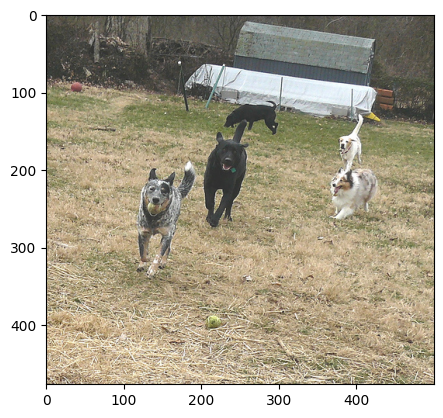

Caption: black dog is running through grassy


In [ ]:
z = 0
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

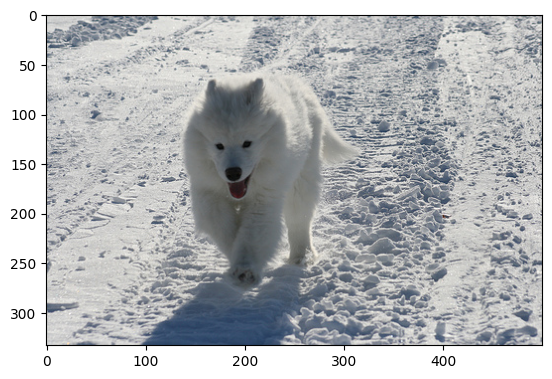

Caption: dog is running through the


In [ ]:
z = 50
pic = list(features.keys())[z]
image = features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))

**IMPORTANT: If you want to run the code on your own, follow the instructions from the beginning. Because everytime you disconnect the runtime, it will clear all the files from the /content/ folder.**